## Fit data using GLLS in SAMMY

This notebook works to shows how the sammy interface module of ATARI can be used to fit data with SAMMY

In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
from dataclasses import asdict
from copy import copy

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.theory.resonance_statistics import make_res_par_avg
from ATARI.sammy_interface import sammy_classes, sammy_functions

import importlib


In [2]:
%matplotlib widget

# First, setup/generate synthetic data using SAMMY

#### Define physical values, experiment, and resonance ladder

In [3]:
ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

Elam = 50.0
E_min_max = [np.max([Elam-20, 1.0]), Elam+20]
energy_grid = E_min_max
input_options = {'Add Noise': True,
                'Calculate Covariance': False,
                'Compression Points':[],
                'Grouping Factors':None}

# experiment_parameters = {'bw': {'val':0.8192,   'unc'   :   0},
#                          'n':  {'val':0.067166,     'unc'   :0}}
experiment_parameters = {'bw': {'val':0.1024,   'unc'   :   0},
                         'n':  {'val':0.067166,     'unc'   :0}}
# experiment_parameters = {'bw': {'val':0.0256,   'unc'   :   0},
#                          'n':  {'val':0.067166,     'unc'   :0}}

exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)

# for Gg_DOF in [10,50,100,1000,10000]:
Gg_DOF = 10

from ATARI.theory import scattering_params
shift, penetration, phi, k = scattering_params.FofE_explicit([1,500], ac, M, m, 0)
res_par_avg = make_res_par_avg(D_avg = 8.79, 
                            Gn_avg= np.mean(penetration)*2*46.4, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = Gg_DOF, 
                            print = False)


spin_groups = [ (3.0,1,0) ]
average_parameters = {'3.0':res_par_avg}

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   
# resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)
resonance_ladder = pd.DataFrame({"E":[31.8030900, 32.3453560, 43.3031830, 56.0645210, 63.9661590],
                                 "Gg":[54.9451300, 59.0939900, 59.7455500, 86.1347900, 67.1257900],
                                 "Gn1":[0.3913400,0.0582700,2.9012500,2.1717400,0.0021400],
                                 "J":[ 3,3,3,3,3], "chs":[1,1,1,1,1], "lwave":[0,0,0,0,0], "J_ID":[1,1,1,1,1]})
# resonance_ladder = pd.DataFrame({'E':[80.0], 'Gt':[16], 'Gn':[1], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})
# resonance_ladder = pd.DataFrame({'E':[4.0], 'Gg':[7.0], 'Gn':[4.0], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})
resonance_ladder

,E,Gg,Gn1,J,chs,lwave,J_ID
0,31.803090,54.94513,0.39134,3,1,0,1
1,32.345356,59.09399,0.05827,3,1,0,1
2,43.303183,59.74555,2.90125,3,1,0,1
3,56.064521,86.13479,2.17174,3,1,0,1
4,63.966159,67.12579,0.00214,3,1,0,1


#### Calculate theoretical cross-section using SAMMY and run Syndat experiment

This will be the first introduction to the sammy input and runtime objects. These data classes control the data given to sammy and how sammy should run.

The runtime object has the following attributes and defaults:
```
class SammyRunTimeOptions:
    path_to_SAMMY_exe: str
    model: str = 'XCT'
    reaction: str = 'total'
    experimental_corrections: str = 'all_exp'
    solve_bayes: bool = False
    one_spingroup: bool = False
    energy_window: Optional[float] = None
    sammy_runDIR: str = 'SAMMY_runDIR'
    keep_runDIR: bool = False
    shell: str = 'zsh'
    recursive: bool = False
    recursive_opt: dict = field(default_factory=lambda: {"threshold":0.01,
                                                        "iterations": 5,
                                                        "print":False}      )
```


In [4]:
importlib.reload(sammy_classes)
importlib.reload(sammy_functions)

sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    sammy_runDIR = 'SAMMY_runDIR',
    keep_runDIR = False,
    shell = 'zsh',

    model = 'XCT',
    reaction = 'transmission',
    solve_bayes = False,
    inptemplate = "allexptot_1sg.inp",
    inpname = "sammy.inp"

    )

sammyINP = sammy_classes.SammyInputData(
    particle_pair = Ta_pair,
    resonance_ladder = resonance_ladder,
    energy_grid = exp.energy_domain,
    
    temp = 304.5,
    FP=35.185,
    frac_res_FP=0.049600,
    target_thickness=0.067166)

sammyOUT = sammy_functions.run_sammy(sammyINP, sammyRTO)

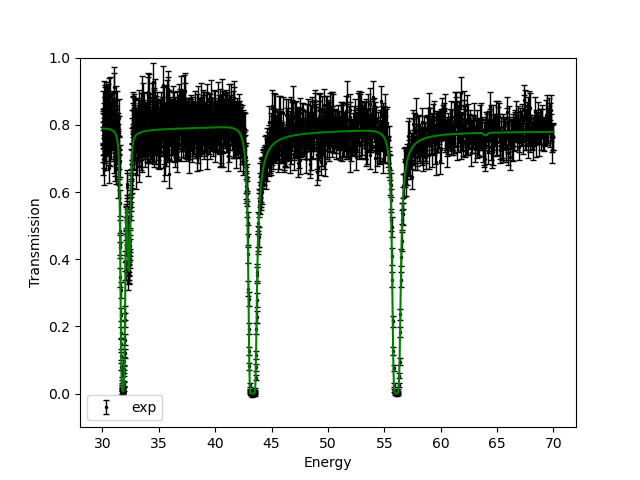

In [5]:
exp.run(sammyOUT.pw)

figure()
plot(sammyOUT.pw.E, sammyOUT.pw.theo_trans, ms=1, color='g')
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

# plot(exp.trans.E, exp.trans.theo_trans, color='g', lw=1, label='Sol', zorder=2)

ylim([-.1, 1])
# xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()

## This data can be fit directly by changing the solve_bayes option in the sammyRTO

In sammyINP, the resonance_ladder property gives the prior parameters and the experimental_data property supplies a dataframe of measurement data and uncertainty. Alternatively, a data covariance matrix can be supplied - though currently sammy_interface is only able to use the diagonal in the GLLS solve.

In the sammyRTO object, it is important to change the reaction to the type of data supplied in sammyINP.experimental_data['exp'].

Another useful option in sammyRTO is the recursive sammy flag. This will cause sammy GLLS to be called multiple times and each time the posterior becomes the prior. In some cases, this will give a better MLE solution to the problem as it allows the parameters to adjust more. Options for this routine can be supplied in sammyRTO.recursive_opt, these control maximum iterations, termination criteria, and printout.

<!-- | Attribute                         | Description               |
| ----------                        | -----------               |
| resonance_ladder                  | prior parameters          |
| experimental_data                 | dataframe with experimental data & unc|
| initial_parameter_uncertainty     | prior parameter uncertainty           | -->


In [6]:
resonance_ladder

,E,Gg,Gn1,J,chs,lwave,J_ID
0,31.803090,54.94513,0.39134,3,1,0,1
1,32.345356,59.09399,0.05827,3,1,0,1
2,43.303183,59.74555,2.90125,3,1,0,1
3,56.064521,86.13479,2.17174,3,1,0,1
4,63.966159,67.12579,0.00214,3,1,0,1


In [7]:
estladder = copy(resonance_ladder)
estladder[["Gg", "Gn1"]] = estladder[["Gg", "Gn1"]]
estladder

,E,Gg,Gn1,J,chs,lwave,J_ID
0,31.803090,54.94513,0.39134,3,1,0,1
1,32.345356,59.09399,0.05827,3,1,0,1
2,43.303183,59.74555,2.90125,3,1,0,1
3,56.064521,86.13479,2.17174,3,1,0,1
4,63.966159,67.12579,0.00214,3,1,0,1


In [8]:
sammyRTO.recursive_opt

{'threshold': 0.01, 'iterations': 5, 'print': False}

In [17]:
importlib.reload(sammy_functions)
sammyRTO.solve_bayes = True
sammyRTO.reaction = 'transmission'
sammyRTO.keep_runDIR = True
sammyRTO.get_ECSCM = True    # option to calculate ECSCM after bayes solve

sammyRTO.recursive = False
sammyRTO.recursive_opt = {"threshold":0.01,
                            "iterations": 20,
                            "print":True}

sammyINP.experimental_data = exp.trans
sammyINP.resonance_ladder = estladder
sammyINP.initial_parameter_uncertainty = 1000

sammyOUT_fit = sammy_functions.run_sammy(sammyINP, sammyRTO)

# print("prior resonance ladder:\n", sammyOUT_fit.par)
# print()
# print("posterior resonance ladder:\n",sammyOUT_fit.par_post)

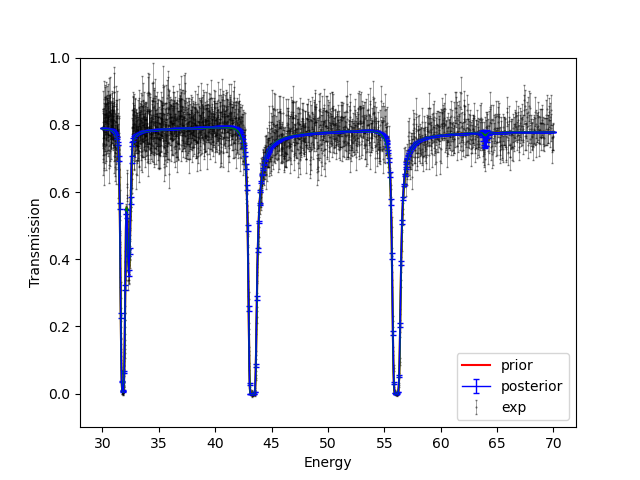

In [18]:
# exp.trans.exp_unc = exp.trans.exp_unc/10
# test = sammy_functions.readlst("/Users/noahwalton/Documents/GitHub/ATARI/examples/SAMMY_runDIR/SAMMY.LST")

figure()
plot(sammyOUT_fit.pw.E, sammyOUT_fit.pw.theo_trans, ms=1, color='r', label='prior')
# plot(sammyOUT_fit.pw.E, sammyOUT_fit.pw.theo_trans_bayes, ms=1, color='b', label='posterior')
errorbar(sammyOUT_fit.est_df.E, sammyOUT_fit.est_df.theo, yerr=sammyOUT_fit.est_df.theo_unc, 
                                                                        linewidth=1, markersize=3, capsize=2, color='b', label='posterior')

plot(sammyOUT.pw.E, sammyOUT.pw.theo_trans, ms=1, color='g')
# plot(test.E, test.theo_trans_bayes, 'pink')
errorbar(exp.trans.E, exp.trans.exp, yerr=exp.trans.exp_unc, zorder=0, alpha =0.5,
                                        fmt='.', color='k', linewidth=0.5, markersize=1, capsize=1, label='exp')

ylim([-.1, 1])
# xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()

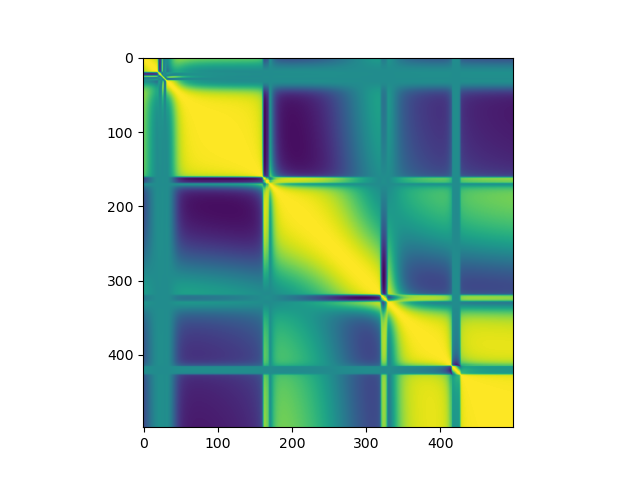

In [11]:
from ATARI.utils.stats import cov2corr

corr = cov2corr(sammyOUT_fit.ECSCM)

figure()
imshow(corr)



81.4 µs ± 957 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


2.220446049250313e-16

In [89]:
print(np.array([[1],[2]]))
print(np.array([[1, 2]]))
np.array([[1],[2]]) @ np.array([[1, 2]])

[[1]
 [2]]
[[1 2]]


array([[1, 2],
       [2, 4]])

In [41]:
# data = np.genfromtxt(file_path, delimiter=None, skip_header=3)

# # Split the data into separate arrays for T, ΔT, E, and the covariance matrix
# T = data[:, 0]
# Delta_T = data[:, 1]
# E = data[:, 2]
# covariance_matrix = data[:, 3:]

ValueError: Some errors were detected !
    Line #5 (got 1000 columns instead of 567)
    Line #7 (got 501 columns instead of 567)
    Line #8 (got 500 columns instead of 567)
    Line #9 (got 500 columns instead of 567)
    Line #10 (got 69 columns instead of 567)
    Line #11 (got 501 columns instead of 567)
    Line #12 (got 500 columns instead of 567)
    Line #13 (got 500 columns instead of 567)
    Line #14 (got 69 columns instead of 567)
    Line #15 (got 501 columns instead of 567)
    Line #16 (got 500 columns instead of 567)
    Line #17 (got 500 columns instead of 567)
    Line #18 (got 69 columns instead of 567)
    Line #19 (got 501 columns instead of 567)
    Line #20 (got 500 columns instead of 567)
    Line #21 (got 500 columns instead of 567)
    Line #22 (got 69 columns instead of 567)
    Line #23 (got 501 columns instead of 567)
    Line #24 (got 500 columns instead of 567)
    Line #25 (got 500 columns instead of 567)
    Line #26 (got 69 columns instead of 567)
    Line #27 (got 501 columns instead of 567)
    Line #28 (got 500 columns instead of 567)
    Line #29 (got 500 columns instead of 567)
    Line #30 (got 69 columns instead of 567)
    Line #31 (got 501 columns instead of 567)
    Line #32 (got 500 columns instead of 567)
    Line #33 (got 500 columns instead of 567)
    Line #34 (got 69 columns instead of 567)
    Line #35 (got 501 columns instead of 567)
    Line #36 (got 500 columns instead of 567)
    Line #37 (got 500 columns instead of 567)
    Line #38 (got 69 columns instead of 567)
    Line #39 (got 501 columns instead of 567)
    Line #40 (got 500 columns instead of 567)
    Line #41 (got 500 columns instead of 567)
    Line #42 (got 69 columns instead of 567)
    Line #43 (got 501 columns instead of 567)
    Line #44 (got 500 columns instead of 567)
    Line #45 (got 500 columns instead of 567)
    Line #46 (got 69 columns instead of 567)
    Line #47 (got 501 columns instead of 567)
    Line #48 (got 500 columns instead of 567)
    Line #49 (got 500 columns instead of 567)
    Line #50 (got 69 columns instead of 567)
    Line #51 (got 501 columns instead of 567)
    Line #52 (got 500 columns instead of 567)
    Line #53 (got 500 columns instead of 567)
    Line #54 (got 69 columns instead of 567)
    Line #55 (got 501 columns instead of 567)
    Line #56 (got 500 columns instead of 567)
    Line #57 (got 500 columns instead of 567)
    Line #58 (got 69 columns instead of 567)
    Line #59 (got 501 columns instead of 567)
    Line #60 (got 500 columns instead of 567)
    Line #61 (got 500 columns instead of 567)
    Line #62 (got 69 columns instead of 567)
    Line #63 (got 501 columns instead of 567)
    Line #64 (got 500 columns instead of 567)
    Line #65 (got 500 columns instead of 567)
    Line #66 (got 69 columns instead of 567)
    Line #67 (got 501 columns instead of 567)
    Line #68 (got 500 columns instead of 567)
    Line #69 (got 500 columns instead of 567)
    Line #70 (got 69 columns instead of 567)
    Line #71 (got 501 columns instead of 567)
    Line #72 (got 500 columns instead of 567)
    Line #73 (got 500 columns instead of 567)
    Line #74 (got 69 columns instead of 567)
    Line #75 (got 501 columns instead of 567)
    Line #76 (got 500 columns instead of 567)
    Line #77 (got 500 columns instead of 567)
    Line #78 (got 69 columns instead of 567)
    Line #79 (got 501 columns instead of 567)
    Line #80 (got 500 columns instead of 567)
    Line #81 (got 500 columns instead of 567)
    Line #82 (got 69 columns instead of 567)
    Line #83 (got 501 columns instead of 567)
    Line #84 (got 500 columns instead of 567)
    Line #85 (got 500 columns instead of 567)
    Line #86 (got 69 columns instead of 567)
    Line #87 (got 501 columns instead of 567)
    Line #88 (got 500 columns instead of 567)
    Line #89 (got 500 columns instead of 567)
    Line #90 (got 69 columns instead of 567)
    Line #91 (got 501 columns instead of 567)
    Line #92 (got 500 columns instead of 567)
    Line #93 (got 500 columns instead of 567)
    Line #94 (got 69 columns instead of 567)
    Line #95 (got 501 columns instead of 567)
    Line #96 (got 500 columns instead of 567)
    Line #97 (got 500 columns instead of 567)
    Line #98 (got 69 columns instead of 567)
    Line #99 (got 501 columns instead of 567)
    Line #100 (got 500 columns instead of 567)
    Line #101 (got 500 columns instead of 567)
    Line #102 (got 69 columns instead of 567)
    Line #103 (got 501 columns instead of 567)
    Line #104 (got 500 columns instead of 567)
    Line #105 (got 500 columns instead of 567)
    Line #106 (got 69 columns instead of 567)
    Line #107 (got 501 columns instead of 567)
    Line #108 (got 500 columns instead of 567)
    Line #109 (got 500 columns instead of 567)
    Line #110 (got 69 columns instead of 567)
    Line #111 (got 501 columns instead of 567)
    Line #112 (got 500 columns instead of 567)
    Line #113 (got 500 columns instead of 567)
    Line #114 (got 69 columns instead of 567)
    Line #115 (got 501 columns instead of 567)
    Line #116 (got 500 columns instead of 567)
    Line #117 (got 500 columns instead of 567)
    Line #118 (got 69 columns instead of 567)
    Line #119 (got 501 columns instead of 567)
    Line #120 (got 500 columns instead of 567)
    Line #121 (got 500 columns instead of 567)
    Line #122 (got 69 columns instead of 567)
    Line #123 (got 501 columns instead of 567)
    Line #124 (got 500 columns instead of 567)
    Line #125 (got 500 columns instead of 567)
    Line #126 (got 69 columns instead of 567)
    Line #127 (got 501 columns instead of 567)
    Line #128 (got 500 columns instead of 567)
    Line #129 (got 500 columns instead of 567)
    Line #130 (got 69 columns instead of 567)
    Line #131 (got 501 columns instead of 567)
    Line #132 (got 500 columns instead of 567)
    Line #133 (got 500 columns instead of 567)
    Line #134 (got 69 columns instead of 567)
    Line #135 (got 501 columns instead of 567)
    Line #136 (got 500 columns instead of 567)
    Line #137 (got 500 columns instead of 567)
    Line #138 (got 69 columns instead of 567)
    Line #139 (got 501 columns instead of 567)
    Line #140 (got 500 columns instead of 567)
    Line #141 (got 500 columns instead of 567)
    Line #142 (got 69 columns instead of 567)
    Line #143 (got 501 columns instead of 567)
    Line #144 (got 500 columns instead of 567)
    Line #145 (got 500 columns instead of 567)
    Line #146 (got 69 columns instead of 567)
    Line #147 (got 501 columns instead of 567)
    Line #148 (got 500 columns instead of 567)
    Line #149 (got 500 columns instead of 567)
    Line #150 (got 69 columns instead of 567)
    Line #151 (got 501 columns instead of 567)
    Line #152 (got 500 columns instead of 567)
    Line #153 (got 500 columns instead of 567)
    Line #154 (got 69 columns instead of 567)
    Line #155 (got 501 columns instead of 567)
    Line #156 (got 500 columns instead of 567)
    Line #157 (got 500 columns instead of 567)
    Line #158 (got 69 columns instead of 567)
    Line #159 (got 501 columns instead of 567)
    Line #160 (got 500 columns instead of 567)
    Line #161 (got 500 columns instead of 567)
    Line #162 (got 69 columns instead of 567)
    Line #163 (got 501 columns instead of 567)
    Line #164 (got 500 columns instead of 567)
    Line #165 (got 500 columns instead of 567)
    Line #166 (got 69 columns instead of 567)
    Line #167 (got 501 columns instead of 567)
    Line #168 (got 500 columns instead of 567)
    Line #169 (got 500 columns instead of 567)
    Line #170 (got 69 columns instead of 567)
    Line #171 (got 501 columns instead of 567)
    Line #172 (got 500 columns instead of 567)
    Line #173 (got 500 columns instead of 567)
    Line #174 (got 69 columns instead of 567)
    Line #175 (got 501 columns instead of 567)
    Line #176 (got 500 columns instead of 567)
    Line #177 (got 500 columns instead of 567)
    Line #178 (got 69 columns instead of 567)
    Line #179 (got 501 columns instead of 567)
    Line #180 (got 500 columns instead of 567)
    Line #181 (got 500 columns instead of 567)
    Line #182 (got 69 columns instead of 567)
    Line #183 (got 501 columns instead of 567)
    Line #184 (got 500 columns instead of 567)
    Line #185 (got 500 columns instead of 567)
    Line #186 (got 69 columns instead of 567)
    Line #187 (got 501 columns instead of 567)
    Line #188 (got 500 columns instead of 567)
    Line #189 (got 500 columns instead of 567)
    Line #190 (got 69 columns instead of 567)
    Line #191 (got 501 columns instead of 567)
    Line #192 (got 500 columns instead of 567)
    Line #193 (got 500 columns instead of 567)
    Line #194 (got 69 columns instead of 567)
    Line #195 (got 501 columns instead of 567)
    Line #196 (got 500 columns instead of 567)
    Line #197 (got 500 columns instead of 567)
    Line #198 (got 69 columns instead of 567)
    Line #199 (got 501 columns instead of 567)
    Line #200 (got 500 columns instead of 567)
    Line #201 (got 500 columns instead of 567)
    Line #202 (got 69 columns instead of 567)
    Line #203 (got 501 columns instead of 567)
    Line #204 (got 500 columns instead of 567)
    Line #205 (got 500 columns instead of 567)
    Line #206 (got 69 columns instead of 567)
    Line #207 (got 501 columns instead of 567)
    Line #208 (got 500 columns instead of 567)
    Line #209 (got 500 columns instead of 567)
    Line #210 (got 69 columns instead of 567)
    Line #211 (got 501 columns instead of 567)
    Line #212 (got 500 columns instead of 567)
    Line #213 (got 500 columns instead of 567)
    Line #214 (got 69 columns instead of 567)
    Line #215 (got 501 columns instead of 567)
    Line #216 (got 500 columns instead of 567)
    Line #217 (got 500 columns instead of 567)
    Line #218 (got 69 columns instead of 567)
    Line #219 (got 501 columns instead of 567)
    Line #220 (got 500 columns instead of 567)
    Line #221 (got 500 columns instead of 567)
    Line #222 (got 69 columns instead of 567)
    Line #223 (got 501 columns instead of 567)
    Line #224 (got 500 columns instead of 567)
    Line #225 (got 500 columns instead of 567)
    Line #226 (got 69 columns instead of 567)
    Line #227 (got 501 columns instead of 567)
    Line #228 (got 500 columns instead of 567)
    Line #229 (got 500 columns instead of 567)
    Line #230 (got 69 columns instead of 567)
    Line #231 (got 501 columns instead of 567)
    Line #232 (got 500 columns instead of 567)
    Line #233 (got 500 columns instead of 567)
    Line #234 (got 69 columns instead of 567)
    Line #235 (got 501 columns instead of 567)
    Line #236 (got 500 columns instead of 567)
    Line #237 (got 500 columns instead of 567)
    Line #238 (got 69 columns instead of 567)
    Line #239 (got 501 columns instead of 567)
    Line #240 (got 500 columns instead of 567)
    Line #241 (got 500 columns instead of 567)
    Line #242 (got 69 columns instead of 567)
    Line #243 (got 501 columns instead of 567)
    Line #244 (got 500 columns instead of 567)
    Line #245 (got 500 columns instead of 567)
    Line #246 (got 69 columns instead of 567)
    Line #247 (got 501 columns instead of 567)
    Line #248 (got 500 columns instead of 567)
    Line #249 (got 500 columns instead of 567)
    Line #250 (got 69 columns instead of 567)
    Line #251 (got 501 columns instead of 567)
    Line #252 (got 500 columns instead of 567)
    Line #253 (got 500 columns instead of 567)
    Line #254 (got 69 columns instead of 567)
    Line #255 (got 501 columns instead of 567)
    Line #256 (got 500 columns instead of 567)
    Line #257 (got 500 columns instead of 567)
    Line #258 (got 69 columns instead of 567)
    Line #259 (got 501 columns instead of 567)
    Line #260 (got 500 columns instead of 567)
    Line #261 (got 500 columns instead of 567)
    Line #262 (got 69 columns instead of 567)
    Line #263 (got 501 columns instead of 567)
    Line #264 (got 500 columns instead of 567)
    Line #265 (got 500 columns instead of 567)
    Line #266 (got 69 columns instead of 567)
    Line #267 (got 501 columns instead of 567)
    Line #268 (got 500 columns instead of 567)
    Line #269 (got 500 columns instead of 567)
    Line #270 (got 69 columns instead of 567)
    Line #271 (got 501 columns instead of 567)
    Line #272 (got 500 columns instead of 567)
    Line #273 (got 500 columns instead of 567)
    Line #274 (got 69 columns instead of 567)
    Line #275 (got 501 columns instead of 567)
    Line #276 (got 500 columns instead of 567)
    Line #277 (got 500 columns instead of 567)
    Line #278 (got 69 columns instead of 567)
    Line #279 (got 501 columns instead of 567)
    Line #280 (got 500 columns instead of 567)
    Line #281 (got 500 columns instead of 567)
    Line #282 (got 69 columns instead of 567)
    Line #283 (got 501 columns instead of 567)
    Line #284 (got 500 columns instead of 567)
    Line #285 (got 500 columns instead of 567)
    Line #286 (got 69 columns instead of 567)
    Line #287 (got 501 columns instead of 567)
    Line #288 (got 500 columns instead of 567)
    Line #289 (got 500 columns instead of 567)
    Line #290 (got 69 columns instead of 567)
    Line #291 (got 501 columns instead of 567)
    Line #292 (got 500 columns instead of 567)
    Line #293 (got 500 columns instead of 567)
    Line #294 (got 69 columns instead of 567)
    Line #295 (got 501 columns instead of 567)
    Line #296 (got 500 columns instead of 567)
    Line #297 (got 500 columns instead of 567)
    Line #298 (got 69 columns instead of 567)
    Line #299 (got 501 columns instead of 567)
    Line #300 (got 500 columns instead of 567)
    Line #301 (got 500 columns instead of 567)
    Line #302 (got 69 columns instead of 567)
    Line #303 (got 501 columns instead of 567)
    Line #304 (got 500 columns instead of 567)
    Line #305 (got 500 columns instead of 567)
    Line #306 (got 69 columns instead of 567)
    Line #307 (got 501 columns instead of 567)
    Line #308 (got 500 columns instead of 567)
    Line #309 (got 500 columns instead of 567)
    Line #310 (got 69 columns instead of 567)
    Line #311 (got 501 columns instead of 567)
    Line #312 (got 500 columns instead of 567)
    Line #313 (got 500 columns instead of 567)
    Line #314 (got 69 columns instead of 567)
    Line #315 (got 501 columns instead of 567)
    Line #316 (got 500 columns instead of 567)
    Line #317 (got 500 columns instead of 567)
    Line #318 (got 69 columns instead of 567)
    Line #319 (got 501 columns instead of 567)
    Line #320 (got 500 columns instead of 567)
    Line #321 (got 500 columns instead of 567)
    Line #322 (got 69 columns instead of 567)
    Line #323 (got 501 columns instead of 567)
    Line #324 (got 500 columns instead of 567)
    Line #325 (got 500 columns instead of 567)
    Line #326 (got 69 columns instead of 567)
    Line #327 (got 501 columns instead of 567)
    Line #328 (got 500 columns instead of 567)
    Line #329 (got 500 columns instead of 567)
    Line #330 (got 69 columns instead of 567)
    Line #331 (got 501 columns instead of 567)
    Line #332 (got 500 columns instead of 567)
    Line #333 (got 500 columns instead of 567)
    Line #334 (got 69 columns instead of 567)
    Line #335 (got 501 columns instead of 567)
    Line #336 (got 500 columns instead of 567)
    Line #337 (got 500 columns instead of 567)
    Line #338 (got 69 columns instead of 567)
    Line #339 (got 501 columns instead of 567)
    Line #340 (got 500 columns instead of 567)
    Line #341 (got 500 columns instead of 567)
    Line #342 (got 69 columns instead of 567)
    Line #343 (got 501 columns instead of 567)
    Line #344 (got 500 columns instead of 567)
    Line #345 (got 500 columns instead of 567)
    Line #346 (got 69 columns instead of 567)
    Line #347 (got 501 columns instead of 567)
    Line #348 (got 500 columns instead of 567)
    Line #349 (got 500 columns instead of 567)
    Line #350 (got 69 columns instead of 567)
    Line #351 (got 501 columns instead of 567)
    Line #352 (got 500 columns instead of 567)
    Line #353 (got 500 columns instead of 567)
    Line #354 (got 69 columns instead of 567)
    Line #355 (got 501 columns instead of 567)
    Line #356 (got 500 columns instead of 567)
    Line #357 (got 500 columns instead of 567)
    Line #358 (got 69 columns instead of 567)
    Line #359 (got 501 columns instead of 567)
    Line #360 (got 500 columns instead of 567)
    Line #361 (got 500 columns instead of 567)
    Line #362 (got 69 columns instead of 567)
    Line #363 (got 501 columns instead of 567)
    Line #364 (got 500 columns instead of 567)
    Line #365 (got 500 columns instead of 567)
    Line #366 (got 69 columns instead of 567)
    Line #367 (got 501 columns instead of 567)
    Line #368 (got 500 columns instead of 567)
    Line #369 (got 500 columns instead of 567)
    Line #370 (got 69 columns instead of 567)
    Line #371 (got 501 columns instead of 567)
    Line #372 (got 500 columns instead of 567)
    Line #373 (got 500 columns instead of 567)
    Line #374 (got 69 columns instead of 567)
    Line #375 (got 501 columns instead of 567)
    Line #376 (got 500 columns instead of 567)
    Line #377 (got 500 columns instead of 567)
    Line #378 (got 69 columns instead of 567)
    Line #379 (got 501 columns instead of 567)
    Line #380 (got 500 columns instead of 567)
    Line #381 (got 500 columns instead of 567)
    Line #382 (got 69 columns instead of 567)
    Line #383 (got 501 columns instead of 567)
    Line #384 (got 500 columns instead of 567)
    Line #385 (got 500 columns instead of 567)
    Line #386 (got 69 columns instead of 567)
    Line #387 (got 501 columns instead of 567)
    Line #388 (got 500 columns instead of 567)
    Line #389 (got 500 columns instead of 567)
    Line #390 (got 69 columns instead of 567)
    Line #391 (got 501 columns instead of 567)
    Line #392 (got 500 columns instead of 567)
    Line #393 (got 500 columns instead of 567)
    Line #394 (got 69 columns instead of 567)
    Line #395 (got 501 columns instead of 567)
    Line #396 (got 500 columns instead of 567)
    Line #397 (got 500 columns instead of 567)
    Line #398 (got 69 columns instead of 567)
    Line #399 (got 501 columns instead of 567)
    Line #400 (got 500 columns instead of 567)
    Line #401 (got 500 columns instead of 567)
    Line #402 (got 69 columns instead of 567)
    Line #403 (got 501 columns instead of 567)
    Line #404 (got 500 columns instead of 567)
    Line #405 (got 500 columns instead of 567)
    Line #406 (got 69 columns instead of 567)
    Line #407 (got 501 columns instead of 567)
    Line #408 (got 500 columns instead of 567)
    Line #409 (got 500 columns instead of 567)
    Line #410 (got 69 columns instead of 567)
    Line #411 (got 501 columns instead of 567)
    Line #412 (got 500 columns instead of 567)
    Line #413 (got 500 columns instead of 567)
    Line #414 (got 69 columns instead of 567)
    Line #415 (got 501 columns instead of 567)
    Line #416 (got 500 columns instead of 567)
    Line #417 (got 500 columns instead of 567)
    Line #418 (got 69 columns instead of 567)
    Line #419 (got 501 columns instead of 567)
    Line #420 (got 500 columns instead of 567)
    Line #421 (got 500 columns instead of 567)
    Line #422 (got 69 columns instead of 567)
    Line #423 (got 501 columns instead of 567)
    Line #424 (got 500 columns instead of 567)
    Line #425 (got 500 columns instead of 567)
    Line #426 (got 69 columns instead of 567)
    Line #427 (got 501 columns instead of 567)
    Line #428 (got 500 columns instead of 567)
    Line #429 (got 500 columns instead of 567)
    Line #430 (got 69 columns instead of 567)
    Line #431 (got 501 columns instead of 567)
    Line #432 (got 500 columns instead of 567)
    Line #433 (got 500 columns instead of 567)
    Line #434 (got 69 columns instead of 567)
    Line #435 (got 501 columns instead of 567)
    Line #436 (got 500 columns instead of 567)
    Line #437 (got 500 columns instead of 567)
    Line #438 (got 69 columns instead of 567)
    Line #439 (got 501 columns instead of 567)
    Line #440 (got 500 columns instead of 567)
    Line #441 (got 500 columns instead of 567)
    Line #442 (got 69 columns instead of 567)
    Line #443 (got 501 columns instead of 567)
    Line #444 (got 500 columns instead of 567)
    Line #445 (got 500 columns instead of 567)
    Line #446 (got 69 columns instead of 567)
    Line #447 (got 501 columns instead of 567)
    Line #448 (got 500 columns instead of 567)
    Line #449 (got 500 columns instead of 567)
    Line #450 (got 69 columns instead of 567)
    Line #451 (got 501 columns instead of 567)
    Line #452 (got 500 columns instead of 567)
    Line #453 (got 500 columns instead of 567)
    Line #454 (got 69 columns instead of 567)
    Line #455 (got 501 columns instead of 567)
    Line #456 (got 500 columns instead of 567)
    Line #457 (got 500 columns instead of 567)
    Line #458 (got 69 columns instead of 567)
    Line #459 (got 501 columns instead of 567)
    Line #460 (got 500 columns instead of 567)
    Line #461 (got 500 columns instead of 567)
    Line #462 (got 69 columns instead of 567)
    Line #463 (got 501 columns instead of 567)
    Line #464 (got 500 columns instead of 567)
    Line #465 (got 500 columns instead of 567)
    Line #466 (got 69 columns instead of 567)
    Line #467 (got 501 columns instead of 567)
    Line #468 (got 500 columns instead of 567)
    Line #469 (got 500 columns instead of 567)
    Line #470 (got 69 columns instead of 567)
    Line #471 (got 501 columns instead of 567)
    Line #472 (got 500 columns instead of 567)
    Line #473 (got 500 columns instead of 567)
    Line #474 (got 69 columns instead of 567)
    Line #475 (got 501 columns instead of 567)
    Line #476 (got 500 columns instead of 567)
    Line #477 (got 500 columns instead of 567)
    Line #478 (got 69 columns instead of 567)
    Line #479 (got 501 columns instead of 567)
    Line #480 (got 500 columns instead of 567)
    Line #481 (got 500 columns instead of 567)
    Line #482 (got 69 columns instead of 567)
    Line #483 (got 501 columns instead of 567)
    Line #484 (got 500 columns instead of 567)
    Line #485 (got 500 columns instead of 567)
    Line #486 (got 69 columns instead of 567)
    Line #487 (got 501 columns instead of 567)
    Line #488 (got 500 columns instead of 567)
    Line #489 (got 500 columns instead of 567)
    Line #490 (got 69 columns instead of 567)
    Line #491 (got 501 columns instead of 567)
    Line #492 (got 500 columns instead of 567)
    Line #493 (got 500 columns instead of 567)
    Line #494 (got 69 columns instead of 567)
    Line #495 (got 501 columns instead of 567)
    Line #496 (got 500 columns instead of 567)
    Line #497 (got 500 columns instead of 567)
    Line #498 (got 69 columns instead of 567)
    Line #499 (got 501 columns instead of 567)
    Line #500 (got 500 columns instead of 567)
    Line #501 (got 500 columns instead of 567)
    Line #502 (got 69 columns instead of 567)
    Line #503 (got 501 columns instead of 567)
    Line #504 (got 500 columns instead of 567)
    Line #505 (got 500 columns instead of 567)
    Line #506 (got 69 columns instead of 567)
    Line #507 (got 501 columns instead of 567)
    Line #508 (got 500 columns instead of 567)
    Line #509 (got 500 columns instead of 567)
    Line #510 (got 69 columns instead of 567)
    Line #511 (got 501 columns instead of 567)
    Line #512 (got 500 columns instead of 567)
    Line #513 (got 500 columns instead of 567)
    Line #514 (got 69 columns instead of 567)
    Line #515 (got 501 columns instead of 567)
    Line #516 (got 500 columns instead of 567)
    Line #517 (got 500 columns instead of 567)
    Line #518 (got 69 columns instead of 567)
    Line #519 (got 501 columns instead of 567)
    Line #520 (got 500 columns instead of 567)
    Line #521 (got 500 columns instead of 567)
    Line #522 (got 69 columns instead of 567)
    Line #523 (got 501 columns instead of 567)
    Line #524 (got 500 columns instead of 567)
    Line #525 (got 500 columns instead of 567)
    Line #526 (got 69 columns instead of 567)
    Line #527 (got 501 columns instead of 567)
    Line #528 (got 500 columns instead of 567)
    Line #529 (got 500 columns instead of 567)
    Line #530 (got 69 columns instead of 567)
    Line #531 (got 501 columns instead of 567)
    Line #532 (got 500 columns instead of 567)
    Line #533 (got 500 columns instead of 567)
    Line #534 (got 69 columns instead of 567)
    Line #535 (got 501 columns instead of 567)
    Line #536 (got 500 columns instead of 567)
    Line #537 (got 500 columns instead of 567)
    Line #538 (got 69 columns instead of 567)
    Line #539 (got 501 columns instead of 567)
    Line #540 (got 500 columns instead of 567)
    Line #541 (got 500 columns instead of 567)
    Line #542 (got 69 columns instead of 567)
    Line #543 (got 501 columns instead of 567)
    Line #544 (got 500 columns instead of 567)
    Line #545 (got 500 columns instead of 567)
    Line #546 (got 69 columns instead of 567)
    Line #547 (got 501 columns instead of 567)
    Line #548 (got 500 columns instead of 567)
    Line #549 (got 500 columns instead of 567)
    Line #550 (got 69 columns instead of 567)
    Line #551 (got 501 columns instead of 567)
    Line #552 (got 500 columns instead of 567)
    Line #553 (got 500 columns instead of 567)
    Line #554 (got 69 columns instead of 567)
    Line #555 (got 501 columns instead of 567)
    Line #556 (got 500 columns instead of 567)
    Line #557 (got 500 columns instead of 567)
    Line #558 (got 69 columns instead of 567)
    Line #559 (got 501 columns instead of 567)
    Line #560 (got 500 columns instead of 567)
    Line #561 (got 500 columns instead of 567)
    Line #562 (got 69 columns instead of 567)
    Line #563 (got 501 columns instead of 567)
    Line #564 (got 500 columns instead of 567)
    Line #565 (got 500 columns instead of 567)
    Line #566 (got 69 columns instead of 567)
    Line #567 (got 501 columns instead of 567)
    Line #568 (got 500 columns instead of 567)
    Line #569 (got 500 columns instead of 567)
    Line #570 (got 69 columns instead of 567)
    Line #571 (got 501 columns instead of 567)
    Line #572 (got 500 columns instead of 567)
    Line #573 (got 500 columns instead of 567)
    Line #574 (got 69 columns instead of 567)
    Line #575 (got 501 columns instead of 567)
    Line #576 (got 500 columns instead of 567)
    Line #577 (got 500 columns instead of 567)
    Line #578 (got 69 columns instead of 567)
    Line #579 (got 501 columns instead of 567)
    Line #580 (got 500 columns instead of 567)
    Line #581 (got 500 columns instead of 567)
    Line #582 (got 69 columns instead of 567)
    Line #583 (got 501 columns instead of 567)
    Line #584 (got 500 columns instead of 567)
    Line #585 (got 500 columns instead of 567)
    Line #586 (got 69 columns instead of 567)
    Line #587 (got 501 columns instead of 567)
    Line #588 (got 500 columns instead of 567)
    Line #589 (got 500 columns instead of 567)
    Line #590 (got 69 columns instead of 567)
    Line #591 (got 501 columns instead of 567)
    Line #592 (got 500 columns instead of 567)
    Line #593 (got 500 columns instead of 567)
    Line #594 (got 69 columns instead of 567)
    Line #595 (got 501 columns instead of 567)
    Line #596 (got 500 columns instead of 567)
    Line #597 (got 500 columns instead of 567)
    Line #598 (got 69 columns instead of 567)
    Line #599 (got 501 columns instead of 567)
    Line #600 (got 500 columns instead of 567)
    Line #601 (got 500 columns instead of 567)
    Line #602 (got 69 columns instead of 567)
    Line #603 (got 501 columns instead of 567)
    Line #604 (got 500 columns instead of 567)
    Line #605 (got 500 columns instead of 567)
    Line #606 (got 69 columns instead of 567)
    Line #607 (got 501 columns instead of 567)
    Line #608 (got 500 columns instead of 567)
    Line #609 (got 500 columns instead of 567)
    Line #610 (got 69 columns instead of 567)
    Line #611 (got 501 columns instead of 567)
    Line #612 (got 500 columns instead of 567)
    Line #613 (got 500 columns instead of 567)
    Line #614 (got 69 columns instead of 567)
    Line #615 (got 501 columns instead of 567)
    Line #616 (got 500 columns instead of 567)
    Line #617 (got 500 columns instead of 567)
    Line #618 (got 69 columns instead of 567)
    Line #619 (got 501 columns instead of 567)
    Line #620 (got 500 columns instead of 567)
    Line #621 (got 500 columns instead of 567)
    Line #622 (got 69 columns instead of 567)
    Line #623 (got 501 columns instead of 567)
    Line #624 (got 500 columns instead of 567)
    Line #625 (got 500 columns instead of 567)
    Line #626 (got 69 columns instead of 567)
    Line #627 (got 501 columns instead of 567)
    Line #628 (got 500 columns instead of 567)
    Line #629 (got 500 columns instead of 567)
    Line #630 (got 69 columns instead of 567)
    Line #631 (got 501 columns instead of 567)
    Line #632 (got 500 columns instead of 567)
    Line #633 (got 500 columns instead of 567)
    Line #634 (got 69 columns instead of 567)
    Line #635 (got 501 columns instead of 567)
    Line #636 (got 500 columns instead of 567)
    Line #637 (got 500 columns instead of 567)
    Line #638 (got 69 columns instead of 567)
    Line #639 (got 501 columns instead of 567)
    Line #640 (got 500 columns instead of 567)
    Line #641 (got 500 columns instead of 567)
    Line #642 (got 69 columns instead of 567)
    Line #643 (got 501 columns instead of 567)
    Line #644 (got 500 columns instead of 567)
    Line #645 (got 500 columns instead of 567)
    Line #646 (got 69 columns instead of 567)
    Line #647 (got 501 columns instead of 567)
    Line #648 (got 500 columns instead of 567)
    Line #649 (got 500 columns instead of 567)
    Line #650 (got 69 columns instead of 567)
    Line #651 (got 501 columns instead of 567)
    Line #652 (got 500 columns instead of 567)
    Line #653 (got 500 columns instead of 567)
    Line #654 (got 69 columns instead of 567)
    Line #655 (got 501 columns instead of 567)
    Line #656 (got 500 columns instead of 567)
    Line #657 (got 500 columns instead of 567)
    Line #658 (got 69 columns instead of 567)
    Line #659 (got 501 columns instead of 567)
    Line #660 (got 500 columns instead of 567)
    Line #661 (got 500 columns instead of 567)
    Line #662 (got 69 columns instead of 567)
    Line #663 (got 501 columns instead of 567)
    Line #664 (got 500 columns instead of 567)
    Line #665 (got 500 columns instead of 567)
    Line #666 (got 69 columns instead of 567)
    Line #667 (got 501 columns instead of 567)
    Line #668 (got 500 columns instead of 567)
    Line #669 (got 500 columns instead of 567)
    Line #670 (got 69 columns instead of 567)
    Line #671 (got 501 columns instead of 567)
    Line #672 (got 500 columns instead of 567)
    Line #673 (got 500 columns instead of 567)
    Line #674 (got 69 columns instead of 567)
    Line #675 (got 501 columns instead of 567)
    Line #676 (got 500 columns instead of 567)
    Line #677 (got 500 columns instead of 567)
    Line #678 (got 69 columns instead of 567)
    Line #679 (got 501 columns instead of 567)
    Line #680 (got 500 columns instead of 567)
    Line #681 (got 500 columns instead of 567)
    Line #682 (got 69 columns instead of 567)
    Line #683 (got 501 columns instead of 567)
    Line #684 (got 500 columns instead of 567)
    Line #685 (got 500 columns instead of 567)
    Line #686 (got 69 columns instead of 567)
    Line #687 (got 501 columns instead of 567)
    Line #688 (got 500 columns instead of 567)
    Line #689 (got 500 columns instead of 567)
    Line #690 (got 69 columns instead of 567)
    Line #691 (got 501 columns instead of 567)
    Line #692 (got 500 columns instead of 567)
    Line #693 (got 500 columns instead of 567)
    Line #694 (got 69 columns instead of 567)
    Line #695 (got 501 columns instead of 567)
    Line #696 (got 500 columns instead of 567)
    Line #697 (got 500 columns instead of 567)
    Line #698 (got 69 columns instead of 567)
    Line #699 (got 501 columns instead of 567)
    Line #700 (got 500 columns instead of 567)
    Line #701 (got 500 columns instead of 567)
    Line #702 (got 69 columns instead of 567)
    Line #703 (got 501 columns instead of 567)
    Line #704 (got 500 columns instead of 567)
    Line #705 (got 500 columns instead of 567)
    Line #706 (got 69 columns instead of 567)
    Line #707 (got 501 columns instead of 567)
    Line #708 (got 500 columns instead of 567)
    Line #709 (got 500 columns instead of 567)
    Line #710 (got 69 columns instead of 567)
    Line #711 (got 501 columns instead of 567)
    Line #712 (got 500 columns instead of 567)
    Line #713 (got 500 columns instead of 567)
    Line #714 (got 69 columns instead of 567)
    Line #715 (got 501 columns instead of 567)
    Line #716 (got 500 columns instead of 567)
    Line #717 (got 500 columns instead of 567)
    Line #718 (got 69 columns instead of 567)
    Line #719 (got 501 columns instead of 567)
    Line #720 (got 500 columns instead of 567)
    Line #721 (got 500 columns instead of 567)
    Line #722 (got 69 columns instead of 567)
    Line #723 (got 501 columns instead of 567)
    Line #724 (got 500 columns instead of 567)
    Line #725 (got 500 columns instead of 567)
    Line #726 (got 69 columns instead of 567)
    Line #727 (got 501 columns instead of 567)
    Line #728 (got 500 columns instead of 567)
    Line #729 (got 500 columns instead of 567)
    Line #730 (got 69 columns instead of 567)
    Line #731 (got 501 columns instead of 567)
    Line #732 (got 500 columns instead of 567)
    Line #733 (got 500 columns instead of 567)
    Line #734 (got 69 columns instead of 567)
    Line #735 (got 501 columns instead of 567)
    Line #736 (got 500 columns instead of 567)
    Line #737 (got 500 columns instead of 567)
    Line #738 (got 69 columns instead of 567)
    Line #739 (got 501 columns instead of 567)
    Line #740 (got 500 columns instead of 567)
    Line #741 (got 500 columns instead of 567)
    Line #742 (got 69 columns instead of 567)
    Line #743 (got 501 columns instead of 567)
    Line #744 (got 500 columns instead of 567)
    Line #745 (got 500 columns instead of 567)
    Line #746 (got 69 columns instead of 567)
    Line #747 (got 501 columns instead of 567)
    Line #748 (got 500 columns instead of 567)
    Line #749 (got 500 columns instead of 567)
    Line #750 (got 69 columns instead of 567)
    Line #751 (got 501 columns instead of 567)
    Line #752 (got 500 columns instead of 567)
    Line #753 (got 500 columns instead of 567)
    Line #754 (got 69 columns instead of 567)
    Line #755 (got 501 columns instead of 567)
    Line #756 (got 500 columns instead of 567)
    Line #757 (got 500 columns instead of 567)
    Line #758 (got 69 columns instead of 567)
    Line #759 (got 501 columns instead of 567)
    Line #760 (got 500 columns instead of 567)
    Line #761 (got 500 columns instead of 567)
    Line #762 (got 69 columns instead of 567)
    Line #763 (got 501 columns instead of 567)
    Line #764 (got 500 columns instead of 567)
    Line #765 (got 500 columns instead of 567)
    Line #766 (got 69 columns instead of 567)
    Line #767 (got 501 columns instead of 567)
    Line #768 (got 500 columns instead of 567)
    Line #769 (got 500 columns instead of 567)
    Line #770 (got 69 columns instead of 567)
    Line #771 (got 501 columns instead of 567)
    Line #772 (got 500 columns instead of 567)
    Line #773 (got 500 columns instead of 567)
    Line #774 (got 69 columns instead of 567)
    Line #775 (got 501 columns instead of 567)
    Line #776 (got 500 columns instead of 567)
    Line #777 (got 500 columns instead of 567)
    Line #778 (got 69 columns instead of 567)
    Line #779 (got 501 columns instead of 567)
    Line #780 (got 500 columns instead of 567)
    Line #781 (got 500 columns instead of 567)
    Line #782 (got 69 columns instead of 567)
    Line #783 (got 501 columns instead of 567)
    Line #784 (got 500 columns instead of 567)
    Line #785 (got 500 columns instead of 567)
    Line #786 (got 69 columns instead of 567)
    Line #787 (got 501 columns instead of 567)
    Line #788 (got 500 columns instead of 567)
    Line #789 (got 500 columns instead of 567)
    Line #790 (got 69 columns instead of 567)
    Line #791 (got 501 columns instead of 567)
    Line #792 (got 500 columns instead of 567)
    Line #793 (got 500 columns instead of 567)
    Line #794 (got 69 columns instead of 567)
    Line #795 (got 501 columns instead of 567)
    Line #796 (got 500 columns instead of 567)
    Line #797 (got 500 columns instead of 567)
    Line #798 (got 69 columns instead of 567)
    Line #799 (got 501 columns instead of 567)
    Line #800 (got 500 columns instead of 567)
    Line #801 (got 500 columns instead of 567)
    Line #802 (got 69 columns instead of 567)
    Line #803 (got 501 columns instead of 567)
    Line #804 (got 500 columns instead of 567)
    Line #805 (got 500 columns instead of 567)
    Line #806 (got 69 columns instead of 567)
    Line #807 (got 501 columns instead of 567)
    Line #808 (got 500 columns instead of 567)
    Line #809 (got 500 columns instead of 567)
    Line #810 (got 69 columns instead of 567)
    Line #811 (got 501 columns instead of 567)
    Line #812 (got 500 columns instead of 567)
    Line #813 (got 500 columns instead of 567)
    Line #814 (got 69 columns instead of 567)
    Line #815 (got 501 columns instead of 567)
    Line #816 (got 500 columns instead of 567)
    Line #817 (got 500 columns instead of 567)
    Line #818 (got 69 columns instead of 567)
    Line #819 (got 501 columns instead of 567)
    Line #820 (got 500 columns instead of 567)
    Line #821 (got 500 columns instead of 567)
    Line #822 (got 69 columns instead of 567)
    Line #823 (got 501 columns instead of 567)
    Line #824 (got 500 columns instead of 567)
    Line #825 (got 500 columns instead of 567)
    Line #826 (got 69 columns instead of 567)
    Line #827 (got 501 columns instead of 567)
    Line #828 (got 500 columns instead of 567)
    Line #829 (got 500 columns instead of 567)
    Line #830 (got 69 columns instead of 567)
    Line #831 (got 501 columns instead of 567)
    Line #832 (got 500 columns instead of 567)
    Line #833 (got 500 columns instead of 567)
    Line #834 (got 69 columns instead of 567)
    Line #835 (got 501 columns instead of 567)
    Line #836 (got 500 columns instead of 567)
    Line #837 (got 500 columns instead of 567)
    Line #838 (got 69 columns instead of 567)
    Line #839 (got 501 columns instead of 567)
    Line #840 (got 500 columns instead of 567)
    Line #841 (got 500 columns instead of 567)
    Line #842 (got 69 columns instead of 567)
    Line #843 (got 501 columns instead of 567)
    Line #844 (got 500 columns instead of 567)
    Line #845 (got 500 columns instead of 567)
    Line #846 (got 69 columns instead of 567)
    Line #847 (got 501 columns instead of 567)
    Line #848 (got 500 columns instead of 567)
    Line #849 (got 500 columns instead of 567)
    Line #850 (got 69 columns instead of 567)
    Line #851 (got 501 columns instead of 567)
    Line #852 (got 500 columns instead of 567)
    Line #853 (got 500 columns instead of 567)
    Line #854 (got 69 columns instead of 567)
    Line #855 (got 501 columns instead of 567)
    Line #856 (got 500 columns instead of 567)
    Line #857 (got 500 columns instead of 567)
    Line #858 (got 69 columns instead of 567)
    Line #859 (got 501 columns instead of 567)
    Line #860 (got 500 columns instead of 567)
    Line #861 (got 500 columns instead of 567)
    Line #862 (got 69 columns instead of 567)
    Line #863 (got 501 columns instead of 567)
    Line #864 (got 500 columns instead of 567)
    Line #865 (got 500 columns instead of 567)
    Line #866 (got 69 columns instead of 567)
    Line #867 (got 501 columns instead of 567)
    Line #868 (got 500 columns instead of 567)
    Line #869 (got 500 columns instead of 567)
    Line #870 (got 69 columns instead of 567)
    Line #871 (got 501 columns instead of 567)
    Line #872 (got 500 columns instead of 567)
    Line #873 (got 500 columns instead of 567)
    Line #874 (got 69 columns instead of 567)
    Line #875 (got 501 columns instead of 567)
    Line #876 (got 500 columns instead of 567)
    Line #877 (got 500 columns instead of 567)
    Line #878 (got 69 columns instead of 567)
    Line #879 (got 501 columns instead of 567)
    Line #880 (got 500 columns instead of 567)
    Line #881 (got 500 columns instead of 567)
    Line #882 (got 69 columns instead of 567)
    Line #883 (got 501 columns instead of 567)
    Line #884 (got 500 columns instead of 567)
    Line #885 (got 500 columns instead of 567)
    Line #886 (got 69 columns instead of 567)
    Line #887 (got 501 columns instead of 567)
    Line #888 (got 500 columns instead of 567)
    Line #889 (got 500 columns instead of 567)
    Line #890 (got 69 columns instead of 567)
    Line #891 (got 501 columns instead of 567)
    Line #892 (got 500 columns instead of 567)
    Line #893 (got 500 columns instead of 567)
    Line #894 (got 69 columns instead of 567)
    Line #895 (got 501 columns instead of 567)
    Line #896 (got 500 columns instead of 567)
    Line #897 (got 500 columns instead of 567)
    Line #898 (got 69 columns instead of 567)
    Line #899 (got 501 columns instead of 567)
    Line #900 (got 500 columns instead of 567)
    Line #901 (got 500 columns instead of 567)
    Line #902 (got 69 columns instead of 567)
    Line #903 (got 501 columns instead of 567)
    Line #904 (got 500 columns instead of 567)
    Line #905 (got 500 columns instead of 567)
    Line #906 (got 69 columns instead of 567)
    Line #907 (got 501 columns instead of 567)
    Line #908 (got 500 columns instead of 567)
    Line #909 (got 500 columns instead of 567)
    Line #910 (got 69 columns instead of 567)
    Line #911 (got 501 columns instead of 567)
    Line #912 (got 500 columns instead of 567)
    Line #913 (got 500 columns instead of 567)
    Line #914 (got 69 columns instead of 567)
    Line #915 (got 501 columns instead of 567)
    Line #916 (got 500 columns instead of 567)
    Line #917 (got 500 columns instead of 567)
    Line #918 (got 69 columns instead of 567)
    Line #919 (got 501 columns instead of 567)
    Line #920 (got 500 columns instead of 567)
    Line #921 (got 500 columns instead of 567)
    Line #922 (got 69 columns instead of 567)
    Line #923 (got 501 columns instead of 567)
    Line #924 (got 500 columns instead of 567)
    Line #925 (got 500 columns instead of 567)
    Line #926 (got 69 columns instead of 567)
    Line #927 (got 501 columns instead of 567)
    Line #928 (got 500 columns instead of 567)
    Line #929 (got 500 columns instead of 567)
    Line #930 (got 69 columns instead of 567)
    Line #931 (got 501 columns instead of 567)
    Line #932 (got 500 columns instead of 567)
    Line #933 (got 500 columns instead of 567)
    Line #934 (got 69 columns instead of 567)
    Line #935 (got 501 columns instead of 567)
    Line #936 (got 500 columns instead of 567)
    Line #937 (got 500 columns instead of 567)
    Line #938 (got 69 columns instead of 567)
    Line #939 (got 501 columns instead of 567)
    Line #940 (got 500 columns instead of 567)
    Line #941 (got 500 columns instead of 567)
    Line #942 (got 69 columns instead of 567)
    Line #943 (got 501 columns instead of 567)
    Line #944 (got 500 columns instead of 567)
    Line #945 (got 500 columns instead of 567)
    Line #946 (got 69 columns instead of 567)
    Line #947 (got 501 columns instead of 567)
    Line #948 (got 500 columns instead of 567)
    Line #949 (got 500 columns instead of 567)
    Line #950 (got 69 columns instead of 567)
    Line #951 (got 501 columns instead of 567)
    Line #952 (got 500 columns instead of 567)
    Line #953 (got 500 columns instead of 567)
    Line #954 (got 69 columns instead of 567)
    Line #955 (got 501 columns instead of 567)
    Line #956 (got 500 columns instead of 567)
    Line #957 (got 500 columns instead of 567)
    Line #958 (got 69 columns instead of 567)
    Line #959 (got 501 columns instead of 567)
    Line #960 (got 500 columns instead of 567)
    Line #961 (got 500 columns instead of 567)
    Line #962 (got 69 columns instead of 567)
    Line #963 (got 501 columns instead of 567)
    Line #964 (got 500 columns instead of 567)
    Line #965 (got 500 columns instead of 567)
    Line #966 (got 69 columns instead of 567)
    Line #967 (got 501 columns instead of 567)
    Line #968 (got 500 columns instead of 567)
    Line #969 (got 500 columns instead of 567)
    Line #970 (got 69 columns instead of 567)
    Line #971 (got 501 columns instead of 567)
    Line #972 (got 500 columns instead of 567)
    Line #973 (got 500 columns instead of 567)
    Line #974 (got 69 columns instead of 567)
    Line #975 (got 501 columns instead of 567)
    Line #976 (got 500 columns instead of 567)
    Line #977 (got 500 columns instead of 567)
    Line #978 (got 69 columns instead of 567)
    Line #979 (got 501 columns instead of 567)
    Line #980 (got 500 columns instead of 567)
    Line #981 (got 500 columns instead of 567)
    Line #982 (got 69 columns instead of 567)
    Line #983 (got 501 columns instead of 567)
    Line #984 (got 500 columns instead of 567)
    Line #985 (got 500 columns instead of 567)
    Line #986 (got 69 columns instead of 567)
    Line #987 (got 501 columns instead of 567)
    Line #988 (got 500 columns instead of 567)
    Line #989 (got 500 columns instead of 567)
    Line #990 (got 69 columns instead of 567)
    Line #991 (got 501 columns instead of 567)
    Line #992 (got 500 columns instead of 567)
    Line #993 (got 500 columns instead of 567)
    Line #994 (got 69 columns instead of 567)
    Line #995 (got 501 columns instead of 567)
    Line #996 (got 500 columns instead of 567)
    Line #997 (got 500 columns instead of 567)
    Line #998 (got 69 columns instead of 567)
    Line #999 (got 501 columns instead of 567)
    Line #1000 (got 500 columns instead of 567)
    Line #1001 (got 500 columns instead of 567)
    Line #1002 (got 69 columns instead of 567)
    Line #1003 (got 501 columns instead of 567)
    Line #1004 (got 500 columns instead of 567)
    Line #1005 (got 500 columns instead of 567)
    Line #1006 (got 69 columns instead of 567)
    Line #1007 (got 501 columns instead of 567)
    Line #1008 (got 500 columns instead of 567)
    Line #1009 (got 500 columns instead of 567)
    Line #1010 (got 69 columns instead of 567)
    Line #1011 (got 501 columns instead of 567)
    Line #1012 (got 500 columns instead of 567)
    Line #1013 (got 500 columns instead of 567)
    Line #1014 (got 69 columns instead of 567)
    Line #1015 (got 501 columns instead of 567)
    Line #1016 (got 500 columns instead of 567)
    Line #1017 (got 500 columns instead of 567)
    Line #1018 (got 69 columns instead of 567)
    Line #1019 (got 501 columns instead of 567)
    Line #1020 (got 500 columns instead of 567)
    Line #1021 (got 500 columns instead of 567)
    Line #1022 (got 69 columns instead of 567)
    Line #1023 (got 501 columns instead of 567)
    Line #1024 (got 500 columns instead of 567)
    Line #1025 (got 500 columns instead of 567)
    Line #1026 (got 69 columns instead of 567)
    Line #1027 (got 501 columns instead of 567)
    Line #1028 (got 500 columns instead of 567)
    Line #1029 (got 500 columns instead of 567)
    Line #1030 (got 69 columns instead of 567)
    Line #1031 (got 501 columns instead of 567)
    Line #1032 (got 500 columns instead of 567)
    Line #1033 (got 500 columns instead of 567)
    Line #1034 (got 69 columns instead of 567)
    Line #1035 (got 501 columns instead of 567)
    Line #1036 (got 500 columns instead of 567)
    Line #1037 (got 500 columns instead of 567)
    Line #1038 (got 69 columns instead of 567)
    Line #1039 (got 501 columns instead of 567)
    Line #1040 (got 500 columns instead of 567)
    Line #1041 (got 500 columns instead of 567)
    Line #1042 (got 69 columns instead of 567)
    Line #1043 (got 501 columns instead of 567)
    Line #1044 (got 500 columns instead of 567)
    Line #1045 (got 500 columns instead of 567)
    Line #1046 (got 69 columns instead of 567)
    Line #1047 (got 501 columns instead of 567)
    Line #1048 (got 500 columns instead of 567)
    Line #1049 (got 500 columns instead of 567)
    Line #1050 (got 69 columns instead of 567)
    Line #1051 (got 501 columns instead of 567)
    Line #1052 (got 500 columns instead of 567)
    Line #1053 (got 500 columns instead of 567)
    Line #1054 (got 69 columns instead of 567)
    Line #1055 (got 501 columns instead of 567)
    Line #1056 (got 500 columns instead of 567)
    Line #1057 (got 500 columns instead of 567)
    Line #1058 (got 69 columns instead of 567)
    Line #1059 (got 501 columns instead of 567)
    Line #1060 (got 500 columns instead of 567)
    Line #1061 (got 500 columns instead of 567)
    Line #1062 (got 69 columns instead of 567)
    Line #1063 (got 501 columns instead of 567)
    Line #1064 (got 500 columns instead of 567)
    Line #1065 (got 500 columns instead of 567)
    Line #1066 (got 69 columns instead of 567)
    Line #1067 (got 501 columns instead of 567)
    Line #1068 (got 500 columns instead of 567)
    Line #1069 (got 500 columns instead of 567)
    Line #1070 (got 69 columns instead of 567)
    Line #1071 (got 501 columns instead of 567)
    Line #1072 (got 500 columns instead of 567)
    Line #1073 (got 500 columns instead of 567)
    Line #1074 (got 69 columns instead of 567)
    Line #1075 (got 501 columns instead of 567)
    Line #1076 (got 500 columns instead of 567)
    Line #1077 (got 500 columns instead of 567)
    Line #1078 (got 69 columns instead of 567)
    Line #1079 (got 501 columns instead of 567)
    Line #1080 (got 500 columns instead of 567)
    Line #1081 (got 500 columns instead of 567)
    Line #1082 (got 69 columns instead of 567)
    Line #1083 (got 501 columns instead of 567)
    Line #1084 (got 500 columns instead of 567)
    Line #1085 (got 500 columns instead of 567)
    Line #1086 (got 69 columns instead of 567)
    Line #1087 (got 501 columns instead of 567)
    Line #1088 (got 500 columns instead of 567)
    Line #1089 (got 500 columns instead of 567)
    Line #1090 (got 69 columns instead of 567)
    Line #1091 (got 501 columns instead of 567)
    Line #1092 (got 500 columns instead of 567)
    Line #1093 (got 500 columns instead of 567)
    Line #1094 (got 69 columns instead of 567)
    Line #1095 (got 501 columns instead of 567)
    Line #1096 (got 500 columns instead of 567)
    Line #1097 (got 500 columns instead of 567)
    Line #1098 (got 69 columns instead of 567)
    Line #1099 (got 501 columns instead of 567)
    Line #1100 (got 500 columns instead of 567)
    Line #1101 (got 500 columns instead of 567)
    Line #1102 (got 69 columns instead of 567)
    Line #1103 (got 501 columns instead of 567)
    Line #1104 (got 500 columns instead of 567)
    Line #1105 (got 500 columns instead of 567)
    Line #1106 (got 69 columns instead of 567)
    Line #1107 (got 501 columns instead of 567)
    Line #1108 (got 500 columns instead of 567)
    Line #1109 (got 500 columns instead of 567)
    Line #1110 (got 69 columns instead of 567)
    Line #1111 (got 501 columns instead of 567)
    Line #1112 (got 500 columns instead of 567)
    Line #1113 (got 500 columns instead of 567)
    Line #1114 (got 69 columns instead of 567)
    Line #1115 (got 501 columns instead of 567)
    Line #1116 (got 500 columns instead of 567)
    Line #1117 (got 500 columns instead of 567)
    Line #1118 (got 69 columns instead of 567)
    Line #1119 (got 501 columns instead of 567)
    Line #1120 (got 500 columns instead of 567)
    Line #1121 (got 500 columns instead of 567)
    Line #1122 (got 69 columns instead of 567)
    Line #1123 (got 501 columns instead of 567)
    Line #1124 (got 500 columns instead of 567)
    Line #1125 (got 500 columns instead of 567)
    Line #1126 (got 69 columns instead of 567)
    Line #1127 (got 501 columns instead of 567)
    Line #1128 (got 500 columns instead of 567)
    Line #1129 (got 500 columns instead of 567)
    Line #1130 (got 69 columns instead of 567)
    Line #1131 (got 501 columns instead of 567)
    Line #1132 (got 500 columns instead of 567)
    Line #1133 (got 500 columns instead of 567)
    Line #1134 (got 69 columns instead of 567)
    Line #1135 (got 501 columns instead of 567)
    Line #1136 (got 500 columns instead of 567)
    Line #1137 (got 500 columns instead of 567)
    Line #1138 (got 69 columns instead of 567)
    Line #1139 (got 501 columns instead of 567)
    Line #1140 (got 500 columns instead of 567)
    Line #1141 (got 500 columns instead of 567)
    Line #1142 (got 69 columns instead of 567)
    Line #1143 (got 501 columns instead of 567)
    Line #1144 (got 500 columns instead of 567)
    Line #1145 (got 500 columns instead of 567)
    Line #1146 (got 69 columns instead of 567)
    Line #1147 (got 501 columns instead of 567)
    Line #1148 (got 500 columns instead of 567)
    Line #1149 (got 500 columns instead of 567)
    Line #1150 (got 69 columns instead of 567)
    Line #1151 (got 501 columns instead of 567)
    Line #1152 (got 500 columns instead of 567)
    Line #1153 (got 500 columns instead of 567)
    Line #1154 (got 69 columns instead of 567)
    Line #1155 (got 501 columns instead of 567)
    Line #1156 (got 500 columns instead of 567)
    Line #1157 (got 500 columns instead of 567)
    Line #1158 (got 69 columns instead of 567)
    Line #1159 (got 501 columns instead of 567)
    Line #1160 (got 500 columns instead of 567)
    Line #1161 (got 500 columns instead of 567)
    Line #1162 (got 69 columns instead of 567)
    Line #1163 (got 501 columns instead of 567)
    Line #1164 (got 500 columns instead of 567)
    Line #1165 (got 500 columns instead of 567)
    Line #1166 (got 69 columns instead of 567)
    Line #1167 (got 501 columns instead of 567)
    Line #1168 (got 500 columns instead of 567)
    Line #1169 (got 500 columns instead of 567)
    Line #1170 (got 69 columns instead of 567)
    Line #1171 (got 501 columns instead of 567)
    Line #1172 (got 500 columns instead of 567)
    Line #1173 (got 500 columns instead of 567)
    Line #1174 (got 69 columns instead of 567)
    Line #1175 (got 501 columns instead of 567)
    Line #1176 (got 500 columns instead of 567)
    Line #1177 (got 500 columns instead of 567)
    Line #1178 (got 69 columns instead of 567)
    Line #1179 (got 501 columns instead of 567)
    Line #1180 (got 500 columns instead of 567)
    Line #1181 (got 500 columns instead of 567)
    Line #1182 (got 69 columns instead of 567)
    Line #1183 (got 501 columns instead of 567)
    Line #1184 (got 500 columns instead of 567)
    Line #1185 (got 500 columns instead of 567)
    Line #1186 (got 69 columns instead of 567)
    Line #1187 (got 501 columns instead of 567)
    Line #1188 (got 500 columns instead of 567)
    Line #1189 (got 500 columns instead of 567)
    Line #1190 (got 69 columns instead of 567)
    Line #1191 (got 501 columns instead of 567)
    Line #1192 (got 500 columns instead of 567)
    Line #1193 (got 500 columns instead of 567)
    Line #1194 (got 69 columns instead of 567)
    Line #1195 (got 501 columns instead of 567)
    Line #1196 (got 500 columns instead of 567)
    Line #1197 (got 500 columns instead of 567)
    Line #1198 (got 69 columns instead of 567)
    Line #1199 (got 501 columns instead of 567)
    Line #1200 (got 500 columns instead of 567)
    Line #1201 (got 500 columns instead of 567)
    Line #1202 (got 69 columns instead of 567)
    Line #1203 (got 501 columns instead of 567)
    Line #1204 (got 500 columns instead of 567)
    Line #1205 (got 500 columns instead of 567)
    Line #1206 (got 69 columns instead of 567)
    Line #1207 (got 501 columns instead of 567)
    Line #1208 (got 500 columns instead of 567)
    Line #1209 (got 500 columns instead of 567)
    Line #1210 (got 69 columns instead of 567)
    Line #1211 (got 501 columns instead of 567)
    Line #1212 (got 500 columns instead of 567)
    Line #1213 (got 500 columns instead of 567)
    Line #1214 (got 69 columns instead of 567)
    Line #1215 (got 501 columns instead of 567)
    Line #1216 (got 500 columns instead of 567)
    Line #1217 (got 500 columns instead of 567)
    Line #1218 (got 69 columns instead of 567)
    Line #1219 (got 501 columns instead of 567)
    Line #1220 (got 500 columns instead of 567)
    Line #1221 (got 500 columns instead of 567)
    Line #1222 (got 69 columns instead of 567)
    Line #1223 (got 501 columns instead of 567)
    Line #1224 (got 500 columns instead of 567)
    Line #1225 (got 500 columns instead of 567)
    Line #1226 (got 69 columns instead of 567)
    Line #1227 (got 501 columns instead of 567)
    Line #1228 (got 500 columns instead of 567)
    Line #1229 (got 500 columns instead of 567)
    Line #1230 (got 69 columns instead of 567)
    Line #1231 (got 501 columns instead of 567)
    Line #1232 (got 500 columns instead of 567)
    Line #1233 (got 500 columns instead of 567)
    Line #1234 (got 69 columns instead of 567)
    Line #1235 (got 501 columns instead of 567)
    Line #1236 (got 500 columns instead of 567)
    Line #1237 (got 500 columns instead of 567)
    Line #1238 (got 69 columns instead of 567)
    Line #1239 (got 501 columns instead of 567)
    Line #1240 (got 500 columns instead of 567)
    Line #1241 (got 500 columns instead of 567)
    Line #1242 (got 69 columns instead of 567)
    Line #1243 (got 501 columns instead of 567)
    Line #1244 (got 500 columns instead of 567)
    Line #1245 (got 500 columns instead of 567)
    Line #1246 (got 69 columns instead of 567)
    Line #1247 (got 501 columns instead of 567)
    Line #1248 (got 500 columns instead of 567)
    Line #1249 (got 500 columns instead of 567)
    Line #1250 (got 69 columns instead of 567)
    Line #1251 (got 501 columns instead of 567)
    Line #1252 (got 500 columns instead of 567)
    Line #1253 (got 500 columns instead of 567)
    Line #1254 (got 69 columns instead of 567)
    Line #1255 (got 501 columns instead of 567)
    Line #1256 (got 500 columns instead of 567)
    Line #1257 (got 500 columns instead of 567)
    Line #1258 (got 69 columns instead of 567)
    Line #1259 (got 501 columns instead of 567)
    Line #1260 (got 500 columns instead of 567)
    Line #1261 (got 500 columns instead of 567)
    Line #1262 (got 69 columns instead of 567)
    Line #1263 (got 501 columns instead of 567)
    Line #1264 (got 500 columns instead of 567)
    Line #1265 (got 500 columns instead of 567)
    Line #1266 (got 69 columns instead of 567)
    Line #1267 (got 501 columns instead of 567)
    Line #1268 (got 500 columns instead of 567)
    Line #1269 (got 500 columns instead of 567)
    Line #1270 (got 69 columns instead of 567)
    Line #1271 (got 501 columns instead of 567)
    Line #1272 (got 500 columns instead of 567)
    Line #1273 (got 500 columns instead of 567)
    Line #1274 (got 69 columns instead of 567)
    Line #1275 (got 501 columns instead of 567)
    Line #1276 (got 500 columns instead of 567)
    Line #1277 (got 500 columns instead of 567)
    Line #1278 (got 69 columns instead of 567)
    Line #1279 (got 501 columns instead of 567)
    Line #1280 (got 500 columns instead of 567)
    Line #1281 (got 500 columns instead of 567)
    Line #1282 (got 69 columns instead of 567)
    Line #1283 (got 501 columns instead of 567)
    Line #1284 (got 500 columns instead of 567)
    Line #1285 (got 500 columns instead of 567)
    Line #1286 (got 69 columns instead of 567)
    Line #1287 (got 501 columns instead of 567)
    Line #1288 (got 500 columns instead of 567)
    Line #1289 (got 500 columns instead of 567)
    Line #1290 (got 69 columns instead of 567)
    Line #1291 (got 501 columns instead of 567)
    Line #1292 (got 500 columns instead of 567)
    Line #1293 (got 500 columns instead of 567)
    Line #1294 (got 69 columns instead of 567)
    Line #1295 (got 501 columns instead of 567)
    Line #1296 (got 500 columns instead of 567)
    Line #1297 (got 500 columns instead of 567)
    Line #1298 (got 69 columns instead of 567)
    Line #1299 (got 501 columns instead of 567)
    Line #1300 (got 500 columns instead of 567)
    Line #1301 (got 500 columns instead of 567)
    Line #1302 (got 69 columns instead of 567)
    Line #1303 (got 501 columns instead of 567)
    Line #1304 (got 500 columns instead of 567)
    Line #1305 (got 500 columns instead of 567)
    Line #1306 (got 69 columns instead of 567)
    Line #1307 (got 501 columns instead of 567)
    Line #1308 (got 500 columns instead of 567)
    Line #1309 (got 500 columns instead of 567)
    Line #1310 (got 69 columns instead of 567)
    Line #1311 (got 501 columns instead of 567)
    Line #1312 (got 500 columns instead of 567)
    Line #1313 (got 500 columns instead of 567)
    Line #1314 (got 69 columns instead of 567)
    Line #1315 (got 501 columns instead of 567)
    Line #1316 (got 500 columns instead of 567)
    Line #1317 (got 500 columns instead of 567)
    Line #1318 (got 69 columns instead of 567)
    Line #1319 (got 501 columns instead of 567)
    Line #1320 (got 500 columns instead of 567)
    Line #1321 (got 500 columns instead of 567)
    Line #1322 (got 69 columns instead of 567)
    Line #1323 (got 501 columns instead of 567)
    Line #1324 (got 500 columns instead of 567)
    Line #1325 (got 500 columns instead of 567)
    Line #1326 (got 69 columns instead of 567)
    Line #1327 (got 501 columns instead of 567)
    Line #1328 (got 500 columns instead of 567)
    Line #1329 (got 500 columns instead of 567)
    Line #1330 (got 69 columns instead of 567)
    Line #1331 (got 501 columns instead of 567)
    Line #1332 (got 500 columns instead of 567)
    Line #1333 (got 500 columns instead of 567)
    Line #1334 (got 69 columns instead of 567)
    Line #1335 (got 501 columns instead of 567)
    Line #1336 (got 500 columns instead of 567)
    Line #1337 (got 500 columns instead of 567)
    Line #1338 (got 69 columns instead of 567)
    Line #1339 (got 501 columns instead of 567)
    Line #1340 (got 500 columns instead of 567)
    Line #1341 (got 500 columns instead of 567)
    Line #1342 (got 69 columns instead of 567)
    Line #1343 (got 501 columns instead of 567)
    Line #1344 (got 500 columns instead of 567)
    Line #1345 (got 500 columns instead of 567)
    Line #1346 (got 69 columns instead of 567)
    Line #1347 (got 501 columns instead of 567)
    Line #1348 (got 500 columns instead of 567)
    Line #1349 (got 500 columns instead of 567)
    Line #1350 (got 69 columns instead of 567)
    Line #1351 (got 501 columns instead of 567)
    Line #1352 (got 500 columns instead of 567)
    Line #1353 (got 500 columns instead of 567)
    Line #1354 (got 69 columns instead of 567)
    Line #1355 (got 501 columns instead of 567)
    Line #1356 (got 500 columns instead of 567)
    Line #1357 (got 500 columns instead of 567)
    Line #1358 (got 69 columns instead of 567)
    Line #1359 (got 501 columns instead of 567)
    Line #1360 (got 500 columns instead of 567)
    Line #1361 (got 500 columns instead of 567)
    Line #1362 (got 69 columns instead of 567)
    Line #1363 (got 501 columns instead of 567)
    Line #1364 (got 500 columns instead of 567)
    Line #1365 (got 500 columns instead of 567)
    Line #1366 (got 69 columns instead of 567)
    Line #1367 (got 501 columns instead of 567)
    Line #1368 (got 500 columns instead of 567)
    Line #1369 (got 500 columns instead of 567)
    Line #1370 (got 69 columns instead of 567)
    Line #1371 (got 501 columns instead of 567)
    Line #1372 (got 500 columns instead of 567)
    Line #1373 (got 500 columns instead of 567)
    Line #1374 (got 69 columns instead of 567)
    Line #1375 (got 501 columns instead of 567)
    Line #1376 (got 500 columns instead of 567)
    Line #1377 (got 500 columns instead of 567)
    Line #1378 (got 69 columns instead of 567)
    Line #1379 (got 501 columns instead of 567)
    Line #1380 (got 500 columns instead of 567)
    Line #1381 (got 500 columns instead of 567)
    Line #1382 (got 69 columns instead of 567)
    Line #1383 (got 501 columns instead of 567)
    Line #1384 (got 500 columns instead of 567)
    Line #1385 (got 500 columns instead of 567)
    Line #1386 (got 69 columns instead of 567)
    Line #1387 (got 501 columns instead of 567)
    Line #1388 (got 500 columns instead of 567)
    Line #1389 (got 500 columns instead of 567)
    Line #1390 (got 69 columns instead of 567)
    Line #1391 (got 501 columns instead of 567)
    Line #1392 (got 500 columns instead of 567)
    Line #1393 (got 500 columns instead of 567)
    Line #1394 (got 69 columns instead of 567)
    Line #1395 (got 501 columns instead of 567)
    Line #1396 (got 500 columns instead of 567)
    Line #1397 (got 500 columns instead of 567)
    Line #1398 (got 69 columns instead of 567)
    Line #1399 (got 501 columns instead of 567)
    Line #1400 (got 500 columns instead of 567)
    Line #1401 (got 500 columns instead of 567)
    Line #1402 (got 69 columns instead of 567)
    Line #1403 (got 501 columns instead of 567)
    Line #1404 (got 500 columns instead of 567)
    Line #1405 (got 500 columns instead of 567)
    Line #1406 (got 69 columns instead of 567)
    Line #1407 (got 501 columns instead of 567)
    Line #1408 (got 500 columns instead of 567)
    Line #1409 (got 500 columns instead of 567)
    Line #1410 (got 69 columns instead of 567)
    Line #1411 (got 501 columns instead of 567)
    Line #1412 (got 500 columns instead of 567)
    Line #1413 (got 500 columns instead of 567)
    Line #1414 (got 69 columns instead of 567)
    Line #1415 (got 501 columns instead of 567)
    Line #1416 (got 500 columns instead of 567)
    Line #1417 (got 500 columns instead of 567)
    Line #1418 (got 69 columns instead of 567)
    Line #1419 (got 501 columns instead of 567)
    Line #1420 (got 500 columns instead of 567)
    Line #1421 (got 500 columns instead of 567)
    Line #1422 (got 69 columns instead of 567)
    Line #1423 (got 501 columns instead of 567)
    Line #1424 (got 500 columns instead of 567)
    Line #1425 (got 500 columns instead of 567)
    Line #1426 (got 69 columns instead of 567)
    Line #1427 (got 501 columns instead of 567)
    Line #1428 (got 500 columns instead of 567)
    Line #1429 (got 500 columns instead of 567)
    Line #1430 (got 69 columns instead of 567)
    Line #1431 (got 501 columns instead of 567)
    Line #1432 (got 500 columns instead of 567)
    Line #1433 (got 500 columns instead of 567)
    Line #1434 (got 69 columns instead of 567)
    Line #1435 (got 501 columns instead of 567)
    Line #1436 (got 500 columns instead of 567)
    Line #1437 (got 500 columns instead of 567)
    Line #1438 (got 69 columns instead of 567)
    Line #1439 (got 501 columns instead of 567)
    Line #1440 (got 500 columns instead of 567)
    Line #1441 (got 500 columns instead of 567)
    Line #1442 (got 69 columns instead of 567)
    Line #1443 (got 501 columns instead of 567)
    Line #1444 (got 500 columns instead of 567)
    Line #1445 (got 500 columns instead of 567)
    Line #1446 (got 69 columns instead of 567)
    Line #1447 (got 501 columns instead of 567)
    Line #1448 (got 500 columns instead of 567)
    Line #1449 (got 500 columns instead of 567)
    Line #1450 (got 69 columns instead of 567)
    Line #1451 (got 501 columns instead of 567)
    Line #1452 (got 500 columns instead of 567)
    Line #1453 (got 500 columns instead of 567)
    Line #1454 (got 69 columns instead of 567)
    Line #1455 (got 501 columns instead of 567)
    Line #1456 (got 500 columns instead of 567)
    Line #1457 (got 500 columns instead of 567)
    Line #1458 (got 69 columns instead of 567)
    Line #1459 (got 501 columns instead of 567)
    Line #1460 (got 500 columns instead of 567)
    Line #1461 (got 500 columns instead of 567)
    Line #1462 (got 69 columns instead of 567)
    Line #1463 (got 501 columns instead of 567)
    Line #1464 (got 500 columns instead of 567)
    Line #1465 (got 500 columns instead of 567)
    Line #1466 (got 69 columns instead of 567)
    Line #1467 (got 501 columns instead of 567)
    Line #1468 (got 500 columns instead of 567)
    Line #1469 (got 500 columns instead of 567)
    Line #1470 (got 69 columns instead of 567)
    Line #1471 (got 501 columns instead of 567)
    Line #1472 (got 500 columns instead of 567)
    Line #1473 (got 500 columns instead of 567)
    Line #1474 (got 69 columns instead of 567)
    Line #1475 (got 501 columns instead of 567)
    Line #1476 (got 500 columns instead of 567)
    Line #1477 (got 500 columns instead of 567)
    Line #1478 (got 69 columns instead of 567)
    Line #1479 (got 501 columns instead of 567)
    Line #1480 (got 500 columns instead of 567)
    Line #1481 (got 500 columns instead of 567)
    Line #1482 (got 69 columns instead of 567)
    Line #1483 (got 501 columns instead of 567)
    Line #1484 (got 500 columns instead of 567)
    Line #1485 (got 500 columns instead of 567)
    Line #1486 (got 69 columns instead of 567)
    Line #1487 (got 501 columns instead of 567)
    Line #1488 (got 500 columns instead of 567)
    Line #1489 (got 500 columns instead of 567)
    Line #1490 (got 69 columns instead of 567)
    Line #1491 (got 501 columns instead of 567)
    Line #1492 (got 500 columns instead of 567)
    Line #1493 (got 500 columns instead of 567)
    Line #1494 (got 69 columns instead of 567)
    Line #1495 (got 501 columns instead of 567)
    Line #1496 (got 500 columns instead of 567)
    Line #1497 (got 500 columns instead of 567)
    Line #1498 (got 69 columns instead of 567)
    Line #1499 (got 501 columns instead of 567)
    Line #1500 (got 500 columns instead of 567)
    Line #1501 (got 500 columns instead of 567)
    Line #1502 (got 69 columns instead of 567)
    Line #1503 (got 501 columns instead of 567)
    Line #1504 (got 500 columns instead of 567)
    Line #1505 (got 500 columns instead of 567)
    Line #1506 (got 69 columns instead of 567)
    Line #1507 (got 501 columns instead of 567)
    Line #1508 (got 500 columns instead of 567)
    Line #1509 (got 500 columns instead of 567)
    Line #1510 (got 69 columns instead of 567)
    Line #1511 (got 501 columns instead of 567)
    Line #1512 (got 500 columns instead of 567)
    Line #1513 (got 500 columns instead of 567)
    Line #1514 (got 69 columns instead of 567)
    Line #1515 (got 501 columns instead of 567)
    Line #1516 (got 500 columns instead of 567)
    Line #1517 (got 500 columns instead of 567)
    Line #1518 (got 69 columns instead of 567)
    Line #1519 (got 501 columns instead of 567)
    Line #1520 (got 500 columns instead of 567)
    Line #1521 (got 500 columns instead of 567)
    Line #1522 (got 69 columns instead of 567)
    Line #1523 (got 501 columns instead of 567)
    Line #1524 (got 500 columns instead of 567)
    Line #1525 (got 500 columns instead of 567)
    Line #1526 (got 69 columns instead of 567)
    Line #1527 (got 501 columns instead of 567)
    Line #1528 (got 500 columns instead of 567)
    Line #1529 (got 500 columns instead of 567)
    Line #1530 (got 69 columns instead of 567)
    Line #1531 (got 501 columns instead of 567)
    Line #1532 (got 500 columns instead of 567)
    Line #1533 (got 500 columns instead of 567)
    Line #1534 (got 69 columns instead of 567)
    Line #1535 (got 501 columns instead of 567)
    Line #1536 (got 500 columns instead of 567)
    Line #1537 (got 500 columns instead of 567)
    Line #1538 (got 69 columns instead of 567)
    Line #1539 (got 501 columns instead of 567)
    Line #1540 (got 500 columns instead of 567)
    Line #1541 (got 500 columns instead of 567)
    Line #1542 (got 69 columns instead of 567)
    Line #1543 (got 501 columns instead of 567)
    Line #1544 (got 500 columns instead of 567)
    Line #1545 (got 500 columns instead of 567)
    Line #1546 (got 69 columns instead of 567)
    Line #1547 (got 501 columns instead of 567)
    Line #1548 (got 500 columns instead of 567)
    Line #1549 (got 500 columns instead of 567)
    Line #1550 (got 69 columns instead of 567)
    Line #1551 (got 501 columns instead of 567)
    Line #1552 (got 500 columns instead of 567)
    Line #1553 (got 500 columns instead of 567)
    Line #1554 (got 69 columns instead of 567)
    Line #1555 (got 501 columns instead of 567)
    Line #1556 (got 500 columns instead of 567)
    Line #1557 (got 500 columns instead of 567)
    Line #1558 (got 69 columns instead of 567)
    Line #1559 (got 501 columns instead of 567)
    Line #1560 (got 500 columns instead of 567)
    Line #1561 (got 500 columns instead of 567)
    Line #1562 (got 69 columns instead of 567)
    Line #1563 (got 501 columns instead of 567)
    Line #1564 (got 500 columns instead of 567)
    Line #1565 (got 500 columns instead of 567)
    Line #1566 (got 69 columns instead of 567)
    Line #1567 (got 501 columns instead of 567)
    Line #1568 (got 500 columns instead of 567)
    Line #1569 (got 500 columns instead of 567)
    Line #1570 (got 69 columns instead of 567)
    Line #1571 (got 501 columns instead of 567)
    Line #1572 (got 500 columns instead of 567)
    Line #1573 (got 500 columns instead of 567)
    Line #1574 (got 69 columns instead of 567)
    Line #1575 (got 501 columns instead of 567)
    Line #1576 (got 500 columns instead of 567)
    Line #1577 (got 500 columns instead of 567)
    Line #1578 (got 69 columns instead of 567)
    Line #1579 (got 501 columns instead of 567)
    Line #1580 (got 500 columns instead of 567)
    Line #1581 (got 500 columns instead of 567)
    Line #1582 (got 69 columns instead of 567)
    Line #1583 (got 501 columns instead of 567)
    Line #1584 (got 500 columns instead of 567)
    Line #1585 (got 500 columns instead of 567)
    Line #1586 (got 69 columns instead of 567)
    Line #1587 (got 501 columns instead of 567)
    Line #1588 (got 500 columns instead of 567)
    Line #1589 (got 500 columns instead of 567)
    Line #1590 (got 69 columns instead of 567)
    Line #1591 (got 501 columns instead of 567)
    Line #1592 (got 500 columns instead of 567)
    Line #1593 (got 500 columns instead of 567)
    Line #1594 (got 69 columns instead of 567)
    Line #1595 (got 501 columns instead of 567)
    Line #1596 (got 500 columns instead of 567)
    Line #1597 (got 500 columns instead of 567)
    Line #1598 (got 69 columns instead of 567)
    Line #1599 (got 501 columns instead of 567)
    Line #1600 (got 500 columns instead of 567)
    Line #1601 (got 500 columns instead of 567)
    Line #1602 (got 69 columns instead of 567)
    Line #1603 (got 501 columns instead of 567)
    Line #1604 (got 500 columns instead of 567)
    Line #1605 (got 500 columns instead of 567)
    Line #1606 (got 69 columns instead of 567)
    Line #1607 (got 501 columns instead of 567)
    Line #1608 (got 500 columns instead of 567)
    Line #1609 (got 500 columns instead of 567)
    Line #1610 (got 69 columns instead of 567)
    Line #1611 (got 501 columns instead of 567)
    Line #1612 (got 500 columns instead of 567)
    Line #1613 (got 500 columns instead of 567)
    Line #1614 (got 69 columns instead of 567)
    Line #1615 (got 501 columns instead of 567)
    Line #1616 (got 500 columns instead of 567)
    Line #1617 (got 500 columns instead of 567)
    Line #1618 (got 69 columns instead of 567)
    Line #1619 (got 501 columns instead of 567)
    Line #1620 (got 500 columns instead of 567)
    Line #1621 (got 500 columns instead of 567)
    Line #1622 (got 69 columns instead of 567)
    Line #1623 (got 501 columns instead of 567)
    Line #1624 (got 500 columns instead of 567)
    Line #1625 (got 500 columns instead of 567)
    Line #1626 (got 69 columns instead of 567)
    Line #1627 (got 501 columns instead of 567)
    Line #1628 (got 500 columns instead of 567)
    Line #1629 (got 500 columns instead of 567)
    Line #1630 (got 69 columns instead of 567)
    Line #1631 (got 501 columns instead of 567)
    Line #1632 (got 500 columns instead of 567)
    Line #1633 (got 500 columns instead of 567)
    Line #1634 (got 69 columns instead of 567)
    Line #1635 (got 501 columns instead of 567)
    Line #1636 (got 500 columns instead of 567)
    Line #1637 (got 500 columns instead of 567)
    Line #1638 (got 69 columns instead of 567)
    Line #1639 (got 501 columns instead of 567)
    Line #1640 (got 500 columns instead of 567)
    Line #1641 (got 500 columns instead of 567)
    Line #1642 (got 69 columns instead of 567)
    Line #1643 (got 501 columns instead of 567)
    Line #1644 (got 500 columns instead of 567)
    Line #1645 (got 500 columns instead of 567)
    Line #1646 (got 69 columns instead of 567)
    Line #1647 (got 501 columns instead of 567)
    Line #1648 (got 500 columns instead of 567)
    Line #1649 (got 500 columns instead of 567)
    Line #1650 (got 69 columns instead of 567)
    Line #1651 (got 501 columns instead of 567)
    Line #1652 (got 500 columns instead of 567)
    Line #1653 (got 500 columns instead of 567)
    Line #1654 (got 69 columns instead of 567)
    Line #1655 (got 501 columns instead of 567)
    Line #1656 (got 500 columns instead of 567)
    Line #1657 (got 500 columns instead of 567)
    Line #1658 (got 69 columns instead of 567)
    Line #1659 (got 501 columns instead of 567)
    Line #1660 (got 500 columns instead of 567)
    Line #1661 (got 500 columns instead of 567)
    Line #1662 (got 69 columns instead of 567)
    Line #1663 (got 501 columns instead of 567)
    Line #1664 (got 500 columns instead of 567)
    Line #1665 (got 500 columns instead of 567)
    Line #1666 (got 69 columns instead of 567)
    Line #1667 (got 501 columns instead of 567)
    Line #1668 (got 500 columns instead of 567)
    Line #1669 (got 500 columns instead of 567)
    Line #1670 (got 69 columns instead of 567)
    Line #1671 (got 501 columns instead of 567)
    Line #1672 (got 500 columns instead of 567)
    Line #1673 (got 500 columns instead of 567)
    Line #1674 (got 69 columns instead of 567)
    Line #1675 (got 501 columns instead of 567)
    Line #1676 (got 500 columns instead of 567)
    Line #1677 (got 500 columns instead of 567)
    Line #1678 (got 69 columns instead of 567)
    Line #1679 (got 501 columns instead of 567)
    Line #1680 (got 500 columns instead of 567)
    Line #1681 (got 500 columns instead of 567)
    Line #1682 (got 69 columns instead of 567)
    Line #1683 (got 501 columns instead of 567)
    Line #1684 (got 500 columns instead of 567)
    Line #1685 (got 500 columns instead of 567)
    Line #1686 (got 69 columns instead of 567)
    Line #1687 (got 501 columns instead of 567)
    Line #1688 (got 500 columns instead of 567)
    Line #1689 (got 500 columns instead of 567)
    Line #1690 (got 69 columns instead of 567)
    Line #1691 (got 501 columns instead of 567)
    Line #1692 (got 500 columns instead of 567)
    Line #1693 (got 500 columns instead of 567)
    Line #1694 (got 69 columns instead of 567)
    Line #1695 (got 501 columns instead of 567)
    Line #1696 (got 500 columns instead of 567)
    Line #1697 (got 500 columns instead of 567)
    Line #1698 (got 69 columns instead of 567)
    Line #1699 (got 501 columns instead of 567)
    Line #1700 (got 500 columns instead of 567)
    Line #1701 (got 500 columns instead of 567)
    Line #1702 (got 69 columns instead of 567)
    Line #1703 (got 501 columns instead of 567)
    Line #1704 (got 500 columns instead of 567)
    Line #1705 (got 500 columns instead of 567)
    Line #1706 (got 69 columns instead of 567)
    Line #1707 (got 501 columns instead of 567)
    Line #1708 (got 500 columns instead of 567)
    Line #1709 (got 500 columns instead of 567)
    Line #1710 (got 69 columns instead of 567)
    Line #1711 (got 501 columns instead of 567)
    Line #1712 (got 500 columns instead of 567)
    Line #1713 (got 500 columns instead of 567)
    Line #1714 (got 69 columns instead of 567)
    Line #1715 (got 501 columns instead of 567)
    Line #1716 (got 500 columns instead of 567)
    Line #1717 (got 500 columns instead of 567)
    Line #1718 (got 69 columns instead of 567)
    Line #1719 (got 501 columns instead of 567)
    Line #1720 (got 500 columns instead of 567)
    Line #1721 (got 500 columns instead of 567)
    Line #1722 (got 69 columns instead of 567)
    Line #1723 (got 501 columns instead of 567)
    Line #1724 (got 500 columns instead of 567)
    Line #1725 (got 500 columns instead of 567)
    Line #1726 (got 69 columns instead of 567)
    Line #1727 (got 501 columns instead of 567)
    Line #1728 (got 500 columns instead of 567)
    Line #1729 (got 500 columns instead of 567)
    Line #1730 (got 69 columns instead of 567)
    Line #1731 (got 501 columns instead of 567)
    Line #1732 (got 500 columns instead of 567)
    Line #1733 (got 500 columns instead of 567)
    Line #1734 (got 69 columns instead of 567)
    Line #1735 (got 501 columns instead of 567)
    Line #1736 (got 500 columns instead of 567)
    Line #1737 (got 500 columns instead of 567)
    Line #1738 (got 69 columns instead of 567)
    Line #1739 (got 501 columns instead of 567)
    Line #1740 (got 500 columns instead of 567)
    Line #1741 (got 500 columns instead of 567)
    Line #1742 (got 69 columns instead of 567)
    Line #1743 (got 501 columns instead of 567)
    Line #1744 (got 500 columns instead of 567)
    Line #1745 (got 500 columns instead of 567)
    Line #1746 (got 69 columns instead of 567)
    Line #1747 (got 501 columns instead of 567)
    Line #1748 (got 500 columns instead of 567)
    Line #1749 (got 500 columns instead of 567)
    Line #1750 (got 69 columns instead of 567)
    Line #1751 (got 501 columns instead of 567)
    Line #1752 (got 500 columns instead of 567)
    Line #1753 (got 500 columns instead of 567)
    Line #1754 (got 69 columns instead of 567)
    Line #1755 (got 501 columns instead of 567)
    Line #1756 (got 500 columns instead of 567)
    Line #1757 (got 500 columns instead of 567)
    Line #1758 (got 69 columns instead of 567)
    Line #1759 (got 501 columns instead of 567)
    Line #1760 (got 500 columns instead of 567)
    Line #1761 (got 500 columns instead of 567)
    Line #1762 (got 69 columns instead of 567)
    Line #1763 (got 501 columns instead of 567)
    Line #1764 (got 500 columns instead of 567)
    Line #1765 (got 500 columns instead of 567)
    Line #1766 (got 69 columns instead of 567)
    Line #1767 (got 501 columns instead of 567)
    Line #1768 (got 500 columns instead of 567)
    Line #1769 (got 500 columns instead of 567)
    Line #1770 (got 69 columns instead of 567)
    Line #1771 (got 501 columns instead of 567)
    Line #1772 (got 500 columns instead of 567)
    Line #1773 (got 500 columns instead of 567)
    Line #1774 (got 69 columns instead of 567)
    Line #1775 (got 501 columns instead of 567)
    Line #1776 (got 500 columns instead of 567)
    Line #1777 (got 500 columns instead of 567)
    Line #1778 (got 69 columns instead of 567)
    Line #1779 (got 501 columns instead of 567)
    Line #1780 (got 500 columns instead of 567)
    Line #1781 (got 500 columns instead of 567)
    Line #1782 (got 69 columns instead of 567)
    Line #1783 (got 501 columns instead of 567)
    Line #1784 (got 500 columns instead of 567)
    Line #1785 (got 500 columns instead of 567)
    Line #1786 (got 69 columns instead of 567)
    Line #1787 (got 501 columns instead of 567)
    Line #1788 (got 500 columns instead of 567)
    Line #1789 (got 500 columns instead of 567)
    Line #1790 (got 69 columns instead of 567)
    Line #1791 (got 501 columns instead of 567)
    Line #1792 (got 500 columns instead of 567)
    Line #1793 (got 500 columns instead of 567)
    Line #1794 (got 69 columns instead of 567)
    Line #1795 (got 501 columns instead of 567)
    Line #1796 (got 500 columns instead of 567)
    Line #1797 (got 500 columns instead of 567)
    Line #1798 (got 69 columns instead of 567)
    Line #1799 (got 501 columns instead of 567)
    Line #1800 (got 500 columns instead of 567)
    Line #1801 (got 500 columns instead of 567)
    Line #1802 (got 69 columns instead of 567)
    Line #1803 (got 501 columns instead of 567)
    Line #1804 (got 500 columns instead of 567)
    Line #1805 (got 500 columns instead of 567)
    Line #1806 (got 69 columns instead of 567)
    Line #1807 (got 501 columns instead of 567)
    Line #1808 (got 500 columns instead of 567)
    Line #1809 (got 500 columns instead of 567)
    Line #1810 (got 69 columns instead of 567)
    Line #1811 (got 501 columns instead of 567)
    Line #1812 (got 500 columns instead of 567)
    Line #1813 (got 500 columns instead of 567)
    Line #1814 (got 69 columns instead of 567)
    Line #1815 (got 501 columns instead of 567)
    Line #1816 (got 500 columns instead of 567)
    Line #1817 (got 500 columns instead of 567)
    Line #1818 (got 69 columns instead of 567)
    Line #1819 (got 501 columns instead of 567)
    Line #1820 (got 500 columns instead of 567)
    Line #1821 (got 500 columns instead of 567)
    Line #1822 (got 69 columns instead of 567)
    Line #1823 (got 501 columns instead of 567)
    Line #1824 (got 500 columns instead of 567)
    Line #1825 (got 500 columns instead of 567)
    Line #1826 (got 69 columns instead of 567)
    Line #1827 (got 501 columns instead of 567)
    Line #1828 (got 500 columns instead of 567)
    Line #1829 (got 500 columns instead of 567)
    Line #1830 (got 69 columns instead of 567)
    Line #1831 (got 501 columns instead of 567)
    Line #1832 (got 500 columns instead of 567)
    Line #1833 (got 500 columns instead of 567)
    Line #1834 (got 69 columns instead of 567)
    Line #1835 (got 501 columns instead of 567)
    Line #1836 (got 500 columns instead of 567)
    Line #1837 (got 500 columns instead of 567)
    Line #1838 (got 69 columns instead of 567)
    Line #1839 (got 501 columns instead of 567)
    Line #1840 (got 500 columns instead of 567)
    Line #1841 (got 500 columns instead of 567)
    Line #1842 (got 69 columns instead of 567)
    Line #1843 (got 501 columns instead of 567)
    Line #1844 (got 500 columns instead of 567)
    Line #1845 (got 500 columns instead of 567)
    Line #1846 (got 69 columns instead of 567)
    Line #1847 (got 501 columns instead of 567)
    Line #1848 (got 500 columns instead of 567)
    Line #1849 (got 500 columns instead of 567)
    Line #1850 (got 69 columns instead of 567)
    Line #1851 (got 501 columns instead of 567)
    Line #1852 (got 500 columns instead of 567)
    Line #1853 (got 500 columns instead of 567)
    Line #1854 (got 69 columns instead of 567)
    Line #1855 (got 501 columns instead of 567)
    Line #1856 (got 500 columns instead of 567)
    Line #1857 (got 500 columns instead of 567)
    Line #1858 (got 69 columns instead of 567)
    Line #1859 (got 501 columns instead of 567)
    Line #1860 (got 500 columns instead of 567)
    Line #1861 (got 500 columns instead of 567)
    Line #1862 (got 69 columns instead of 567)
    Line #1863 (got 501 columns instead of 567)
    Line #1864 (got 500 columns instead of 567)
    Line #1865 (got 500 columns instead of 567)
    Line #1866 (got 69 columns instead of 567)
    Line #1867 (got 501 columns instead of 567)
    Line #1868 (got 500 columns instead of 567)
    Line #1869 (got 500 columns instead of 567)
    Line #1870 (got 69 columns instead of 567)
    Line #1871 (got 501 columns instead of 567)
    Line #1872 (got 500 columns instead of 567)
    Line #1873 (got 500 columns instead of 567)
    Line #1874 (got 69 columns instead of 567)
    Line #1875 (got 501 columns instead of 567)
    Line #1876 (got 500 columns instead of 567)
    Line #1877 (got 500 columns instead of 567)
    Line #1878 (got 69 columns instead of 567)
    Line #1879 (got 501 columns instead of 567)
    Line #1880 (got 500 columns instead of 567)
    Line #1881 (got 500 columns instead of 567)
    Line #1882 (got 69 columns instead of 567)
    Line #1883 (got 501 columns instead of 567)
    Line #1884 (got 500 columns instead of 567)
    Line #1885 (got 500 columns instead of 567)
    Line #1886 (got 69 columns instead of 567)
    Line #1887 (got 501 columns instead of 567)
    Line #1888 (got 500 columns instead of 567)
    Line #1889 (got 500 columns instead of 567)
    Line #1890 (got 69 columns instead of 567)
    Line #1891 (got 501 columns instead of 567)
    Line #1892 (got 500 columns instead of 567)
    Line #1893 (got 500 columns instead of 567)
    Line #1894 (got 69 columns instead of 567)
    Line #1895 (got 501 columns instead of 567)
    Line #1896 (got 500 columns instead of 567)
    Line #1897 (got 500 columns instead of 567)
    Line #1898 (got 69 columns instead of 567)
    Line #1899 (got 501 columns instead of 567)
    Line #1900 (got 500 columns instead of 567)
    Line #1901 (got 500 columns instead of 567)
    Line #1902 (got 69 columns instead of 567)
    Line #1903 (got 501 columns instead of 567)
    Line #1904 (got 500 columns instead of 567)
    Line #1905 (got 500 columns instead of 567)
    Line #1906 (got 69 columns instead of 567)
    Line #1907 (got 501 columns instead of 567)
    Line #1908 (got 500 columns instead of 567)
    Line #1909 (got 500 columns instead of 567)
    Line #1910 (got 69 columns instead of 567)
    Line #1911 (got 501 columns instead of 567)
    Line #1912 (got 500 columns instead of 567)
    Line #1913 (got 500 columns instead of 567)
    Line #1914 (got 69 columns instead of 567)
    Line #1915 (got 501 columns instead of 567)
    Line #1916 (got 500 columns instead of 567)
    Line #1917 (got 500 columns instead of 567)
    Line #1918 (got 69 columns instead of 567)
    Line #1919 (got 501 columns instead of 567)
    Line #1920 (got 500 columns instead of 567)
    Line #1921 (got 500 columns instead of 567)
    Line #1922 (got 69 columns instead of 567)
    Line #1923 (got 501 columns instead of 567)
    Line #1924 (got 500 columns instead of 567)
    Line #1925 (got 500 columns instead of 567)
    Line #1926 (got 69 columns instead of 567)
    Line #1927 (got 501 columns instead of 567)
    Line #1928 (got 500 columns instead of 567)
    Line #1929 (got 500 columns instead of 567)
    Line #1930 (got 69 columns instead of 567)
    Line #1931 (got 501 columns instead of 567)
    Line #1932 (got 500 columns instead of 567)
    Line #1933 (got 500 columns instead of 567)
    Line #1934 (got 69 columns instead of 567)
    Line #1935 (got 501 columns instead of 567)
    Line #1936 (got 500 columns instead of 567)
    Line #1937 (got 500 columns instead of 567)
    Line #1938 (got 69 columns instead of 567)
    Line #1939 (got 501 columns instead of 567)
    Line #1940 (got 500 columns instead of 567)
    Line #1941 (got 500 columns instead of 567)
    Line #1942 (got 69 columns instead of 567)
    Line #1943 (got 501 columns instead of 567)
    Line #1944 (got 500 columns instead of 567)
    Line #1945 (got 500 columns instead of 567)
    Line #1946 (got 69 columns instead of 567)
    Line #1947 (got 501 columns instead of 567)
    Line #1948 (got 500 columns instead of 567)
    Line #1949 (got 500 columns instead of 567)
    Line #1950 (got 69 columns instead of 567)
    Line #1951 (got 501 columns instead of 567)
    Line #1952 (got 500 columns instead of 567)
    Line #1953 (got 500 columns instead of 567)
    Line #1954 (got 69 columns instead of 567)
    Line #1955 (got 501 columns instead of 567)
    Line #1956 (got 500 columns instead of 567)
    Line #1957 (got 500 columns instead of 567)
    Line #1958 (got 69 columns instead of 567)
    Line #1959 (got 501 columns instead of 567)
    Line #1960 (got 500 columns instead of 567)
    Line #1961 (got 500 columns instead of 567)
    Line #1962 (got 69 columns instead of 567)
    Line #1963 (got 501 columns instead of 567)
    Line #1964 (got 500 columns instead of 567)
    Line #1965 (got 500 columns instead of 567)
    Line #1966 (got 69 columns instead of 567)
    Line #1967 (got 501 columns instead of 567)
    Line #1968 (got 500 columns instead of 567)
    Line #1969 (got 500 columns instead of 567)
    Line #1970 (got 69 columns instead of 567)
    Line #1971 (got 501 columns instead of 567)
    Line #1972 (got 500 columns instead of 567)
    Line #1973 (got 500 columns instead of 567)
    Line #1974 (got 69 columns instead of 567)
    Line #1975 (got 501 columns instead of 567)
    Line #1976 (got 500 columns instead of 567)
    Line #1977 (got 500 columns instead of 567)
    Line #1978 (got 69 columns instead of 567)
    Line #1979 (got 501 columns instead of 567)
    Line #1980 (got 500 columns instead of 567)
    Line #1981 (got 500 columns instead of 567)
    Line #1982 (got 69 columns instead of 567)
    Line #1983 (got 501 columns instead of 567)
    Line #1984 (got 500 columns instead of 567)
    Line #1985 (got 500 columns instead of 567)
    Line #1986 (got 69 columns instead of 567)
    Line #1987 (got 501 columns instead of 567)
    Line #1988 (got 500 columns instead of 567)
    Line #1989 (got 500 columns instead of 567)
    Line #1990 (got 69 columns instead of 567)
    Line #1991 (got 501 columns instead of 567)
    Line #1992 (got 500 columns instead of 567)
    Line #1993 (got 500 columns instead of 567)
    Line #1994 (got 69 columns instead of 567)
    Line #1995 (got 501 columns instead of 567)
    Line #1996 (got 500 columns instead of 567)
    Line #1997 (got 500 columns instead of 567)
    Line #1998 (got 69 columns instead of 567)
    Line #1999 (got 501 columns instead of 567)
    Line #2000 (got 500 columns instead of 567)
    Line #2001 (got 500 columns instead of 567)
    Line #2002 (got 69 columns instead of 567)
    Line #2003 (got 501 columns instead of 567)
    Line #2004 (got 500 columns instead of 567)
    Line #2005 (got 500 columns instead of 567)
    Line #2006 (got 69 columns instead of 567)
    Line #2007 (got 501 columns instead of 567)
    Line #2008 (got 500 columns instead of 567)
    Line #2009 (got 500 columns instead of 567)
    Line #2010 (got 69 columns instead of 567)
    Line #2011 (got 501 columns instead of 567)
    Line #2012 (got 500 columns instead of 567)
    Line #2013 (got 500 columns instead of 567)
    Line #2014 (got 69 columns instead of 567)
    Line #2015 (got 501 columns instead of 567)
    Line #2016 (got 500 columns instead of 567)
    Line #2017 (got 500 columns instead of 567)
    Line #2018 (got 69 columns instead of 567)
    Line #2019 (got 501 columns instead of 567)
    Line #2020 (got 500 columns instead of 567)
    Line #2021 (got 500 columns instead of 567)
    Line #2022 (got 69 columns instead of 567)
    Line #2023 (got 501 columns instead of 567)
    Line #2024 (got 500 columns instead of 567)
    Line #2025 (got 500 columns instead of 567)
    Line #2026 (got 69 columns instead of 567)
    Line #2027 (got 501 columns instead of 567)
    Line #2028 (got 500 columns instead of 567)
    Line #2029 (got 500 columns instead of 567)
    Line #2030 (got 69 columns instead of 567)
    Line #2031 (got 501 columns instead of 567)
    Line #2032 (got 500 columns instead of 567)
    Line #2033 (got 500 columns instead of 567)
    Line #2034 (got 69 columns instead of 567)
    Line #2035 (got 501 columns instead of 567)
    Line #2036 (got 500 columns instead of 567)
    Line #2037 (got 500 columns instead of 567)
    Line #2038 (got 69 columns instead of 567)
    Line #2039 (got 501 columns instead of 567)
    Line #2040 (got 500 columns instead of 567)
    Line #2041 (got 500 columns instead of 567)
    Line #2042 (got 69 columns instead of 567)
    Line #2043 (got 501 columns instead of 567)
    Line #2044 (got 500 columns instead of 567)
    Line #2045 (got 500 columns instead of 567)
    Line #2046 (got 69 columns instead of 567)
    Line #2047 (got 501 columns instead of 567)
    Line #2048 (got 500 columns instead of 567)
    Line #2049 (got 500 columns instead of 567)
    Line #2050 (got 69 columns instead of 567)
    Line #2051 (got 501 columns instead of 567)
    Line #2052 (got 500 columns instead of 567)
    Line #2053 (got 500 columns instead of 567)
    Line #2054 (got 69 columns instead of 567)
    Line #2055 (got 501 columns instead of 567)
    Line #2056 (got 500 columns instead of 567)
    Line #2057 (got 500 columns instead of 567)
    Line #2058 (got 69 columns instead of 567)
    Line #2059 (got 501 columns instead of 567)
    Line #2060 (got 500 columns instead of 567)
    Line #2061 (got 500 columns instead of 567)
    Line #2062 (got 69 columns instead of 567)
    Line #2063 (got 501 columns instead of 567)
    Line #2064 (got 500 columns instead of 567)
    Line #2065 (got 500 columns instead of 567)
    Line #2066 (got 69 columns instead of 567)
    Line #2067 (got 501 columns instead of 567)
    Line #2068 (got 500 columns instead of 567)
    Line #2069 (got 500 columns instead of 567)
    Line #2070 (got 69 columns instead of 567)
    Line #2071 (got 501 columns instead of 567)
    Line #2072 (got 500 columns instead of 567)
    Line #2073 (got 500 columns instead of 567)
    Line #2074 (got 69 columns instead of 567)
    Line #2075 (got 501 columns instead of 567)
    Line #2076 (got 500 columns instead of 567)
    Line #2077 (got 500 columns instead of 567)
    Line #2078 (got 69 columns instead of 567)
    Line #2079 (got 501 columns instead of 567)
    Line #2080 (got 500 columns instead of 567)
    Line #2081 (got 500 columns instead of 567)
    Line #2082 (got 69 columns instead of 567)
    Line #2083 (got 501 columns instead of 567)
    Line #2084 (got 500 columns instead of 567)
    Line #2085 (got 500 columns instead of 567)
    Line #2086 (got 69 columns instead of 567)
    Line #2087 (got 501 columns instead of 567)
    Line #2088 (got 500 columns instead of 567)
    Line #2089 (got 500 columns instead of 567)
    Line #2090 (got 69 columns instead of 567)
    Line #2091 (got 501 columns instead of 567)
    Line #2092 (got 500 columns instead of 567)
    Line #2093 (got 500 columns instead of 567)
    Line #2094 (got 69 columns instead of 567)
    Line #2095 (got 501 columns instead of 567)
    Line #2096 (got 500 columns instead of 567)
    Line #2097 (got 500 columns instead of 567)
    Line #2098 (got 69 columns instead of 567)
    Line #2099 (got 501 columns instead of 567)
    Line #2100 (got 500 columns instead of 567)
    Line #2101 (got 500 columns instead of 567)
    Line #2102 (got 69 columns instead of 567)
    Line #2103 (got 501 columns instead of 567)
    Line #2104 (got 500 columns instead of 567)
    Line #2105 (got 500 columns instead of 567)
    Line #2106 (got 69 columns instead of 567)
    Line #2107 (got 501 columns instead of 567)
    Line #2108 (got 500 columns instead of 567)
    Line #2109 (got 500 columns instead of 567)
    Line #2110 (got 69 columns instead of 567)
    Line #2111 (got 501 columns instead of 567)
    Line #2112 (got 500 columns instead of 567)
    Line #2113 (got 500 columns instead of 567)
    Line #2114 (got 69 columns instead of 567)
    Line #2115 (got 501 columns instead of 567)
    Line #2116 (got 500 columns instead of 567)
    Line #2117 (got 500 columns instead of 567)
    Line #2118 (got 69 columns instead of 567)
    Line #2119 (got 501 columns instead of 567)
    Line #2120 (got 500 columns instead of 567)
    Line #2121 (got 500 columns instead of 567)
    Line #2122 (got 69 columns instead of 567)
    Line #2123 (got 501 columns instead of 567)
    Line #2124 (got 500 columns instead of 567)
    Line #2125 (got 500 columns instead of 567)
    Line #2126 (got 69 columns instead of 567)
    Line #2127 (got 501 columns instead of 567)
    Line #2128 (got 500 columns instead of 567)
    Line #2129 (got 500 columns instead of 567)
    Line #2130 (got 69 columns instead of 567)
    Line #2131 (got 501 columns instead of 567)
    Line #2132 (got 500 columns instead of 567)
    Line #2133 (got 500 columns instead of 567)
    Line #2134 (got 69 columns instead of 567)
    Line #2135 (got 501 columns instead of 567)
    Line #2136 (got 500 columns instead of 567)
    Line #2137 (got 500 columns instead of 567)
    Line #2138 (got 69 columns instead of 567)
    Line #2139 (got 501 columns instead of 567)
    Line #2140 (got 500 columns instead of 567)
    Line #2141 (got 500 columns instead of 567)
    Line #2142 (got 69 columns instead of 567)
    Line #2143 (got 501 columns instead of 567)
    Line #2144 (got 500 columns instead of 567)
    Line #2145 (got 500 columns instead of 567)
    Line #2146 (got 69 columns instead of 567)
    Line #2147 (got 501 columns instead of 567)
    Line #2148 (got 500 columns instead of 567)
    Line #2149 (got 500 columns instead of 567)
    Line #2150 (got 69 columns instead of 567)
    Line #2151 (got 501 columns instead of 567)
    Line #2152 (got 500 columns instead of 567)
    Line #2153 (got 500 columns instead of 567)
    Line #2154 (got 69 columns instead of 567)
    Line #2155 (got 501 columns instead of 567)
    Line #2156 (got 500 columns instead of 567)
    Line #2157 (got 500 columns instead of 567)
    Line #2158 (got 69 columns instead of 567)
    Line #2159 (got 501 columns instead of 567)
    Line #2160 (got 500 columns instead of 567)
    Line #2161 (got 500 columns instead of 567)
    Line #2162 (got 69 columns instead of 567)
    Line #2163 (got 501 columns instead of 567)
    Line #2164 (got 500 columns instead of 567)
    Line #2165 (got 500 columns instead of 567)
    Line #2166 (got 69 columns instead of 567)
    Line #2167 (got 501 columns instead of 567)
    Line #2168 (got 500 columns instead of 567)
    Line #2169 (got 500 columns instead of 567)
    Line #2170 (got 69 columns instead of 567)
    Line #2171 (got 501 columns instead of 567)
    Line #2172 (got 500 columns instead of 567)
    Line #2173 (got 500 columns instead of 567)
    Line #2174 (got 69 columns instead of 567)
    Line #2175 (got 501 columns instead of 567)
    Line #2176 (got 500 columns instead of 567)
    Line #2177 (got 500 columns instead of 567)
    Line #2178 (got 69 columns instead of 567)
    Line #2179 (got 501 columns instead of 567)
    Line #2180 (got 500 columns instead of 567)
    Line #2181 (got 500 columns instead of 567)
    Line #2182 (got 69 columns instead of 567)
    Line #2183 (got 501 columns instead of 567)
    Line #2184 (got 500 columns instead of 567)
    Line #2185 (got 500 columns instead of 567)
    Line #2186 (got 69 columns instead of 567)
    Line #2187 (got 501 columns instead of 567)
    Line #2188 (got 500 columns instead of 567)
    Line #2189 (got 500 columns instead of 567)
    Line #2190 (got 69 columns instead of 567)
    Line #2191 (got 501 columns instead of 567)
    Line #2192 (got 500 columns instead of 567)
    Line #2193 (got 500 columns instead of 567)
    Line #2194 (got 69 columns instead of 567)
    Line #2195 (got 501 columns instead of 567)
    Line #2196 (got 500 columns instead of 567)
    Line #2197 (got 500 columns instead of 567)
    Line #2198 (got 69 columns instead of 567)
    Line #2199 (got 501 columns instead of 567)
    Line #2200 (got 500 columns instead of 567)
    Line #2201 (got 500 columns instead of 567)
    Line #2202 (got 69 columns instead of 567)
    Line #2203 (got 501 columns instead of 567)
    Line #2204 (got 500 columns instead of 567)
    Line #2205 (got 500 columns instead of 567)
    Line #2206 (got 69 columns instead of 567)
    Line #2207 (got 501 columns instead of 567)
    Line #2208 (got 500 columns instead of 567)
    Line #2209 (got 500 columns instead of 567)
    Line #2210 (got 69 columns instead of 567)
    Line #2211 (got 501 columns instead of 567)
    Line #2212 (got 500 columns instead of 567)
    Line #2213 (got 500 columns instead of 567)
    Line #2214 (got 69 columns instead of 567)
    Line #2215 (got 501 columns instead of 567)
    Line #2216 (got 500 columns instead of 567)
    Line #2217 (got 500 columns instead of 567)
    Line #2218 (got 69 columns instead of 567)
    Line #2219 (got 501 columns instead of 567)
    Line #2220 (got 500 columns instead of 567)
    Line #2221 (got 500 columns instead of 567)
    Line #2222 (got 69 columns instead of 567)
    Line #2223 (got 501 columns instead of 567)
    Line #2224 (got 500 columns instead of 567)
    Line #2225 (got 500 columns instead of 567)
    Line #2226 (got 69 columns instead of 567)
    Line #2227 (got 501 columns instead of 567)
    Line #2228 (got 500 columns instead of 567)
    Line #2229 (got 500 columns instead of 567)
    Line #2230 (got 69 columns instead of 567)
    Line #2231 (got 501 columns instead of 567)
    Line #2232 (got 500 columns instead of 567)
    Line #2233 (got 500 columns instead of 567)
    Line #2234 (got 69 columns instead of 567)
    Line #2235 (got 501 columns instead of 567)
    Line #2236 (got 500 columns instead of 567)
    Line #2237 (got 500 columns instead of 567)
    Line #2238 (got 69 columns instead of 567)
    Line #2239 (got 501 columns instead of 567)
    Line #2240 (got 500 columns instead of 567)
    Line #2241 (got 500 columns instead of 567)
    Line #2242 (got 69 columns instead of 567)
    Line #2243 (got 501 columns instead of 567)
    Line #2244 (got 500 columns instead of 567)
    Line #2245 (got 500 columns instead of 567)
    Line #2246 (got 69 columns instead of 567)
    Line #2247 (got 501 columns instead of 567)
    Line #2248 (got 500 columns instead of 567)
    Line #2249 (got 500 columns instead of 567)
    Line #2250 (got 69 columns instead of 567)
    Line #2251 (got 501 columns instead of 567)
    Line #2252 (got 500 columns instead of 567)
    Line #2253 (got 500 columns instead of 567)
    Line #2254 (got 69 columns instead of 567)
    Line #2255 (got 501 columns instead of 567)
    Line #2256 (got 500 columns instead of 567)
    Line #2257 (got 500 columns instead of 567)
    Line #2258 (got 69 columns instead of 567)
    Line #2259 (got 501 columns instead of 567)
    Line #2260 (got 500 columns instead of 567)
    Line #2261 (got 500 columns instead of 567)
    Line #2262 (got 69 columns instead of 567)
    Line #2263 (got 501 columns instead of 567)
    Line #2264 (got 500 columns instead of 567)
    Line #2265 (got 500 columns instead of 567)
    Line #2266 (got 69 columns instead of 567)
    Line #2267 (got 501 columns instead of 567)
    Line #2268 (got 500 columns instead of 567)
    Line #2269 (got 500 columns instead of 567)
    Line #2270 (got 69 columns instead of 567)
    Line #2271 (got 501 columns instead of 567)
    Line #2272 (got 500 columns instead of 567)
    Line #2273 (got 500 columns instead of 567)
    Line #2274 (got 69 columns instead of 567)
    Line #2275 (got 501 columns instead of 567)
    Line #2276 (got 500 columns instead of 567)
    Line #2277 (got 500 columns instead of 567)
    Line #2278 (got 69 columns instead of 567)
    Line #2279 (got 501 columns instead of 567)
    Line #2280 (got 500 columns instead of 567)
    Line #2281 (got 500 columns instead of 567)
    Line #2282 (got 69 columns instead of 567)
    Line #2283 (got 501 columns instead of 567)
    Line #2284 (got 500 columns instead of 567)
    Line #2285 (got 500 columns instead of 567)
    Line #2286 (got 69 columns instead of 567)
    Line #2287 (got 501 columns instead of 567)
    Line #2288 (got 500 columns instead of 567)
    Line #2289 (got 500 columns instead of 567)
    Line #2290 (got 69 columns instead of 567)
    Line #2291 (got 501 columns instead of 567)
    Line #2292 (got 500 columns instead of 567)
    Line #2293 (got 500 columns instead of 567)
    Line #2294 (got 69 columns instead of 567)
    Line #2295 (got 501 columns instead of 567)
    Line #2296 (got 500 columns instead of 567)
    Line #2297 (got 500 columns instead of 567)
    Line #2298 (got 69 columns instead of 567)
    Line #2299 (got 501 columns instead of 567)
    Line #2300 (got 500 columns instead of 567)
    Line #2301 (got 500 columns instead of 567)
    Line #2302 (got 69 columns instead of 567)
    Line #2303 (got 501 columns instead of 567)
    Line #2304 (got 500 columns instead of 567)
    Line #2305 (got 500 columns instead of 567)
    Line #2306 (got 69 columns instead of 567)
    Line #2307 (got 501 columns instead of 567)
    Line #2308 (got 500 columns instead of 567)
    Line #2309 (got 500 columns instead of 567)
    Line #2310 (got 69 columns instead of 567)
    Line #2311 (got 501 columns instead of 567)
    Line #2312 (got 500 columns instead of 567)
    Line #2313 (got 500 columns instead of 567)
    Line #2314 (got 69 columns instead of 567)
    Line #2315 (got 501 columns instead of 567)
    Line #2316 (got 500 columns instead of 567)
    Line #2317 (got 500 columns instead of 567)
    Line #2318 (got 69 columns instead of 567)
    Line #2319 (got 501 columns instead of 567)
    Line #2320 (got 500 columns instead of 567)
    Line #2321 (got 500 columns instead of 567)
    Line #2322 (got 69 columns instead of 567)
    Line #2323 (got 501 columns instead of 567)
    Line #2324 (got 500 columns instead of 567)
    Line #2325 (got 500 columns instead of 567)
    Line #2326 (got 69 columns instead of 567)
    Line #2327 (got 501 columns instead of 567)
    Line #2328 (got 500 columns instead of 567)
    Line #2329 (got 500 columns instead of 567)
    Line #2330 (got 69 columns instead of 567)
    Line #2331 (got 501 columns instead of 567)
    Line #2332 (got 500 columns instead of 567)
    Line #2333 (got 500 columns instead of 567)
    Line #2334 (got 69 columns instead of 567)
    Line #2335 (got 501 columns instead of 567)
    Line #2336 (got 500 columns instead of 567)
    Line #2337 (got 500 columns instead of 567)
    Line #2338 (got 69 columns instead of 567)
    Line #2339 (got 501 columns instead of 567)
    Line #2340 (got 500 columns instead of 567)
    Line #2341 (got 500 columns instead of 567)
    Line #2342 (got 69 columns instead of 567)
    Line #2343 (got 501 columns instead of 567)
    Line #2344 (got 500 columns instead of 567)
    Line #2345 (got 500 columns instead of 567)
    Line #2346 (got 69 columns instead of 567)
    Line #2347 (got 501 columns instead of 567)
    Line #2348 (got 500 columns instead of 567)
    Line #2349 (got 500 columns instead of 567)
    Line #2350 (got 69 columns instead of 567)
    Line #2351 (got 501 columns instead of 567)
    Line #2352 (got 500 columns instead of 567)
    Line #2353 (got 500 columns instead of 567)
    Line #2354 (got 69 columns instead of 567)
    Line #2355 (got 501 columns instead of 567)
    Line #2356 (got 500 columns instead of 567)
    Line #2357 (got 500 columns instead of 567)
    Line #2358 (got 69 columns instead of 567)
    Line #2359 (got 501 columns instead of 567)
    Line #2360 (got 500 columns instead of 567)
    Line #2361 (got 500 columns instead of 567)
    Line #2362 (got 69 columns instead of 567)
    Line #2363 (got 501 columns instead of 567)
    Line #2364 (got 500 columns instead of 567)
    Line #2365 (got 500 columns instead of 567)
    Line #2366 (got 69 columns instead of 567)
    Line #2367 (got 501 columns instead of 567)
    Line #2368 (got 500 columns instead of 567)
    Line #2369 (got 500 columns instead of 567)
    Line #2370 (got 69 columns instead of 567)
    Line #2371 (got 501 columns instead of 567)
    Line #2372 (got 500 columns instead of 567)
    Line #2373 (got 500 columns instead of 567)
    Line #2374 (got 69 columns instead of 567)
    Line #2375 (got 501 columns instead of 567)
    Line #2376 (got 500 columns instead of 567)
    Line #2377 (got 500 columns instead of 567)
    Line #2378 (got 69 columns instead of 567)
    Line #2379 (got 501 columns instead of 567)
    Line #2380 (got 500 columns instead of 567)
    Line #2381 (got 500 columns instead of 567)
    Line #2382 (got 69 columns instead of 567)
    Line #2383 (got 501 columns instead of 567)
    Line #2384 (got 500 columns instead of 567)
    Line #2385 (got 500 columns instead of 567)
    Line #2386 (got 69 columns instead of 567)
    Line #2387 (got 501 columns instead of 567)
    Line #2388 (got 500 columns instead of 567)
    Line #2389 (got 500 columns instead of 567)
    Line #2390 (got 69 columns instead of 567)
    Line #2391 (got 501 columns instead of 567)
    Line #2392 (got 500 columns instead of 567)
    Line #2393 (got 500 columns instead of 567)
    Line #2394 (got 69 columns instead of 567)
    Line #2395 (got 501 columns instead of 567)
    Line #2396 (got 500 columns instead of 567)
    Line #2397 (got 500 columns instead of 567)
    Line #2398 (got 69 columns instead of 567)
    Line #2399 (got 501 columns instead of 567)
    Line #2400 (got 500 columns instead of 567)
    Line #2401 (got 500 columns instead of 567)
    Line #2402 (got 69 columns instead of 567)
    Line #2403 (got 501 columns instead of 567)
    Line #2404 (got 500 columns instead of 567)
    Line #2405 (got 500 columns instead of 567)
    Line #2406 (got 69 columns instead of 567)
    Line #2407 (got 501 columns instead of 567)
    Line #2408 (got 500 columns instead of 567)
    Line #2409 (got 500 columns instead of 567)
    Line #2410 (got 69 columns instead of 567)
    Line #2411 (got 501 columns instead of 567)
    Line #2412 (got 500 columns instead of 567)
    Line #2413 (got 500 columns instead of 567)
    Line #2414 (got 69 columns instead of 567)
    Line #2415 (got 501 columns instead of 567)
    Line #2416 (got 500 columns instead of 567)
    Line #2417 (got 500 columns instead of 567)
    Line #2418 (got 69 columns instead of 567)
    Line #2419 (got 501 columns instead of 567)
    Line #2420 (got 500 columns instead of 567)
    Line #2421 (got 500 columns instead of 567)
    Line #2422 (got 69 columns instead of 567)
    Line #2423 (got 501 columns instead of 567)
    Line #2424 (got 500 columns instead of 567)
    Line #2425 (got 500 columns instead of 567)
    Line #2426 (got 69 columns instead of 567)
    Line #2427 (got 501 columns instead of 567)
    Line #2428 (got 500 columns instead of 567)
    Line #2429 (got 500 columns instead of 567)
    Line #2430 (got 69 columns instead of 567)
    Line #2431 (got 501 columns instead of 567)
    Line #2432 (got 500 columns instead of 567)
    Line #2433 (got 500 columns instead of 567)
    Line #2434 (got 69 columns instead of 567)
    Line #2435 (got 501 columns instead of 567)
    Line #2436 (got 500 columns instead of 567)
    Line #2437 (got 500 columns instead of 567)
    Line #2438 (got 69 columns instead of 567)
    Line #2439 (got 501 columns instead of 567)
    Line #2440 (got 500 columns instead of 567)
    Line #2441 (got 500 columns instead of 567)
    Line #2442 (got 69 columns instead of 567)
    Line #2443 (got 501 columns instead of 567)
    Line #2444 (got 500 columns instead of 567)
    Line #2445 (got 500 columns instead of 567)
    Line #2446 (got 69 columns instead of 567)
    Line #2447 (got 501 columns instead of 567)
    Line #2448 (got 500 columns instead of 567)
    Line #2449 (got 500 columns instead of 567)
    Line #2450 (got 69 columns instead of 567)
    Line #2451 (got 501 columns instead of 567)
    Line #2452 (got 500 columns instead of 567)
    Line #2453 (got 500 columns instead of 567)
    Line #2454 (got 69 columns instead of 567)
    Line #2455 (got 501 columns instead of 567)
    Line #2456 (got 500 columns instead of 567)
    Line #2457 (got 500 columns instead of 567)
    Line #2458 (got 69 columns instead of 567)
    Line #2459 (got 501 columns instead of 567)
    Line #2460 (got 500 columns instead of 567)
    Line #2461 (got 500 columns instead of 567)
    Line #2462 (got 69 columns instead of 567)
    Line #2463 (got 501 columns instead of 567)
    Line #2464 (got 500 columns instead of 567)
    Line #2465 (got 500 columns instead of 567)
    Line #2466 (got 69 columns instead of 567)
    Line #2467 (got 501 columns instead of 567)
    Line #2468 (got 500 columns instead of 567)
    Line #2469 (got 500 columns instead of 567)
    Line #2470 (got 69 columns instead of 567)
    Line #2471 (got 501 columns instead of 567)
    Line #2472 (got 500 columns instead of 567)
    Line #2473 (got 500 columns instead of 567)
    Line #2474 (got 69 columns instead of 567)
    Line #2475 (got 501 columns instead of 567)
    Line #2476 (got 500 columns instead of 567)
    Line #2477 (got 500 columns instead of 567)
    Line #2478 (got 69 columns instead of 567)
    Line #2479 (got 501 columns instead of 567)
    Line #2480 (got 500 columns instead of 567)
    Line #2481 (got 500 columns instead of 567)
    Line #2482 (got 69 columns instead of 567)
    Line #2483 (got 501 columns instead of 567)
    Line #2484 (got 500 columns instead of 567)
    Line #2485 (got 500 columns instead of 567)
    Line #2486 (got 69 columns instead of 567)
    Line #2487 (got 501 columns instead of 567)
    Line #2488 (got 500 columns instead of 567)
    Line #2489 (got 500 columns instead of 567)
    Line #2490 (got 69 columns instead of 567)
    Line #2491 (got 501 columns instead of 567)
    Line #2492 (got 500 columns instead of 567)
    Line #2493 (got 500 columns instead of 567)
    Line #2494 (got 69 columns instead of 567)
    Line #2495 (got 501 columns instead of 567)
    Line #2496 (got 500 columns instead of 567)
    Line #2497 (got 500 columns instead of 567)
    Line #2498 (got 69 columns instead of 567)
    Line #2499 (got 501 columns instead of 567)
    Line #2500 (got 500 columns instead of 567)
    Line #2501 (got 500 columns instead of 567)
    Line #2502 (got 69 columns instead of 567)
    Line #2503 (got 501 columns instead of 567)
    Line #2504 (got 500 columns instead of 567)
    Line #2505 (got 500 columns instead of 567)
    Line #2506 (got 69 columns instead of 567)
    Line #2507 (got 501 columns instead of 567)
    Line #2508 (got 500 columns instead of 567)
    Line #2509 (got 500 columns instead of 567)
    Line #2510 (got 69 columns instead of 567)
    Line #2511 (got 501 columns instead of 567)
    Line #2512 (got 500 columns instead of 567)
    Line #2513 (got 500 columns instead of 567)
    Line #2514 (got 69 columns instead of 567)
    Line #2515 (got 501 columns instead of 567)
    Line #2516 (got 500 columns instead of 567)
    Line #2517 (got 500 columns instead of 567)
    Line #2518 (got 69 columns instead of 567)
    Line #2519 (got 501 columns instead of 567)
    Line #2520 (got 500 columns instead of 567)
    Line #2521 (got 500 columns instead of 567)
    Line #2522 (got 69 columns instead of 567)
    Line #2523 (got 501 columns instead of 567)
    Line #2524 (got 500 columns instead of 567)
    Line #2525 (got 500 columns instead of 567)
    Line #2526 (got 69 columns instead of 567)
    Line #2527 (got 501 columns instead of 567)
    Line #2528 (got 500 columns instead of 567)
    Line #2529 (got 500 columns instead of 567)
    Line #2530 (got 69 columns instead of 567)
    Line #2531 (got 501 columns instead of 567)
    Line #2532 (got 500 columns instead of 567)
    Line #2533 (got 500 columns instead of 567)
    Line #2534 (got 69 columns instead of 567)
    Line #2535 (got 501 columns instead of 567)
    Line #2536 (got 500 columns instead of 567)
    Line #2537 (got 500 columns instead of 567)
    Line #2538 (got 69 columns instead of 567)
    Line #2539 (got 501 columns instead of 567)
    Line #2540 (got 500 columns instead of 567)
    Line #2541 (got 500 columns instead of 567)
    Line #2542 (got 69 columns instead of 567)
    Line #2543 (got 501 columns instead of 567)
    Line #2544 (got 500 columns instead of 567)
    Line #2545 (got 500 columns instead of 567)
    Line #2546 (got 69 columns instead of 567)
    Line #2547 (got 501 columns instead of 567)
    Line #2548 (got 500 columns instead of 567)
    Line #2549 (got 500 columns instead of 567)
    Line #2550 (got 69 columns instead of 567)
    Line #2551 (got 501 columns instead of 567)
    Line #2552 (got 500 columns instead of 567)
    Line #2553 (got 500 columns instead of 567)
    Line #2554 (got 69 columns instead of 567)
    Line #2555 (got 501 columns instead of 567)
    Line #2556 (got 500 columns instead of 567)
    Line #2557 (got 500 columns instead of 567)
    Line #2558 (got 69 columns instead of 567)
    Line #2559 (got 501 columns instead of 567)
    Line #2560 (got 500 columns instead of 567)
    Line #2561 (got 500 columns instead of 567)
    Line #2562 (got 69 columns instead of 567)
    Line #2563 (got 501 columns instead of 567)
    Line #2564 (got 500 columns instead of 567)
    Line #2565 (got 500 columns instead of 567)
    Line #2566 (got 69 columns instead of 567)
    Line #2567 (got 501 columns instead of 567)
    Line #2568 (got 500 columns instead of 567)
    Line #2569 (got 500 columns instead of 567)
    Line #2570 (got 69 columns instead of 567)
    Line #2571 (got 501 columns instead of 567)
    Line #2572 (got 500 columns instead of 567)
    Line #2573 (got 500 columns instead of 567)
    Line #2574 (got 69 columns instead of 567)
    Line #2575 (got 501 columns instead of 567)
    Line #2576 (got 500 columns instead of 567)
    Line #2577 (got 500 columns instead of 567)
    Line #2578 (got 69 columns instead of 567)
    Line #2579 (got 501 columns instead of 567)
    Line #2580 (got 500 columns instead of 567)
    Line #2581 (got 500 columns instead of 567)
    Line #2582 (got 69 columns instead of 567)
    Line #2583 (got 501 columns instead of 567)
    Line #2584 (got 500 columns instead of 567)
    Line #2585 (got 500 columns instead of 567)
    Line #2586 (got 69 columns instead of 567)
    Line #2587 (got 501 columns instead of 567)
    Line #2588 (got 500 columns instead of 567)
    Line #2589 (got 500 columns instead of 567)
    Line #2590 (got 69 columns instead of 567)
    Line #2591 (got 501 columns instead of 567)
    Line #2592 (got 500 columns instead of 567)
    Line #2593 (got 500 columns instead of 567)
    Line #2594 (got 69 columns instead of 567)
    Line #2595 (got 501 columns instead of 567)
    Line #2596 (got 500 columns instead of 567)
    Line #2597 (got 500 columns instead of 567)
    Line #2598 (got 69 columns instead of 567)
    Line #2599 (got 501 columns instead of 567)
    Line #2600 (got 500 columns instead of 567)
    Line #2601 (got 500 columns instead of 567)
    Line #2602 (got 69 columns instead of 567)
    Line #2603 (got 501 columns instead of 567)
    Line #2604 (got 500 columns instead of 567)
    Line #2605 (got 500 columns instead of 567)
    Line #2606 (got 69 columns instead of 567)
    Line #2607 (got 501 columns instead of 567)
    Line #2608 (got 500 columns instead of 567)
    Line #2609 (got 500 columns instead of 567)
    Line #2610 (got 69 columns instead of 567)
    Line #2611 (got 501 columns instead of 567)
    Line #2612 (got 500 columns instead of 567)
    Line #2613 (got 500 columns instead of 567)
    Line #2614 (got 69 columns instead of 567)
    Line #2615 (got 501 columns instead of 567)
    Line #2616 (got 500 columns instead of 567)
    Line #2617 (got 500 columns instead of 567)
    Line #2618 (got 69 columns instead of 567)
    Line #2619 (got 501 columns instead of 567)
    Line #2620 (got 500 columns instead of 567)
    Line #2621 (got 500 columns instead of 567)
    Line #2622 (got 69 columns instead of 567)
    Line #2623 (got 501 columns instead of 567)
    Line #2624 (got 500 columns instead of 567)
    Line #2625 (got 500 columns instead of 567)
    Line #2626 (got 69 columns instead of 567)
    Line #2627 (got 501 columns instead of 567)
    Line #2628 (got 500 columns instead of 567)
    Line #2629 (got 500 columns instead of 567)
    Line #2630 (got 69 columns instead of 567)
    Line #2631 (got 501 columns instead of 567)
    Line #2632 (got 500 columns instead of 567)
    Line #2633 (got 500 columns instead of 567)
    Line #2634 (got 69 columns instead of 567)
    Line #2635 (got 501 columns instead of 567)
    Line #2636 (got 500 columns instead of 567)
    Line #2637 (got 500 columns instead of 567)
    Line #2638 (got 69 columns instead of 567)
    Line #2639 (got 501 columns instead of 567)
    Line #2640 (got 500 columns instead of 567)
    Line #2641 (got 500 columns instead of 567)
    Line #2642 (got 69 columns instead of 567)
    Line #2643 (got 501 columns instead of 567)
    Line #2644 (got 500 columns instead of 567)
    Line #2645 (got 500 columns instead of 567)
    Line #2646 (got 69 columns instead of 567)
    Line #2647 (got 501 columns instead of 567)
    Line #2648 (got 500 columns instead of 567)
    Line #2649 (got 500 columns instead of 567)
    Line #2650 (got 69 columns instead of 567)
    Line #2651 (got 501 columns instead of 567)
    Line #2652 (got 500 columns instead of 567)
    Line #2653 (got 500 columns instead of 567)
    Line #2654 (got 69 columns instead of 567)
    Line #2655 (got 501 columns instead of 567)
    Line #2656 (got 500 columns instead of 567)
    Line #2657 (got 500 columns instead of 567)
    Line #2658 (got 69 columns instead of 567)
    Line #2659 (got 501 columns instead of 567)
    Line #2660 (got 500 columns instead of 567)
    Line #2661 (got 500 columns instead of 567)
    Line #2662 (got 69 columns instead of 567)
    Line #2663 (got 501 columns instead of 567)
    Line #2664 (got 500 columns instead of 567)
    Line #2665 (got 500 columns instead of 567)
    Line #2666 (got 69 columns instead of 567)
    Line #2667 (got 501 columns instead of 567)
    Line #2668 (got 500 columns instead of 567)
    Line #2669 (got 500 columns instead of 567)
    Line #2670 (got 69 columns instead of 567)
    Line #2671 (got 501 columns instead of 567)
    Line #2672 (got 500 columns instead of 567)
    Line #2673 (got 500 columns instead of 567)
    Line #2674 (got 69 columns instead of 567)
    Line #2675 (got 501 columns instead of 567)
    Line #2676 (got 500 columns instead of 567)
    Line #2677 (got 500 columns instead of 567)
    Line #2678 (got 69 columns instead of 567)
    Line #2679 (got 501 columns instead of 567)
    Line #2680 (got 500 columns instead of 567)
    Line #2681 (got 500 columns instead of 567)
    Line #2682 (got 69 columns instead of 567)
    Line #2683 (got 501 columns instead of 567)
    Line #2684 (got 500 columns instead of 567)
    Line #2685 (got 500 columns instead of 567)
    Line #2686 (got 69 columns instead of 567)
    Line #2687 (got 501 columns instead of 567)
    Line #2688 (got 500 columns instead of 567)
    Line #2689 (got 500 columns instead of 567)
    Line #2690 (got 69 columns instead of 567)
    Line #2691 (got 501 columns instead of 567)
    Line #2692 (got 500 columns instead of 567)
    Line #2693 (got 500 columns instead of 567)
    Line #2694 (got 69 columns instead of 567)
    Line #2695 (got 501 columns instead of 567)
    Line #2696 (got 500 columns instead of 567)
    Line #2697 (got 500 columns instead of 567)
    Line #2698 (got 69 columns instead of 567)
    Line #2699 (got 501 columns instead of 567)
    Line #2700 (got 500 columns instead of 567)
    Line #2701 (got 500 columns instead of 567)
    Line #2702 (got 69 columns instead of 567)
    Line #2703 (got 501 columns instead of 567)
    Line #2704 (got 500 columns instead of 567)
    Line #2705 (got 500 columns instead of 567)
    Line #2706 (got 69 columns instead of 567)
    Line #2707 (got 501 columns instead of 567)
    Line #2708 (got 500 columns instead of 567)
    Line #2709 (got 500 columns instead of 567)
    Line #2710 (got 69 columns instead of 567)
    Line #2711 (got 501 columns instead of 567)
    Line #2712 (got 500 columns instead of 567)
    Line #2713 (got 500 columns instead of 567)
    Line #2714 (got 69 columns instead of 567)
    Line #2715 (got 501 columns instead of 567)
    Line #2716 (got 500 columns instead of 567)
    Line #2717 (got 500 columns instead of 567)
    Line #2718 (got 69 columns instead of 567)
    Line #2719 (got 501 columns instead of 567)
    Line #2720 (got 500 columns instead of 567)
    Line #2721 (got 500 columns instead of 567)
    Line #2722 (got 69 columns instead of 567)
    Line #2723 (got 501 columns instead of 567)
    Line #2724 (got 500 columns instead of 567)
    Line #2725 (got 500 columns instead of 567)
    Line #2726 (got 69 columns instead of 567)
    Line #2727 (got 501 columns instead of 567)
    Line #2728 (got 500 columns instead of 567)
    Line #2729 (got 500 columns instead of 567)
    Line #2730 (got 69 columns instead of 567)
    Line #2731 (got 501 columns instead of 567)
    Line #2732 (got 500 columns instead of 567)
    Line #2733 (got 500 columns instead of 567)
    Line #2734 (got 69 columns instead of 567)
    Line #2735 (got 501 columns instead of 567)
    Line #2736 (got 500 columns instead of 567)
    Line #2737 (got 500 columns instead of 567)
    Line #2738 (got 69 columns instead of 567)
    Line #2739 (got 501 columns instead of 567)
    Line #2740 (got 500 columns instead of 567)
    Line #2741 (got 500 columns instead of 567)
    Line #2742 (got 69 columns instead of 567)
    Line #2743 (got 501 columns instead of 567)
    Line #2744 (got 500 columns instead of 567)
    Line #2745 (got 500 columns instead of 567)
    Line #2746 (got 69 columns instead of 567)
    Line #2747 (got 501 columns instead of 567)
    Line #2748 (got 500 columns instead of 567)
    Line #2749 (got 500 columns instead of 567)
    Line #2750 (got 69 columns instead of 567)
    Line #2751 (got 501 columns instead of 567)
    Line #2752 (got 500 columns instead of 567)
    Line #2753 (got 500 columns instead of 567)
    Line #2754 (got 69 columns instead of 567)
    Line #2755 (got 501 columns instead of 567)
    Line #2756 (got 500 columns instead of 567)
    Line #2757 (got 500 columns instead of 567)
    Line #2758 (got 69 columns instead of 567)
    Line #2759 (got 501 columns instead of 567)
    Line #2760 (got 500 columns instead of 567)
    Line #2761 (got 500 columns instead of 567)
    Line #2762 (got 69 columns instead of 567)
    Line #2763 (got 501 columns instead of 567)
    Line #2764 (got 500 columns instead of 567)
    Line #2765 (got 500 columns instead of 567)
    Line #2766 (got 69 columns instead of 567)
    Line #2767 (got 501 columns instead of 567)
    Line #2768 (got 500 columns instead of 567)
    Line #2769 (got 500 columns instead of 567)
    Line #2770 (got 69 columns instead of 567)
    Line #2771 (got 501 columns instead of 567)
    Line #2772 (got 500 columns instead of 567)
    Line #2773 (got 500 columns instead of 567)
    Line #2774 (got 69 columns instead of 567)
    Line #2775 (got 501 columns instead of 567)
    Line #2776 (got 500 columns instead of 567)
    Line #2777 (got 500 columns instead of 567)
    Line #2778 (got 69 columns instead of 567)
    Line #2779 (got 501 columns instead of 567)
    Line #2780 (got 500 columns instead of 567)
    Line #2781 (got 500 columns instead of 567)
    Line #2782 (got 69 columns instead of 567)
    Line #2783 (got 501 columns instead of 567)
    Line #2784 (got 500 columns instead of 567)
    Line #2785 (got 500 columns instead of 567)
    Line #2786 (got 69 columns instead of 567)
    Line #2787 (got 501 columns instead of 567)
    Line #2788 (got 500 columns instead of 567)
    Line #2789 (got 500 columns instead of 567)
    Line #2790 (got 69 columns instead of 567)
    Line #2791 (got 501 columns instead of 567)
    Line #2792 (got 500 columns instead of 567)
    Line #2793 (got 500 columns instead of 567)
    Line #2794 (got 69 columns instead of 567)
    Line #2795 (got 501 columns instead of 567)
    Line #2796 (got 500 columns instead of 567)
    Line #2797 (got 500 columns instead of 567)
    Line #2798 (got 69 columns instead of 567)
    Line #2799 (got 501 columns instead of 567)
    Line #2800 (got 500 columns instead of 567)
    Line #2801 (got 500 columns instead of 567)
    Line #2802 (got 69 columns instead of 567)
    Line #2803 (got 501 columns instead of 567)
    Line #2804 (got 500 columns instead of 567)
    Line #2805 (got 500 columns instead of 567)
    Line #2806 (got 69 columns instead of 567)
    Line #2807 (got 501 columns instead of 567)
    Line #2808 (got 500 columns instead of 567)
    Line #2809 (got 500 columns instead of 567)
    Line #2810 (got 69 columns instead of 567)
    Line #2811 (got 501 columns instead of 567)
    Line #2812 (got 500 columns instead of 567)
    Line #2813 (got 500 columns instead of 567)
    Line #2814 (got 69 columns instead of 567)
    Line #2815 (got 501 columns instead of 567)
    Line #2816 (got 500 columns instead of 567)
    Line #2817 (got 500 columns instead of 567)
    Line #2818 (got 69 columns instead of 567)
    Line #2819 (got 501 columns instead of 567)
    Line #2820 (got 500 columns instead of 567)
    Line #2821 (got 500 columns instead of 567)
    Line #2822 (got 69 columns instead of 567)
    Line #2823 (got 501 columns instead of 567)
    Line #2824 (got 500 columns instead of 567)
    Line #2825 (got 500 columns instead of 567)
    Line #2826 (got 69 columns instead of 567)
    Line #2827 (got 501 columns instead of 567)
    Line #2828 (got 500 columns instead of 567)
    Line #2829 (got 500 columns instead of 567)
    Line #2830 (got 69 columns instead of 567)
    Line #2831 (got 501 columns instead of 567)
    Line #2832 (got 500 columns instead of 567)
    Line #2833 (got 500 columns instead of 567)
    Line #2834 (got 69 columns instead of 567)
    Line #2835 (got 501 columns instead of 567)
    Line #2836 (got 500 columns instead of 567)
    Line #2837 (got 500 columns instead of 567)
    Line #2838 (got 69 columns instead of 567)
    Line #2839 (got 501 columns instead of 567)
    Line #2840 (got 500 columns instead of 567)
    Line #2841 (got 500 columns instead of 567)
    Line #2842 (got 69 columns instead of 567)
    Line #2843 (got 501 columns instead of 567)
    Line #2844 (got 500 columns instead of 567)
    Line #2845 (got 500 columns instead of 567)
    Line #2846 (got 69 columns instead of 567)
    Line #2847 (got 501 columns instead of 567)
    Line #2848 (got 500 columns instead of 567)
    Line #2849 (got 500 columns instead of 567)
    Line #2850 (got 69 columns instead of 567)
    Line #2851 (got 501 columns instead of 567)
    Line #2852 (got 500 columns instead of 567)
    Line #2853 (got 500 columns instead of 567)
    Line #2854 (got 69 columns instead of 567)
    Line #2855 (got 501 columns instead of 567)
    Line #2856 (got 500 columns instead of 567)
    Line #2857 (got 500 columns instead of 567)
    Line #2858 (got 69 columns instead of 567)
    Line #2859 (got 501 columns instead of 567)
    Line #2860 (got 500 columns instead of 567)
    Line #2861 (got 500 columns instead of 567)
    Line #2862 (got 69 columns instead of 567)
    Line #2863 (got 501 columns instead of 567)
    Line #2864 (got 500 columns instead of 567)
    Line #2865 (got 500 columns instead of 567)
    Line #2866 (got 69 columns instead of 567)
    Line #2867 (got 501 columns instead of 567)
    Line #2868 (got 500 columns instead of 567)
    Line #2869 (got 500 columns instead of 567)
    Line #2870 (got 69 columns instead of 567)
    Line #2871 (got 501 columns instead of 567)
    Line #2872 (got 500 columns instead of 567)
    Line #2873 (got 500 columns instead of 567)
    Line #2874 (got 69 columns instead of 567)
    Line #2875 (got 501 columns instead of 567)
    Line #2876 (got 500 columns instead of 567)
    Line #2877 (got 500 columns instead of 567)
    Line #2878 (got 69 columns instead of 567)
    Line #2879 (got 501 columns instead of 567)
    Line #2880 (got 500 columns instead of 567)
    Line #2881 (got 500 columns instead of 567)
    Line #2882 (got 69 columns instead of 567)
    Line #2883 (got 501 columns instead of 567)
    Line #2884 (got 500 columns instead of 567)
    Line #2885 (got 500 columns instead of 567)
    Line #2886 (got 69 columns instead of 567)
    Line #2887 (got 501 columns instead of 567)
    Line #2888 (got 500 columns instead of 567)
    Line #2889 (got 500 columns instead of 567)
    Line #2890 (got 69 columns instead of 567)
    Line #2891 (got 501 columns instead of 567)
    Line #2892 (got 500 columns instead of 567)
    Line #2893 (got 500 columns instead of 567)
    Line #2894 (got 69 columns instead of 567)
    Line #2895 (got 501 columns instead of 567)
    Line #2896 (got 500 columns instead of 567)
    Line #2897 (got 500 columns instead of 567)
    Line #2898 (got 69 columns instead of 567)
    Line #2899 (got 501 columns instead of 567)
    Line #2900 (got 500 columns instead of 567)
    Line #2901 (got 500 columns instead of 567)
    Line #2902 (got 69 columns instead of 567)
    Line #2903 (got 501 columns instead of 567)
    Line #2904 (got 500 columns instead of 567)
    Line #2905 (got 500 columns instead of 567)
    Line #2906 (got 69 columns instead of 567)
    Line #2907 (got 501 columns instead of 567)
    Line #2908 (got 500 columns instead of 567)
    Line #2909 (got 500 columns instead of 567)
    Line #2910 (got 69 columns instead of 567)
    Line #2911 (got 501 columns instead of 567)
    Line #2912 (got 500 columns instead of 567)
    Line #2913 (got 500 columns instead of 567)
    Line #2914 (got 69 columns instead of 567)
    Line #2915 (got 501 columns instead of 567)
    Line #2916 (got 500 columns instead of 567)
    Line #2917 (got 500 columns instead of 567)
    Line #2918 (got 69 columns instead of 567)
    Line #2919 (got 501 columns instead of 567)
    Line #2920 (got 500 columns instead of 567)
    Line #2921 (got 500 columns instead of 567)
    Line #2922 (got 69 columns instead of 567)
    Line #2923 (got 501 columns instead of 567)
    Line #2924 (got 500 columns instead of 567)
    Line #2925 (got 500 columns instead of 567)
    Line #2926 (got 69 columns instead of 567)
    Line #2927 (got 501 columns instead of 567)
    Line #2928 (got 500 columns instead of 567)
    Line #2929 (got 500 columns instead of 567)
    Line #2930 (got 69 columns instead of 567)
    Line #2931 (got 501 columns instead of 567)
    Line #2932 (got 500 columns instead of 567)
    Line #2933 (got 500 columns instead of 567)
    Line #2934 (got 69 columns instead of 567)
    Line #2935 (got 501 columns instead of 567)
    Line #2936 (got 500 columns instead of 567)
    Line #2937 (got 500 columns instead of 567)
    Line #2938 (got 69 columns instead of 567)
    Line #2939 (got 501 columns instead of 567)
    Line #2940 (got 500 columns instead of 567)
    Line #2941 (got 500 columns instead of 567)
    Line #2942 (got 69 columns instead of 567)
    Line #2943 (got 501 columns instead of 567)
    Line #2944 (got 500 columns instead of 567)
    Line #2945 (got 500 columns instead of 567)
    Line #2946 (got 69 columns instead of 567)
    Line #2947 (got 501 columns instead of 567)
    Line #2948 (got 500 columns instead of 567)
    Line #2949 (got 500 columns instead of 567)
    Line #2950 (got 69 columns instead of 567)
    Line #2951 (got 501 columns instead of 567)
    Line #2952 (got 500 columns instead of 567)
    Line #2953 (got 500 columns instead of 567)
    Line #2954 (got 69 columns instead of 567)
    Line #2955 (got 501 columns instead of 567)
    Line #2956 (got 500 columns instead of 567)
    Line #2957 (got 500 columns instead of 567)
    Line #2958 (got 69 columns instead of 567)
    Line #2959 (got 501 columns instead of 567)
    Line #2960 (got 500 columns instead of 567)
    Line #2961 (got 500 columns instead of 567)
    Line #2962 (got 69 columns instead of 567)
    Line #2963 (got 501 columns instead of 567)
    Line #2964 (got 500 columns instead of 567)
    Line #2965 (got 500 columns instead of 567)
    Line #2966 (got 69 columns instead of 567)
    Line #2967 (got 501 columns instead of 567)
    Line #2968 (got 500 columns instead of 567)
    Line #2969 (got 500 columns instead of 567)
    Line #2970 (got 69 columns instead of 567)
    Line #2971 (got 501 columns instead of 567)
    Line #2972 (got 500 columns instead of 567)
    Line #2973 (got 500 columns instead of 567)
    Line #2974 (got 69 columns instead of 567)
    Line #2975 (got 501 columns instead of 567)
    Line #2976 (got 500 columns instead of 567)
    Line #2977 (got 500 columns instead of 567)
    Line #2978 (got 69 columns instead of 567)
    Line #2979 (got 501 columns instead of 567)
    Line #2980 (got 500 columns instead of 567)
    Line #2981 (got 500 columns instead of 567)
    Line #2982 (got 69 columns instead of 567)
    Line #2983 (got 501 columns instead of 567)
    Line #2984 (got 500 columns instead of 567)
    Line #2985 (got 500 columns instead of 567)
    Line #2986 (got 69 columns instead of 567)
    Line #2987 (got 501 columns instead of 567)
    Line #2988 (got 500 columns instead of 567)
    Line #2989 (got 500 columns instead of 567)
    Line #2990 (got 69 columns instead of 567)
    Line #2991 (got 501 columns instead of 567)
    Line #2992 (got 500 columns instead of 567)
    Line #2993 (got 500 columns instead of 567)
    Line #2994 (got 69 columns instead of 567)
    Line #2995 (got 501 columns instead of 567)
    Line #2996 (got 500 columns instead of 567)
    Line #2997 (got 500 columns instead of 567)
    Line #2998 (got 69 columns instead of 567)
    Line #2999 (got 501 columns instead of 567)
    Line #3000 (got 500 columns instead of 567)
    Line #3001 (got 500 columns instead of 567)
    Line #3002 (got 69 columns instead of 567)
    Line #3003 (got 501 columns instead of 567)
    Line #3004 (got 500 columns instead of 567)
    Line #3005 (got 500 columns instead of 567)
    Line #3006 (got 69 columns instead of 567)
    Line #3007 (got 501 columns instead of 567)
    Line #3008 (got 500 columns instead of 567)
    Line #3009 (got 500 columns instead of 567)
    Line #3010 (got 69 columns instead of 567)
    Line #3011 (got 501 columns instead of 567)
    Line #3012 (got 500 columns instead of 567)
    Line #3013 (got 500 columns instead of 567)
    Line #3014 (got 69 columns instead of 567)
    Line #3015 (got 501 columns instead of 567)
    Line #3016 (got 500 columns instead of 567)
    Line #3017 (got 500 columns instead of 567)
    Line #3018 (got 69 columns instead of 567)
    Line #3019 (got 501 columns instead of 567)
    Line #3020 (got 500 columns instead of 567)
    Line #3021 (got 500 columns instead of 567)
    Line #3022 (got 69 columns instead of 567)
    Line #3023 (got 501 columns instead of 567)
    Line #3024 (got 500 columns instead of 567)
    Line #3025 (got 500 columns instead of 567)
    Line #3026 (got 69 columns instead of 567)
    Line #3027 (got 501 columns instead of 567)
    Line #3028 (got 500 columns instead of 567)
    Line #3029 (got 500 columns instead of 567)
    Line #3030 (got 69 columns instead of 567)
    Line #3031 (got 501 columns instead of 567)
    Line #3032 (got 500 columns instead of 567)
    Line #3033 (got 500 columns instead of 567)
    Line #3034 (got 69 columns instead of 567)
    Line #3035 (got 501 columns instead of 567)
    Line #3036 (got 500 columns instead of 567)
    Line #3037 (got 500 columns instead of 567)
    Line #3038 (got 69 columns instead of 567)
    Line #3039 (got 501 columns instead of 567)
    Line #3040 (got 500 columns instead of 567)
    Line #3041 (got 500 columns instead of 567)
    Line #3042 (got 69 columns instead of 567)
    Line #3043 (got 501 columns instead of 567)
    Line #3044 (got 500 columns instead of 567)
    Line #3045 (got 500 columns instead of 567)
    Line #3046 (got 69 columns instead of 567)
    Line #3047 (got 501 columns instead of 567)
    Line #3048 (got 500 columns instead of 567)
    Line #3049 (got 500 columns instead of 567)
    Line #3050 (got 69 columns instead of 567)
    Line #3051 (got 501 columns instead of 567)
    Line #3052 (got 500 columns instead of 567)
    Line #3053 (got 500 columns instead of 567)
    Line #3054 (got 69 columns instead of 567)
    Line #3055 (got 501 columns instead of 567)
    Line #3056 (got 500 columns instead of 567)
    Line #3057 (got 500 columns instead of 567)
    Line #3058 (got 69 columns instead of 567)
    Line #3059 (got 501 columns instead of 567)
    Line #3060 (got 500 columns instead of 567)
    Line #3061 (got 500 columns instead of 567)
    Line #3062 (got 69 columns instead of 567)
    Line #3063 (got 501 columns instead of 567)
    Line #3064 (got 500 columns instead of 567)
    Line #3065 (got 500 columns instead of 567)
    Line #3066 (got 69 columns instead of 567)
    Line #3067 (got 501 columns instead of 567)
    Line #3068 (got 500 columns instead of 567)
    Line #3069 (got 500 columns instead of 567)
    Line #3070 (got 69 columns instead of 567)
    Line #3071 (got 501 columns instead of 567)
    Line #3072 (got 500 columns instead of 567)
    Line #3073 (got 500 columns instead of 567)
    Line #3074 (got 69 columns instead of 567)
    Line #3075 (got 501 columns instead of 567)
    Line #3076 (got 500 columns instead of 567)
    Line #3077 (got 500 columns instead of 567)
    Line #3078 (got 69 columns instead of 567)
    Line #3079 (got 501 columns instead of 567)
    Line #3080 (got 500 columns instead of 567)
    Line #3081 (got 500 columns instead of 567)
    Line #3082 (got 69 columns instead of 567)
    Line #3083 (got 501 columns instead of 567)
    Line #3084 (got 500 columns instead of 567)
    Line #3085 (got 500 columns instead of 567)
    Line #3086 (got 69 columns instead of 567)
    Line #3087 (got 501 columns instead of 567)
    Line #3088 (got 500 columns instead of 567)
    Line #3089 (got 500 columns instead of 567)
    Line #3090 (got 69 columns instead of 567)
    Line #3091 (got 501 columns instead of 567)
    Line #3092 (got 500 columns instead of 567)
    Line #3093 (got 500 columns instead of 567)
    Line #3094 (got 69 columns instead of 567)
    Line #3095 (got 501 columns instead of 567)
    Line #3096 (got 500 columns instead of 567)
    Line #3097 (got 500 columns instead of 567)
    Line #3098 (got 69 columns instead of 567)
    Line #3099 (got 501 columns instead of 567)
    Line #3100 (got 500 columns instead of 567)
    Line #3101 (got 500 columns instead of 567)
    Line #3102 (got 69 columns instead of 567)
    Line #3103 (got 501 columns instead of 567)
    Line #3104 (got 500 columns instead of 567)
    Line #3105 (got 500 columns instead of 567)
    Line #3106 (got 69 columns instead of 567)
    Line #3107 (got 501 columns instead of 567)
    Line #3108 (got 500 columns instead of 567)
    Line #3109 (got 500 columns instead of 567)
    Line #3110 (got 69 columns instead of 567)
    Line #3111 (got 501 columns instead of 567)
    Line #3112 (got 500 columns instead of 567)
    Line #3113 (got 500 columns instead of 567)
    Line #3114 (got 69 columns instead of 567)
    Line #3115 (got 501 columns instead of 567)
    Line #3116 (got 500 columns instead of 567)
    Line #3117 (got 500 columns instead of 567)
    Line #3118 (got 69 columns instead of 567)
    Line #3119 (got 501 columns instead of 567)
    Line #3120 (got 500 columns instead of 567)
    Line #3121 (got 500 columns instead of 567)
    Line #3122 (got 69 columns instead of 567)
    Line #3123 (got 501 columns instead of 567)
    Line #3124 (got 500 columns instead of 567)
    Line #3125 (got 500 columns instead of 567)
    Line #3126 (got 69 columns instead of 567)
    Line #3127 (got 501 columns instead of 567)
    Line #3128 (got 500 columns instead of 567)
    Line #3129 (got 500 columns instead of 567)
    Line #3130 (got 69 columns instead of 567)
    Line #3131 (got 501 columns instead of 567)
    Line #3132 (got 500 columns instead of 567)
    Line #3133 (got 500 columns instead of 567)
    Line #3134 (got 69 columns instead of 567)
    Line #3135 (got 501 columns instead of 567)
    Line #3136 (got 500 columns instead of 567)
    Line #3137 (got 500 columns instead of 567)
    Line #3138 (got 69 columns instead of 567)
    Line #3139 (got 501 columns instead of 567)
    Line #3140 (got 500 columns instead of 567)
    Line #3141 (got 500 columns instead of 567)
    Line #3142 (got 69 columns instead of 567)
    Line #3143 (got 501 columns instead of 567)
    Line #3144 (got 500 columns instead of 567)
    Line #3145 (got 500 columns instead of 567)
    Line #3146 (got 69 columns instead of 567)
    Line #3147 (got 501 columns instead of 567)
    Line #3148 (got 500 columns instead of 567)
    Line #3149 (got 500 columns instead of 567)
    Line #3150 (got 69 columns instead of 567)
    Line #3151 (got 501 columns instead of 567)
    Line #3152 (got 500 columns instead of 567)
    Line #3153 (got 500 columns instead of 567)
    Line #3154 (got 69 columns instead of 567)
    Line #3155 (got 501 columns instead of 567)
    Line #3156 (got 500 columns instead of 567)
    Line #3157 (got 500 columns instead of 567)
    Line #3158 (got 69 columns instead of 567)
    Line #3159 (got 501 columns instead of 567)
    Line #3160 (got 500 columns instead of 567)
    Line #3161 (got 500 columns instead of 567)
    Line #3162 (got 69 columns instead of 567)
    Line #3163 (got 501 columns instead of 567)
    Line #3164 (got 500 columns instead of 567)
    Line #3165 (got 500 columns instead of 567)
    Line #3166 (got 69 columns instead of 567)
    Line #3167 (got 501 columns instead of 567)
    Line #3168 (got 500 columns instead of 567)
    Line #3169 (got 500 columns instead of 567)
    Line #3170 (got 69 columns instead of 567)
    Line #3171 (got 501 columns instead of 567)
    Line #3172 (got 500 columns instead of 567)
    Line #3173 (got 500 columns instead of 567)
    Line #3174 (got 69 columns instead of 567)
    Line #3175 (got 501 columns instead of 567)
    Line #3176 (got 500 columns instead of 567)
    Line #3177 (got 500 columns instead of 567)
    Line #3178 (got 69 columns instead of 567)
    Line #3179 (got 501 columns instead of 567)
    Line #3180 (got 500 columns instead of 567)
    Line #3181 (got 500 columns instead of 567)
    Line #3182 (got 69 columns instead of 567)
    Line #3183 (got 501 columns instead of 567)
    Line #3184 (got 500 columns instead of 567)
    Line #3185 (got 500 columns instead of 567)
    Line #3186 (got 69 columns instead of 567)
    Line #3187 (got 501 columns instead of 567)
    Line #3188 (got 500 columns instead of 567)
    Line #3189 (got 500 columns instead of 567)
    Line #3190 (got 69 columns instead of 567)
    Line #3191 (got 501 columns instead of 567)
    Line #3192 (got 500 columns instead of 567)
    Line #3193 (got 500 columns instead of 567)
    Line #3194 (got 69 columns instead of 567)
    Line #3195 (got 501 columns instead of 567)
    Line #3196 (got 500 columns instead of 567)
    Line #3197 (got 500 columns instead of 567)
    Line #3198 (got 69 columns instead of 567)
    Line #3199 (got 501 columns instead of 567)
    Line #3200 (got 500 columns instead of 567)
    Line #3201 (got 500 columns instead of 567)
    Line #3202 (got 69 columns instead of 567)
    Line #3203 (got 501 columns instead of 567)
    Line #3204 (got 500 columns instead of 567)
    Line #3205 (got 500 columns instead of 567)
    Line #3206 (got 69 columns instead of 567)
    Line #3207 (got 501 columns instead of 567)
    Line #3208 (got 500 columns instead of 567)
    Line #3209 (got 500 columns instead of 567)
    Line #3210 (got 69 columns instead of 567)
    Line #3211 (got 501 columns instead of 567)
    Line #3212 (got 500 columns instead of 567)
    Line #3213 (got 500 columns instead of 567)
    Line #3214 (got 69 columns instead of 567)
    Line #3215 (got 501 columns instead of 567)
    Line #3216 (got 500 columns instead of 567)
    Line #3217 (got 500 columns instead of 567)
    Line #3218 (got 69 columns instead of 567)
    Line #3219 (got 501 columns instead of 567)
    Line #3220 (got 500 columns instead of 567)
    Line #3221 (got 500 columns instead of 567)
    Line #3222 (got 69 columns instead of 567)
    Line #3223 (got 501 columns instead of 567)
    Line #3224 (got 500 columns instead of 567)
    Line #3225 (got 500 columns instead of 567)
    Line #3226 (got 69 columns instead of 567)
    Line #3227 (got 501 columns instead of 567)
    Line #3228 (got 500 columns instead of 567)
    Line #3229 (got 500 columns instead of 567)
    Line #3230 (got 69 columns instead of 567)
    Line #3231 (got 501 columns instead of 567)
    Line #3232 (got 500 columns instead of 567)
    Line #3233 (got 500 columns instead of 567)
    Line #3234 (got 69 columns instead of 567)
    Line #3235 (got 501 columns instead of 567)
    Line #3236 (got 500 columns instead of 567)
    Line #3237 (got 500 columns instead of 567)
    Line #3238 (got 69 columns instead of 567)
    Line #3239 (got 501 columns instead of 567)
    Line #3240 (got 500 columns instead of 567)
    Line #3241 (got 500 columns instead of 567)
    Line #3242 (got 69 columns instead of 567)
    Line #3243 (got 501 columns instead of 567)
    Line #3244 (got 500 columns instead of 567)
    Line #3245 (got 500 columns instead of 567)
    Line #3246 (got 69 columns instead of 567)
    Line #3247 (got 501 columns instead of 567)
    Line #3248 (got 500 columns instead of 567)
    Line #3249 (got 500 columns instead of 567)
    Line #3250 (got 69 columns instead of 567)
    Line #3251 (got 501 columns instead of 567)
    Line #3252 (got 500 columns instead of 567)
    Line #3253 (got 500 columns instead of 567)
    Line #3254 (got 69 columns instead of 567)
    Line #3255 (got 501 columns instead of 567)
    Line #3256 (got 500 columns instead of 567)
    Line #3257 (got 500 columns instead of 567)
    Line #3258 (got 69 columns instead of 567)
    Line #3259 (got 501 columns instead of 567)
    Line #3260 (got 500 columns instead of 567)
    Line #3261 (got 500 columns instead of 567)
    Line #3262 (got 69 columns instead of 567)
    Line #3263 (got 501 columns instead of 567)
    Line #3264 (got 500 columns instead of 567)
    Line #3265 (got 500 columns instead of 567)
    Line #3266 (got 69 columns instead of 567)
    Line #3267 (got 501 columns instead of 567)
    Line #3268 (got 500 columns instead of 567)
    Line #3269 (got 500 columns instead of 567)
    Line #3270 (got 69 columns instead of 567)
    Line #3271 (got 501 columns instead of 567)
    Line #3272 (got 500 columns instead of 567)
    Line #3273 (got 500 columns instead of 567)
    Line #3274 (got 69 columns instead of 567)
    Line #3275 (got 501 columns instead of 567)
    Line #3276 (got 500 columns instead of 567)
    Line #3277 (got 500 columns instead of 567)
    Line #3278 (got 69 columns instead of 567)
    Line #3279 (got 501 columns instead of 567)
    Line #3280 (got 500 columns instead of 567)
    Line #3281 (got 500 columns instead of 567)
    Line #3282 (got 69 columns instead of 567)
    Line #3283 (got 501 columns instead of 567)
    Line #3284 (got 500 columns instead of 567)
    Line #3285 (got 500 columns instead of 567)
    Line #3286 (got 69 columns instead of 567)
    Line #3287 (got 501 columns instead of 567)
    Line #3288 (got 500 columns instead of 567)
    Line #3289 (got 500 columns instead of 567)
    Line #3290 (got 69 columns instead of 567)
    Line #3291 (got 501 columns instead of 567)
    Line #3292 (got 500 columns instead of 567)
    Line #3293 (got 500 columns instead of 567)
    Line #3294 (got 69 columns instead of 567)
    Line #3295 (got 501 columns instead of 567)
    Line #3296 (got 500 columns instead of 567)
    Line #3297 (got 500 columns instead of 567)
    Line #3298 (got 69 columns instead of 567)
    Line #3299 (got 501 columns instead of 567)
    Line #3300 (got 500 columns instead of 567)
    Line #3301 (got 500 columns instead of 567)
    Line #3302 (got 69 columns instead of 567)
    Line #3303 (got 501 columns instead of 567)
    Line #3304 (got 500 columns instead of 567)
    Line #3305 (got 500 columns instead of 567)
    Line #3306 (got 69 columns instead of 567)
    Line #3307 (got 501 columns instead of 567)
    Line #3308 (got 500 columns instead of 567)
    Line #3309 (got 500 columns instead of 567)
    Line #3310 (got 69 columns instead of 567)
    Line #3311 (got 501 columns instead of 567)
    Line #3312 (got 500 columns instead of 567)
    Line #3313 (got 500 columns instead of 567)
    Line #3314 (got 69 columns instead of 567)
    Line #3315 (got 501 columns instead of 567)
    Line #3316 (got 500 columns instead of 567)
    Line #3317 (got 500 columns instead of 567)
    Line #3318 (got 69 columns instead of 567)
    Line #3319 (got 501 columns instead of 567)
    Line #3320 (got 500 columns instead of 567)
    Line #3321 (got 500 columns instead of 567)
    Line #3322 (got 69 columns instead of 567)
    Line #3323 (got 501 columns instead of 567)
    Line #3324 (got 500 columns instead of 567)
    Line #3325 (got 500 columns instead of 567)
    Line #3326 (got 69 columns instead of 567)
    Line #3327 (got 501 columns instead of 567)
    Line #3328 (got 500 columns instead of 567)
    Line #3329 (got 500 columns instead of 567)
    Line #3330 (got 69 columns instead of 567)
    Line #3331 (got 501 columns instead of 567)
    Line #3332 (got 500 columns instead of 567)
    Line #3333 (got 500 columns instead of 567)
    Line #3334 (got 69 columns instead of 567)
    Line #3335 (got 501 columns instead of 567)
    Line #3336 (got 500 columns instead of 567)
    Line #3337 (got 500 columns instead of 567)
    Line #3338 (got 69 columns instead of 567)
    Line #3339 (got 501 columns instead of 567)
    Line #3340 (got 500 columns instead of 567)
    Line #3341 (got 500 columns instead of 567)
    Line #3342 (got 69 columns instead of 567)
    Line #3343 (got 501 columns instead of 567)
    Line #3344 (got 500 columns instead of 567)
    Line #3345 (got 500 columns instead of 567)
    Line #3346 (got 69 columns instead of 567)
    Line #3347 (got 501 columns instead of 567)
    Line #3348 (got 500 columns instead of 567)
    Line #3349 (got 500 columns instead of 567)
    Line #3350 (got 69 columns instead of 567)
    Line #3351 (got 501 columns instead of 567)
    Line #3352 (got 500 columns instead of 567)
    Line #3353 (got 500 columns instead of 567)
    Line #3354 (got 69 columns instead of 567)
    Line #3355 (got 501 columns instead of 567)
    Line #3356 (got 500 columns instead of 567)
    Line #3357 (got 500 columns instead of 567)
    Line #3358 (got 69 columns instead of 567)
    Line #3359 (got 501 columns instead of 567)
    Line #3360 (got 500 columns instead of 567)
    Line #3361 (got 500 columns instead of 567)
    Line #3362 (got 69 columns instead of 567)
    Line #3363 (got 501 columns instead of 567)
    Line #3364 (got 500 columns instead of 567)
    Line #3365 (got 500 columns instead of 567)
    Line #3366 (got 69 columns instead of 567)
    Line #3367 (got 501 columns instead of 567)
    Line #3368 (got 500 columns instead of 567)
    Line #3369 (got 500 columns instead of 567)
    Line #3370 (got 69 columns instead of 567)
    Line #3371 (got 501 columns instead of 567)
    Line #3372 (got 500 columns instead of 567)
    Line #3373 (got 500 columns instead of 567)
    Line #3374 (got 69 columns instead of 567)
    Line #3375 (got 501 columns instead of 567)
    Line #3376 (got 500 columns instead of 567)
    Line #3377 (got 500 columns instead of 567)
    Line #3378 (got 69 columns instead of 567)
    Line #3379 (got 501 columns instead of 567)
    Line #3380 (got 500 columns instead of 567)
    Line #3381 (got 500 columns instead of 567)
    Line #3382 (got 69 columns instead of 567)
    Line #3383 (got 501 columns instead of 567)
    Line #3384 (got 500 columns instead of 567)
    Line #3385 (got 500 columns instead of 567)
    Line #3386 (got 69 columns instead of 567)
    Line #3387 (got 501 columns instead of 567)
    Line #3388 (got 500 columns instead of 567)
    Line #3389 (got 500 columns instead of 567)
    Line #3390 (got 69 columns instead of 567)
    Line #3391 (got 501 columns instead of 567)
    Line #3392 (got 500 columns instead of 567)
    Line #3393 (got 500 columns instead of 567)
    Line #3394 (got 69 columns instead of 567)
    Line #3395 (got 501 columns instead of 567)
    Line #3396 (got 500 columns instead of 567)
    Line #3397 (got 500 columns instead of 567)
    Line #3398 (got 69 columns instead of 567)
    Line #3399 (got 501 columns instead of 567)
    Line #3400 (got 500 columns instead of 567)
    Line #3401 (got 500 columns instead of 567)
    Line #3402 (got 69 columns instead of 567)
    Line #3403 (got 501 columns instead of 567)
    Line #3404 (got 500 columns instead of 567)
    Line #3405 (got 500 columns instead of 567)
    Line #3406 (got 69 columns instead of 567)
    Line #3407 (got 501 columns instead of 567)
    Line #3408 (got 500 columns instead of 567)
    Line #3409 (got 500 columns instead of 567)
    Line #3410 (got 69 columns instead of 567)
    Line #3411 (got 501 columns instead of 567)
    Line #3412 (got 500 columns instead of 567)
    Line #3413 (got 500 columns instead of 567)
    Line #3414 (got 69 columns instead of 567)
    Line #3415 (got 501 columns instead of 567)
    Line #3416 (got 500 columns instead of 567)
    Line #3417 (got 500 columns instead of 567)
    Line #3418 (got 69 columns instead of 567)
    Line #3419 (got 501 columns instead of 567)
    Line #3420 (got 500 columns instead of 567)
    Line #3421 (got 500 columns instead of 567)
    Line #3422 (got 69 columns instead of 567)
    Line #3423 (got 501 columns instead of 567)
    Line #3424 (got 500 columns instead of 567)
    Line #3425 (got 500 columns instead of 567)
    Line #3426 (got 69 columns instead of 567)
    Line #3427 (got 501 columns instead of 567)
    Line #3428 (got 500 columns instead of 567)
    Line #3429 (got 500 columns instead of 567)
    Line #3430 (got 69 columns instead of 567)
    Line #3431 (got 501 columns instead of 567)
    Line #3432 (got 500 columns instead of 567)
    Line #3433 (got 500 columns instead of 567)
    Line #3434 (got 69 columns instead of 567)
    Line #3435 (got 501 columns instead of 567)
    Line #3436 (got 500 columns instead of 567)
    Line #3437 (got 500 columns instead of 567)
    Line #3438 (got 69 columns instead of 567)
    Line #3439 (got 501 columns instead of 567)
    Line #3440 (got 500 columns instead of 567)
    Line #3441 (got 500 columns instead of 567)
    Line #3442 (got 69 columns instead of 567)
    Line #3443 (got 501 columns instead of 567)
    Line #3444 (got 500 columns instead of 567)
    Line #3445 (got 500 columns instead of 567)
    Line #3446 (got 69 columns instead of 567)
    Line #3447 (got 501 columns instead of 567)
    Line #3448 (got 500 columns instead of 567)
    Line #3449 (got 500 columns instead of 567)
    Line #3450 (got 69 columns instead of 567)
    Line #3451 (got 501 columns instead of 567)
    Line #3452 (got 500 columns instead of 567)
    Line #3453 (got 500 columns instead of 567)
    Line #3454 (got 69 columns instead of 567)
    Line #3455 (got 501 columns instead of 567)
    Line #3456 (got 500 columns instead of 567)
    Line #3457 (got 500 columns instead of 567)
    Line #3458 (got 69 columns instead of 567)
    Line #3459 (got 501 columns instead of 567)
    Line #3460 (got 500 columns instead of 567)
    Line #3461 (got 500 columns instead of 567)
    Line #3462 (got 69 columns instead of 567)
    Line #3463 (got 501 columns instead of 567)
    Line #3464 (got 500 columns instead of 567)
    Line #3465 (got 500 columns instead of 567)
    Line #3466 (got 69 columns instead of 567)
    Line #3467 (got 501 columns instead of 567)
    Line #3468 (got 500 columns instead of 567)
    Line #3469 (got 500 columns instead of 567)
    Line #3470 (got 69 columns instead of 567)
    Line #3471 (got 501 columns instead of 567)
    Line #3472 (got 500 columns instead of 567)
    Line #3473 (got 500 columns instead of 567)
    Line #3474 (got 69 columns instead of 567)
    Line #3475 (got 501 columns instead of 567)
    Line #3476 (got 500 columns instead of 567)
    Line #3477 (got 500 columns instead of 567)
    Line #3478 (got 69 columns instead of 567)
    Line #3479 (got 501 columns instead of 567)
    Line #3480 (got 500 columns instead of 567)
    Line #3481 (got 500 columns instead of 567)
    Line #3482 (got 69 columns instead of 567)
    Line #3483 (got 501 columns instead of 567)
    Line #3484 (got 500 columns instead of 567)
    Line #3485 (got 500 columns instead of 567)
    Line #3486 (got 69 columns instead of 567)
    Line #3487 (got 501 columns instead of 567)
    Line #3488 (got 500 columns instead of 567)
    Line #3489 (got 500 columns instead of 567)
    Line #3490 (got 69 columns instead of 567)
    Line #3491 (got 501 columns instead of 567)
    Line #3492 (got 500 columns instead of 567)
    Line #3493 (got 500 columns instead of 567)
    Line #3494 (got 69 columns instead of 567)
    Line #3495 (got 501 columns instead of 567)
    Line #3496 (got 500 columns instead of 567)
    Line #3497 (got 500 columns instead of 567)
    Line #3498 (got 69 columns instead of 567)
    Line #3499 (got 501 columns instead of 567)
    Line #3500 (got 500 columns instead of 567)
    Line #3501 (got 500 columns instead of 567)
    Line #3502 (got 69 columns instead of 567)
    Line #3503 (got 501 columns instead of 567)
    Line #3504 (got 500 columns instead of 567)
    Line #3505 (got 500 columns instead of 567)
    Line #3506 (got 69 columns instead of 567)
    Line #3507 (got 501 columns instead of 567)
    Line #3508 (got 500 columns instead of 567)
    Line #3509 (got 500 columns instead of 567)
    Line #3510 (got 69 columns instead of 567)
    Line #3511 (got 501 columns instead of 567)
    Line #3512 (got 500 columns instead of 567)
    Line #3513 (got 500 columns instead of 567)
    Line #3514 (got 69 columns instead of 567)
    Line #3515 (got 501 columns instead of 567)
    Line #3516 (got 500 columns instead of 567)
    Line #3517 (got 500 columns instead of 567)
    Line #3518 (got 69 columns instead of 567)
    Line #3519 (got 501 columns instead of 567)
    Line #3520 (got 500 columns instead of 567)
    Line #3521 (got 500 columns instead of 567)
    Line #3522 (got 69 columns instead of 567)
    Line #3523 (got 501 columns instead of 567)
    Line #3524 (got 500 columns instead of 567)
    Line #3525 (got 500 columns instead of 567)
    Line #3526 (got 69 columns instead of 567)
    Line #3527 (got 501 columns instead of 567)
    Line #3528 (got 500 columns instead of 567)
    Line #3529 (got 500 columns instead of 567)
    Line #3530 (got 69 columns instead of 567)
    Line #3531 (got 501 columns instead of 567)
    Line #3532 (got 500 columns instead of 567)
    Line #3533 (got 500 columns instead of 567)
    Line #3534 (got 69 columns instead of 567)
    Line #3535 (got 501 columns instead of 567)
    Line #3536 (got 500 columns instead of 567)
    Line #3537 (got 500 columns instead of 567)
    Line #3538 (got 69 columns instead of 567)
    Line #3539 (got 501 columns instead of 567)
    Line #3540 (got 500 columns instead of 567)
    Line #3541 (got 500 columns instead of 567)
    Line #3542 (got 69 columns instead of 567)
    Line #3543 (got 501 columns instead of 567)
    Line #3544 (got 500 columns instead of 567)
    Line #3545 (got 500 columns instead of 567)
    Line #3546 (got 69 columns instead of 567)
    Line #3547 (got 501 columns instead of 567)
    Line #3548 (got 500 columns instead of 567)
    Line #3549 (got 500 columns instead of 567)
    Line #3550 (got 69 columns instead of 567)
    Line #3551 (got 501 columns instead of 567)
    Line #3552 (got 500 columns instead of 567)
    Line #3553 (got 500 columns instead of 567)
    Line #3554 (got 69 columns instead of 567)
    Line #3555 (got 501 columns instead of 567)
    Line #3556 (got 500 columns instead of 567)
    Line #3557 (got 500 columns instead of 567)
    Line #3558 (got 69 columns instead of 567)
    Line #3559 (got 501 columns instead of 567)
    Line #3560 (got 500 columns instead of 567)
    Line #3561 (got 500 columns instead of 567)
    Line #3562 (got 69 columns instead of 567)
    Line #3563 (got 501 columns instead of 567)
    Line #3564 (got 500 columns instead of 567)
    Line #3565 (got 500 columns instead of 567)
    Line #3566 (got 69 columns instead of 567)
    Line #3567 (got 501 columns instead of 567)
    Line #3568 (got 500 columns instead of 567)
    Line #3569 (got 500 columns instead of 567)
    Line #3570 (got 69 columns instead of 567)
    Line #3571 (got 501 columns instead of 567)
    Line #3572 (got 500 columns instead of 567)
    Line #3573 (got 500 columns instead of 567)
    Line #3574 (got 69 columns instead of 567)
    Line #3575 (got 501 columns instead of 567)
    Line #3576 (got 500 columns instead of 567)
    Line #3577 (got 500 columns instead of 567)
    Line #3578 (got 69 columns instead of 567)
    Line #3579 (got 501 columns instead of 567)
    Line #3580 (got 500 columns instead of 567)
    Line #3581 (got 500 columns instead of 567)
    Line #3582 (got 69 columns instead of 567)
    Line #3583 (got 501 columns instead of 567)
    Line #3584 (got 500 columns instead of 567)
    Line #3585 (got 500 columns instead of 567)
    Line #3586 (got 69 columns instead of 567)
    Line #3587 (got 501 columns instead of 567)
    Line #3588 (got 500 columns instead of 567)
    Line #3589 (got 500 columns instead of 567)
    Line #3590 (got 69 columns instead of 567)
    Line #3591 (got 501 columns instead of 567)
    Line #3592 (got 500 columns instead of 567)
    Line #3593 (got 500 columns instead of 567)
    Line #3594 (got 69 columns instead of 567)
    Line #3595 (got 501 columns instead of 567)
    Line #3596 (got 500 columns instead of 567)
    Line #3597 (got 500 columns instead of 567)
    Line #3598 (got 69 columns instead of 567)
    Line #3599 (got 501 columns instead of 567)
    Line #3600 (got 500 columns instead of 567)
    Line #3601 (got 500 columns instead of 567)
    Line #3602 (got 69 columns instead of 567)
    Line #3603 (got 501 columns instead of 567)
    Line #3604 (got 500 columns instead of 567)
    Line #3605 (got 500 columns instead of 567)
    Line #3606 (got 69 columns instead of 567)
    Line #3607 (got 501 columns instead of 567)
    Line #3608 (got 500 columns instead of 567)
    Line #3609 (got 500 columns instead of 567)
    Line #3610 (got 69 columns instead of 567)
    Line #3611 (got 501 columns instead of 567)
    Line #3612 (got 500 columns instead of 567)
    Line #3613 (got 500 columns instead of 567)
    Line #3614 (got 69 columns instead of 567)
    Line #3615 (got 501 columns instead of 567)
    Line #3616 (got 500 columns instead of 567)
    Line #3617 (got 500 columns instead of 567)
    Line #3618 (got 69 columns instead of 567)
    Line #3619 (got 501 columns instead of 567)
    Line #3620 (got 500 columns instead of 567)
    Line #3621 (got 500 columns instead of 567)
    Line #3622 (got 69 columns instead of 567)
    Line #3623 (got 501 columns instead of 567)
    Line #3624 (got 500 columns instead of 567)
    Line #3625 (got 500 columns instead of 567)
    Line #3626 (got 69 columns instead of 567)
    Line #3627 (got 501 columns instead of 567)
    Line #3628 (got 500 columns instead of 567)
    Line #3629 (got 500 columns instead of 567)
    Line #3630 (got 69 columns instead of 567)
    Line #3631 (got 501 columns instead of 567)
    Line #3632 (got 500 columns instead of 567)
    Line #3633 (got 500 columns instead of 567)
    Line #3634 (got 69 columns instead of 567)
    Line #3635 (got 501 columns instead of 567)
    Line #3636 (got 500 columns instead of 567)
    Line #3637 (got 500 columns instead of 567)
    Line #3638 (got 69 columns instead of 567)
    Line #3639 (got 501 columns instead of 567)
    Line #3640 (got 500 columns instead of 567)
    Line #3641 (got 500 columns instead of 567)
    Line #3642 (got 69 columns instead of 567)
    Line #3643 (got 501 columns instead of 567)
    Line #3644 (got 500 columns instead of 567)
    Line #3645 (got 500 columns instead of 567)
    Line #3646 (got 69 columns instead of 567)
    Line #3647 (got 501 columns instead of 567)
    Line #3648 (got 500 columns instead of 567)
    Line #3649 (got 500 columns instead of 567)
    Line #3650 (got 69 columns instead of 567)
    Line #3651 (got 501 columns instead of 567)
    Line #3652 (got 500 columns instead of 567)
    Line #3653 (got 500 columns instead of 567)
    Line #3654 (got 69 columns instead of 567)
    Line #3655 (got 501 columns instead of 567)
    Line #3656 (got 500 columns instead of 567)
    Line #3657 (got 500 columns instead of 567)
    Line #3658 (got 69 columns instead of 567)
    Line #3659 (got 501 columns instead of 567)
    Line #3660 (got 500 columns instead of 567)
    Line #3661 (got 500 columns instead of 567)
    Line #3662 (got 69 columns instead of 567)
    Line #3663 (got 501 columns instead of 567)
    Line #3664 (got 500 columns instead of 567)
    Line #3665 (got 500 columns instead of 567)
    Line #3666 (got 69 columns instead of 567)
    Line #3667 (got 501 columns instead of 567)
    Line #3668 (got 500 columns instead of 567)
    Line #3669 (got 500 columns instead of 567)
    Line #3670 (got 69 columns instead of 567)
    Line #3671 (got 501 columns instead of 567)
    Line #3672 (got 500 columns instead of 567)
    Line #3673 (got 500 columns instead of 567)
    Line #3674 (got 69 columns instead of 567)
    Line #3675 (got 501 columns instead of 567)
    Line #3676 (got 500 columns instead of 567)
    Line #3677 (got 500 columns instead of 567)
    Line #3678 (got 69 columns instead of 567)
    Line #3679 (got 501 columns instead of 567)
    Line #3680 (got 500 columns instead of 567)
    Line #3681 (got 500 columns instead of 567)
    Line #3682 (got 69 columns instead of 567)
    Line #3683 (got 501 columns instead of 567)
    Line #3684 (got 500 columns instead of 567)
    Line #3685 (got 500 columns instead of 567)
    Line #3686 (got 69 columns instead of 567)
    Line #3687 (got 501 columns instead of 567)
    Line #3688 (got 500 columns instead of 567)
    Line #3689 (got 500 columns instead of 567)
    Line #3690 (got 69 columns instead of 567)
    Line #3691 (got 501 columns instead of 567)
    Line #3692 (got 500 columns instead of 567)
    Line #3693 (got 500 columns instead of 567)
    Line #3694 (got 69 columns instead of 567)
    Line #3695 (got 501 columns instead of 567)
    Line #3696 (got 500 columns instead of 567)
    Line #3697 (got 500 columns instead of 567)
    Line #3698 (got 69 columns instead of 567)
    Line #3699 (got 501 columns instead of 567)
    Line #3700 (got 500 columns instead of 567)
    Line #3701 (got 500 columns instead of 567)
    Line #3702 (got 69 columns instead of 567)
    Line #3703 (got 501 columns instead of 567)
    Line #3704 (got 500 columns instead of 567)
    Line #3705 (got 500 columns instead of 567)
    Line #3706 (got 69 columns instead of 567)
    Line #3707 (got 501 columns instead of 567)
    Line #3708 (got 500 columns instead of 567)
    Line #3709 (got 500 columns instead of 567)
    Line #3710 (got 69 columns instead of 567)
    Line #3711 (got 501 columns instead of 567)
    Line #3712 (got 500 columns instead of 567)
    Line #3713 (got 500 columns instead of 567)
    Line #3714 (got 69 columns instead of 567)
    Line #3715 (got 501 columns instead of 567)
    Line #3716 (got 500 columns instead of 567)
    Line #3717 (got 500 columns instead of 567)
    Line #3718 (got 69 columns instead of 567)
    Line #3719 (got 501 columns instead of 567)
    Line #3720 (got 500 columns instead of 567)
    Line #3721 (got 500 columns instead of 567)
    Line #3722 (got 69 columns instead of 567)
    Line #3723 (got 501 columns instead of 567)
    Line #3724 (got 500 columns instead of 567)
    Line #3725 (got 500 columns instead of 567)
    Line #3726 (got 69 columns instead of 567)
    Line #3727 (got 501 columns instead of 567)
    Line #3728 (got 500 columns instead of 567)
    Line #3729 (got 500 columns instead of 567)
    Line #3730 (got 69 columns instead of 567)
    Line #3731 (got 501 columns instead of 567)
    Line #3732 (got 500 columns instead of 567)
    Line #3733 (got 500 columns instead of 567)
    Line #3734 (got 69 columns instead of 567)
    Line #3735 (got 501 columns instead of 567)
    Line #3736 (got 500 columns instead of 567)
    Line #3737 (got 500 columns instead of 567)
    Line #3738 (got 69 columns instead of 567)
    Line #3739 (got 501 columns instead of 567)
    Line #3740 (got 500 columns instead of 567)
    Line #3741 (got 500 columns instead of 567)
    Line #3742 (got 69 columns instead of 567)
    Line #3743 (got 501 columns instead of 567)
    Line #3744 (got 500 columns instead of 567)
    Line #3745 (got 500 columns instead of 567)
    Line #3746 (got 69 columns instead of 567)
    Line #3747 (got 501 columns instead of 567)
    Line #3748 (got 500 columns instead of 567)
    Line #3749 (got 500 columns instead of 567)
    Line #3750 (got 69 columns instead of 567)
    Line #3751 (got 501 columns instead of 567)
    Line #3752 (got 500 columns instead of 567)
    Line #3753 (got 500 columns instead of 567)
    Line #3754 (got 69 columns instead of 567)
    Line #3755 (got 501 columns instead of 567)
    Line #3756 (got 500 columns instead of 567)
    Line #3757 (got 500 columns instead of 567)
    Line #3758 (got 69 columns instead of 567)
    Line #3759 (got 501 columns instead of 567)
    Line #3760 (got 500 columns instead of 567)
    Line #3761 (got 500 columns instead of 567)
    Line #3762 (got 69 columns instead of 567)
    Line #3763 (got 501 columns instead of 567)
    Line #3764 (got 500 columns instead of 567)
    Line #3765 (got 500 columns instead of 567)
    Line #3766 (got 69 columns instead of 567)
    Line #3767 (got 501 columns instead of 567)
    Line #3768 (got 500 columns instead of 567)
    Line #3769 (got 500 columns instead of 567)
    Line #3770 (got 69 columns instead of 567)
    Line #3771 (got 501 columns instead of 567)
    Line #3772 (got 500 columns instead of 567)
    Line #3773 (got 500 columns instead of 567)
    Line #3774 (got 69 columns instead of 567)
    Line #3775 (got 501 columns instead of 567)
    Line #3776 (got 500 columns instead of 567)
    Line #3777 (got 500 columns instead of 567)
    Line #3778 (got 69 columns instead of 567)
    Line #3779 (got 501 columns instead of 567)
    Line #3780 (got 500 columns instead of 567)
    Line #3781 (got 500 columns instead of 567)
    Line #3782 (got 69 columns instead of 567)
    Line #3783 (got 501 columns instead of 567)
    Line #3784 (got 500 columns instead of 567)
    Line #3785 (got 500 columns instead of 567)
    Line #3786 (got 69 columns instead of 567)
    Line #3787 (got 501 columns instead of 567)
    Line #3788 (got 500 columns instead of 567)
    Line #3789 (got 500 columns instead of 567)
    Line #3790 (got 69 columns instead of 567)
    Line #3791 (got 501 columns instead of 567)
    Line #3792 (got 500 columns instead of 567)
    Line #3793 (got 500 columns instead of 567)
    Line #3794 (got 69 columns instead of 567)
    Line #3795 (got 501 columns instead of 567)
    Line #3796 (got 500 columns instead of 567)
    Line #3797 (got 500 columns instead of 567)
    Line #3798 (got 69 columns instead of 567)
    Line #3799 (got 501 columns instead of 567)
    Line #3800 (got 500 columns instead of 567)
    Line #3801 (got 500 columns instead of 567)
    Line #3802 (got 69 columns instead of 567)
    Line #3803 (got 501 columns instead of 567)
    Line #3804 (got 500 columns instead of 567)
    Line #3805 (got 500 columns instead of 567)
    Line #3806 (got 69 columns instead of 567)
    Line #3807 (got 501 columns instead of 567)
    Line #3808 (got 500 columns instead of 567)
    Line #3809 (got 500 columns instead of 567)
    Line #3810 (got 69 columns instead of 567)
    Line #3811 (got 501 columns instead of 567)
    Line #3812 (got 500 columns instead of 567)
    Line #3813 (got 500 columns instead of 567)
    Line #3814 (got 69 columns instead of 567)
    Line #3815 (got 501 columns instead of 567)
    Line #3816 (got 500 columns instead of 567)
    Line #3817 (got 500 columns instead of 567)
    Line #3818 (got 69 columns instead of 567)
    Line #3819 (got 501 columns instead of 567)
    Line #3820 (got 500 columns instead of 567)
    Line #3821 (got 500 columns instead of 567)
    Line #3822 (got 69 columns instead of 567)
    Line #3823 (got 501 columns instead of 567)
    Line #3824 (got 500 columns instead of 567)
    Line #3825 (got 500 columns instead of 567)
    Line #3826 (got 69 columns instead of 567)
    Line #3827 (got 501 columns instead of 567)
    Line #3828 (got 500 columns instead of 567)
    Line #3829 (got 500 columns instead of 567)
    Line #3830 (got 69 columns instead of 567)
    Line #3831 (got 501 columns instead of 567)
    Line #3832 (got 500 columns instead of 567)
    Line #3833 (got 500 columns instead of 567)
    Line #3834 (got 69 columns instead of 567)
    Line #3835 (got 501 columns instead of 567)
    Line #3836 (got 500 columns instead of 567)
    Line #3837 (got 500 columns instead of 567)
    Line #3838 (got 69 columns instead of 567)
    Line #3839 (got 501 columns instead of 567)
    Line #3840 (got 500 columns instead of 567)
    Line #3841 (got 500 columns instead of 567)
    Line #3842 (got 69 columns instead of 567)
    Line #3843 (got 501 columns instead of 567)
    Line #3844 (got 500 columns instead of 567)
    Line #3845 (got 500 columns instead of 567)
    Line #3846 (got 69 columns instead of 567)
    Line #3847 (got 501 columns instead of 567)
    Line #3848 (got 500 columns instead of 567)
    Line #3849 (got 500 columns instead of 567)
    Line #3850 (got 69 columns instead of 567)
    Line #3851 (got 501 columns instead of 567)
    Line #3852 (got 500 columns instead of 567)
    Line #3853 (got 500 columns instead of 567)
    Line #3854 (got 69 columns instead of 567)
    Line #3855 (got 501 columns instead of 567)
    Line #3856 (got 500 columns instead of 567)
    Line #3857 (got 500 columns instead of 567)
    Line #3858 (got 69 columns instead of 567)
    Line #3859 (got 501 columns instead of 567)
    Line #3860 (got 500 columns instead of 567)
    Line #3861 (got 500 columns instead of 567)
    Line #3862 (got 69 columns instead of 567)
    Line #3863 (got 501 columns instead of 567)
    Line #3864 (got 500 columns instead of 567)
    Line #3865 (got 500 columns instead of 567)
    Line #3866 (got 69 columns instead of 567)
    Line #3867 (got 501 columns instead of 567)
    Line #3868 (got 500 columns instead of 567)
    Line #3869 (got 500 columns instead of 567)
    Line #3870 (got 69 columns instead of 567)
    Line #3871 (got 501 columns instead of 567)
    Line #3872 (got 500 columns instead of 567)
    Line #3873 (got 500 columns instead of 567)
    Line #3874 (got 69 columns instead of 567)
    Line #3875 (got 501 columns instead of 567)
    Line #3876 (got 500 columns instead of 567)
    Line #3877 (got 500 columns instead of 567)
    Line #3878 (got 69 columns instead of 567)
    Line #3879 (got 501 columns instead of 567)
    Line #3880 (got 500 columns instead of 567)
    Line #3881 (got 500 columns instead of 567)
    Line #3882 (got 69 columns instead of 567)
    Line #3883 (got 501 columns instead of 567)
    Line #3884 (got 500 columns instead of 567)
    Line #3885 (got 500 columns instead of 567)
    Line #3886 (got 69 columns instead of 567)
    Line #3887 (got 501 columns instead of 567)
    Line #3888 (got 500 columns instead of 567)
    Line #3889 (got 500 columns instead of 567)
    Line #3890 (got 69 columns instead of 567)
    Line #3891 (got 501 columns instead of 567)
    Line #3892 (got 500 columns instead of 567)
    Line #3893 (got 500 columns instead of 567)
    Line #3894 (got 69 columns instead of 567)
    Line #3895 (got 501 columns instead of 567)
    Line #3896 (got 500 columns instead of 567)
    Line #3897 (got 500 columns instead of 567)
    Line #3898 (got 69 columns instead of 567)
    Line #3899 (got 501 columns instead of 567)
    Line #3900 (got 500 columns instead of 567)
    Line #3901 (got 500 columns instead of 567)
    Line #3902 (got 69 columns instead of 567)
    Line #3903 (got 501 columns instead of 567)
    Line #3904 (got 500 columns instead of 567)
    Line #3905 (got 500 columns instead of 567)
    Line #3906 (got 69 columns instead of 567)
    Line #3907 (got 501 columns instead of 567)
    Line #3908 (got 500 columns instead of 567)
    Line #3909 (got 500 columns instead of 567)
    Line #3910 (got 69 columns instead of 567)
    Line #3911 (got 501 columns instead of 567)
    Line #3912 (got 500 columns instead of 567)
    Line #3913 (got 500 columns instead of 567)
    Line #3914 (got 69 columns instead of 567)
    Line #3915 (got 501 columns instead of 567)
    Line #3916 (got 500 columns instead of 567)
    Line #3917 (got 500 columns instead of 567)
    Line #3918 (got 69 columns instead of 567)
    Line #3919 (got 501 columns instead of 567)
    Line #3920 (got 500 columns instead of 567)
    Line #3921 (got 500 columns instead of 567)
    Line #3922 (got 69 columns instead of 567)
    Line #3923 (got 501 columns instead of 567)
    Line #3924 (got 500 columns instead of 567)
    Line #3925 (got 500 columns instead of 567)
    Line #3926 (got 69 columns instead of 567)
    Line #3927 (got 501 columns instead of 567)
    Line #3928 (got 500 columns instead of 567)
    Line #3929 (got 500 columns instead of 567)
    Line #3930 (got 69 columns instead of 567)
    Line #3931 (got 501 columns instead of 567)
    Line #3932 (got 500 columns instead of 567)
    Line #3933 (got 500 columns instead of 567)
    Line #3934 (got 69 columns instead of 567)
    Line #3935 (got 501 columns instead of 567)
    Line #3936 (got 500 columns instead of 567)
    Line #3937 (got 500 columns instead of 567)
    Line #3938 (got 69 columns instead of 567)
    Line #3939 (got 501 columns instead of 567)
    Line #3940 (got 500 columns instead of 567)
    Line #3941 (got 500 columns instead of 567)
    Line #3942 (got 69 columns instead of 567)
    Line #3943 (got 501 columns instead of 567)
    Line #3944 (got 500 columns instead of 567)
    Line #3945 (got 500 columns instead of 567)
    Line #3946 (got 69 columns instead of 567)
    Line #3947 (got 501 columns instead of 567)
    Line #3948 (got 500 columns instead of 567)
    Line #3949 (got 500 columns instead of 567)
    Line #3950 (got 69 columns instead of 567)
    Line #3951 (got 501 columns instead of 567)
    Line #3952 (got 500 columns instead of 567)
    Line #3953 (got 500 columns instead of 567)
    Line #3954 (got 69 columns instead of 567)
    Line #3955 (got 501 columns instead of 567)
    Line #3956 (got 500 columns instead of 567)
    Line #3957 (got 500 columns instead of 567)
    Line #3958 (got 69 columns instead of 567)
    Line #3959 (got 501 columns instead of 567)
    Line #3960 (got 500 columns instead of 567)
    Line #3961 (got 500 columns instead of 567)
    Line #3962 (got 69 columns instead of 567)
    Line #3963 (got 501 columns instead of 567)
    Line #3964 (got 500 columns instead of 567)
    Line #3965 (got 500 columns instead of 567)
    Line #3966 (got 69 columns instead of 567)
    Line #3967 (got 501 columns instead of 567)
    Line #3968 (got 500 columns instead of 567)
    Line #3969 (got 500 columns instead of 567)
    Line #3970 (got 69 columns instead of 567)
    Line #3971 (got 501 columns instead of 567)
    Line #3972 (got 500 columns instead of 567)
    Line #3973 (got 500 columns instead of 567)
    Line #3974 (got 69 columns instead of 567)
    Line #3975 (got 501 columns instead of 567)
    Line #3976 (got 500 columns instead of 567)
    Line #3977 (got 500 columns instead of 567)
    Line #3978 (got 69 columns instead of 567)
    Line #3979 (got 501 columns instead of 567)
    Line #3980 (got 500 columns instead of 567)
    Line #3981 (got 500 columns instead of 567)
    Line #3982 (got 69 columns instead of 567)
    Line #3983 (got 501 columns instead of 567)
    Line #3984 (got 500 columns instead of 567)
    Line #3985 (got 500 columns instead of 567)
    Line #3986 (got 69 columns instead of 567)
    Line #3987 (got 501 columns instead of 567)
    Line #3988 (got 500 columns instead of 567)
    Line #3989 (got 500 columns instead of 567)
    Line #3990 (got 69 columns instead of 567)
    Line #3991 (got 501 columns instead of 567)
    Line #3992 (got 500 columns instead of 567)
    Line #3993 (got 500 columns instead of 567)
    Line #3994 (got 69 columns instead of 567)
    Line #3995 (got 501 columns instead of 567)
    Line #3996 (got 500 columns instead of 567)
    Line #3997 (got 500 columns instead of 567)
    Line #3998 (got 69 columns instead of 567)
    Line #3999 (got 501 columns instead of 567)
    Line #4000 (got 500 columns instead of 567)
    Line #4001 (got 500 columns instead of 567)
    Line #4002 (got 69 columns instead of 567)
    Line #4003 (got 501 columns instead of 567)
    Line #4004 (got 500 columns instead of 567)
    Line #4005 (got 500 columns instead of 567)
    Line #4006 (got 69 columns instead of 567)
    Line #4007 (got 501 columns instead of 567)
    Line #4008 (got 500 columns instead of 567)
    Line #4009 (got 500 columns instead of 567)
    Line #4010 (got 69 columns instead of 567)
    Line #4011 (got 501 columns instead of 567)
    Line #4012 (got 500 columns instead of 567)
    Line #4013 (got 500 columns instead of 567)
    Line #4014 (got 69 columns instead of 567)
    Line #4015 (got 501 columns instead of 567)
    Line #4016 (got 500 columns instead of 567)
    Line #4017 (got 500 columns instead of 567)
    Line #4018 (got 69 columns instead of 567)
    Line #4019 (got 501 columns instead of 567)
    Line #4020 (got 500 columns instead of 567)
    Line #4021 (got 500 columns instead of 567)
    Line #4022 (got 69 columns instead of 567)
    Line #4023 (got 501 columns instead of 567)
    Line #4024 (got 500 columns instead of 567)
    Line #4025 (got 500 columns instead of 567)
    Line #4026 (got 69 columns instead of 567)
    Line #4027 (got 501 columns instead of 567)
    Line #4028 (got 500 columns instead of 567)
    Line #4029 (got 500 columns instead of 567)
    Line #4030 (got 69 columns instead of 567)
    Line #4031 (got 501 columns instead of 567)
    Line #4032 (got 500 columns instead of 567)
    Line #4033 (got 500 columns instead of 567)
    Line #4034 (got 69 columns instead of 567)
    Line #4035 (got 501 columns instead of 567)
    Line #4036 (got 500 columns instead of 567)
    Line #4037 (got 500 columns instead of 567)
    Line #4038 (got 69 columns instead of 567)
    Line #4039 (got 501 columns instead of 567)
    Line #4040 (got 500 columns instead of 567)
    Line #4041 (got 500 columns instead of 567)
    Line #4042 (got 69 columns instead of 567)
    Line #4043 (got 501 columns instead of 567)
    Line #4044 (got 500 columns instead of 567)
    Line #4045 (got 500 columns instead of 567)
    Line #4046 (got 69 columns instead of 567)
    Line #4047 (got 501 columns instead of 567)
    Line #4048 (got 500 columns instead of 567)
    Line #4049 (got 500 columns instead of 567)
    Line #4050 (got 69 columns instead of 567)
    Line #4051 (got 501 columns instead of 567)
    Line #4052 (got 500 columns instead of 567)
    Line #4053 (got 500 columns instead of 567)
    Line #4054 (got 69 columns instead of 567)
    Line #4055 (got 501 columns instead of 567)
    Line #4056 (got 500 columns instead of 567)
    Line #4057 (got 500 columns instead of 567)
    Line #4058 (got 69 columns instead of 567)
    Line #4059 (got 501 columns instead of 567)
    Line #4060 (got 500 columns instead of 567)
    Line #4061 (got 500 columns instead of 567)
    Line #4062 (got 69 columns instead of 567)
    Line #4063 (got 501 columns instead of 567)
    Line #4064 (got 500 columns instead of 567)
    Line #4065 (got 500 columns instead of 567)
    Line #4066 (got 69 columns instead of 567)
    Line #4067 (got 501 columns instead of 567)
    Line #4068 (got 500 columns instead of 567)
    Line #4069 (got 500 columns instead of 567)
    Line #4070 (got 69 columns instead of 567)
    Line #4071 (got 501 columns instead of 567)
    Line #4072 (got 500 columns instead of 567)
    Line #4073 (got 500 columns instead of 567)
    Line #4074 (got 69 columns instead of 567)
    Line #4075 (got 501 columns instead of 567)
    Line #4076 (got 500 columns instead of 567)
    Line #4077 (got 500 columns instead of 567)
    Line #4078 (got 69 columns instead of 567)
    Line #4079 (got 501 columns instead of 567)
    Line #4080 (got 500 columns instead of 567)
    Line #4081 (got 500 columns instead of 567)
    Line #4082 (got 69 columns instead of 567)
    Line #4083 (got 501 columns instead of 567)
    Line #4084 (got 500 columns instead of 567)
    Line #4085 (got 500 columns instead of 567)
    Line #4086 (got 69 columns instead of 567)
    Line #4087 (got 501 columns instead of 567)
    Line #4088 (got 500 columns instead of 567)
    Line #4089 (got 500 columns instead of 567)
    Line #4090 (got 69 columns instead of 567)
    Line #4091 (got 501 columns instead of 567)
    Line #4092 (got 500 columns instead of 567)
    Line #4093 (got 500 columns instead of 567)
    Line #4094 (got 69 columns instead of 567)
    Line #4095 (got 501 columns instead of 567)
    Line #4096 (got 500 columns instead of 567)
    Line #4097 (got 500 columns instead of 567)
    Line #4098 (got 69 columns instead of 567)
    Line #4099 (got 501 columns instead of 567)
    Line #4100 (got 500 columns instead of 567)
    Line #4101 (got 500 columns instead of 567)
    Line #4102 (got 69 columns instead of 567)
    Line #4103 (got 501 columns instead of 567)
    Line #4104 (got 500 columns instead of 567)
    Line #4105 (got 500 columns instead of 567)
    Line #4106 (got 69 columns instead of 567)
    Line #4107 (got 501 columns instead of 567)
    Line #4108 (got 500 columns instead of 567)
    Line #4109 (got 500 columns instead of 567)
    Line #4110 (got 69 columns instead of 567)
    Line #4111 (got 501 columns instead of 567)
    Line #4112 (got 500 columns instead of 567)
    Line #4113 (got 500 columns instead of 567)
    Line #4114 (got 69 columns instead of 567)
    Line #4115 (got 501 columns instead of 567)
    Line #4116 (got 500 columns instead of 567)
    Line #4117 (got 500 columns instead of 567)
    Line #4118 (got 69 columns instead of 567)
    Line #4119 (got 501 columns instead of 567)
    Line #4120 (got 500 columns instead of 567)
    Line #4121 (got 500 columns instead of 567)
    Line #4122 (got 69 columns instead of 567)
    Line #4123 (got 501 columns instead of 567)
    Line #4124 (got 500 columns instead of 567)
    Line #4125 (got 500 columns instead of 567)
    Line #4126 (got 69 columns instead of 567)
    Line #4127 (got 501 columns instead of 567)
    Line #4128 (got 500 columns instead of 567)
    Line #4129 (got 500 columns instead of 567)
    Line #4130 (got 69 columns instead of 567)
    Line #4131 (got 501 columns instead of 567)
    Line #4132 (got 500 columns instead of 567)
    Line #4133 (got 500 columns instead of 567)
    Line #4134 (got 69 columns instead of 567)
    Line #4135 (got 501 columns instead of 567)
    Line #4136 (got 500 columns instead of 567)
    Line #4137 (got 500 columns instead of 567)
    Line #4138 (got 69 columns instead of 567)
    Line #4139 (got 501 columns instead of 567)
    Line #4140 (got 500 columns instead of 567)
    Line #4141 (got 500 columns instead of 567)
    Line #4142 (got 69 columns instead of 567)
    Line #4143 (got 501 columns instead of 567)
    Line #4144 (got 500 columns instead of 567)
    Line #4145 (got 500 columns instead of 567)
    Line #4146 (got 69 columns instead of 567)
    Line #4147 (got 501 columns instead of 567)
    Line #4148 (got 500 columns instead of 567)
    Line #4149 (got 500 columns instead of 567)
    Line #4150 (got 69 columns instead of 567)
    Line #4151 (got 501 columns instead of 567)
    Line #4152 (got 500 columns instead of 567)
    Line #4153 (got 500 columns instead of 567)
    Line #4154 (got 69 columns instead of 567)
    Line #4155 (got 501 columns instead of 567)
    Line #4156 (got 500 columns instead of 567)
    Line #4157 (got 500 columns instead of 567)
    Line #4158 (got 69 columns instead of 567)
    Line #4159 (got 501 columns instead of 567)
    Line #4160 (got 500 columns instead of 567)
    Line #4161 (got 500 columns instead of 567)
    Line #4162 (got 69 columns instead of 567)
    Line #4163 (got 501 columns instead of 567)
    Line #4164 (got 500 columns instead of 567)
    Line #4165 (got 500 columns instead of 567)
    Line #4166 (got 69 columns instead of 567)
    Line #4167 (got 501 columns instead of 567)
    Line #4168 (got 500 columns instead of 567)
    Line #4169 (got 500 columns instead of 567)
    Line #4170 (got 69 columns instead of 567)
    Line #4171 (got 501 columns instead of 567)
    Line #4172 (got 500 columns instead of 567)
    Line #4173 (got 500 columns instead of 567)
    Line #4174 (got 69 columns instead of 567)
    Line #4175 (got 501 columns instead of 567)
    Line #4176 (got 500 columns instead of 567)
    Line #4177 (got 500 columns instead of 567)
    Line #4178 (got 69 columns instead of 567)
    Line #4179 (got 501 columns instead of 567)
    Line #4180 (got 500 columns instead of 567)
    Line #4181 (got 500 columns instead of 567)
    Line #4182 (got 69 columns instead of 567)
    Line #4183 (got 501 columns instead of 567)
    Line #4184 (got 500 columns instead of 567)
    Line #4185 (got 500 columns instead of 567)
    Line #4186 (got 69 columns instead of 567)
    Line #4187 (got 501 columns instead of 567)
    Line #4188 (got 500 columns instead of 567)
    Line #4189 (got 500 columns instead of 567)
    Line #4190 (got 69 columns instead of 567)
    Line #4191 (got 501 columns instead of 567)
    Line #4192 (got 500 columns instead of 567)
    Line #4193 (got 500 columns instead of 567)
    Line #4194 (got 69 columns instead of 567)
    Line #4195 (got 501 columns instead of 567)
    Line #4196 (got 500 columns instead of 567)
    Line #4197 (got 500 columns instead of 567)
    Line #4198 (got 69 columns instead of 567)
    Line #4199 (got 501 columns instead of 567)
    Line #4200 (got 500 columns instead of 567)
    Line #4201 (got 500 columns instead of 567)
    Line #4202 (got 69 columns instead of 567)
    Line #4203 (got 501 columns instead of 567)
    Line #4204 (got 500 columns instead of 567)
    Line #4205 (got 500 columns instead of 567)
    Line #4206 (got 69 columns instead of 567)
    Line #4207 (got 501 columns instead of 567)
    Line #4208 (got 500 columns instead of 567)
    Line #4209 (got 500 columns instead of 567)
    Line #4210 (got 69 columns instead of 567)
    Line #4211 (got 501 columns instead of 567)
    Line #4212 (got 500 columns instead of 567)
    Line #4213 (got 500 columns instead of 567)
    Line #4214 (got 69 columns instead of 567)
    Line #4215 (got 501 columns instead of 567)
    Line #4216 (got 500 columns instead of 567)
    Line #4217 (got 500 columns instead of 567)
    Line #4218 (got 69 columns instead of 567)
    Line #4219 (got 501 columns instead of 567)
    Line #4220 (got 500 columns instead of 567)
    Line #4221 (got 500 columns instead of 567)
    Line #4222 (got 69 columns instead of 567)
    Line #4223 (got 501 columns instead of 567)
    Line #4224 (got 500 columns instead of 567)
    Line #4225 (got 500 columns instead of 567)
    Line #4226 (got 69 columns instead of 567)
    Line #4227 (got 501 columns instead of 567)
    Line #4228 (got 500 columns instead of 567)
    Line #4229 (got 500 columns instead of 567)
    Line #4230 (got 69 columns instead of 567)
    Line #4231 (got 501 columns instead of 567)
    Line #4232 (got 500 columns instead of 567)
    Line #4233 (got 500 columns instead of 567)
    Line #4234 (got 69 columns instead of 567)
    Line #4235 (got 501 columns instead of 567)
    Line #4236 (got 500 columns instead of 567)
    Line #4237 (got 500 columns instead of 567)
    Line #4238 (got 69 columns instead of 567)
    Line #4239 (got 501 columns instead of 567)
    Line #4240 (got 500 columns instead of 567)
    Line #4241 (got 500 columns instead of 567)
    Line #4242 (got 69 columns instead of 567)
    Line #4243 (got 501 columns instead of 567)
    Line #4244 (got 500 columns instead of 567)
    Line #4245 (got 500 columns instead of 567)
    Line #4246 (got 69 columns instead of 567)
    Line #4247 (got 501 columns instead of 567)
    Line #4248 (got 500 columns instead of 567)
    Line #4249 (got 500 columns instead of 567)
    Line #4250 (got 69 columns instead of 567)
    Line #4251 (got 501 columns instead of 567)
    Line #4252 (got 500 columns instead of 567)
    Line #4253 (got 500 columns instead of 567)
    Line #4254 (got 69 columns instead of 567)
    Line #4255 (got 501 columns instead of 567)
    Line #4256 (got 500 columns instead of 567)
    Line #4257 (got 500 columns instead of 567)
    Line #4258 (got 69 columns instead of 567)
    Line #4259 (got 501 columns instead of 567)
    Line #4260 (got 500 columns instead of 567)
    Line #4261 (got 500 columns instead of 567)
    Line #4262 (got 69 columns instead of 567)
    Line #4263 (got 501 columns instead of 567)
    Line #4264 (got 500 columns instead of 567)
    Line #4265 (got 500 columns instead of 567)
    Line #4266 (got 69 columns instead of 567)
    Line #4267 (got 501 columns instead of 567)
    Line #4268 (got 500 columns instead of 567)
    Line #4269 (got 500 columns instead of 567)
    Line #4270 (got 69 columns instead of 567)
    Line #4271 (got 501 columns instead of 567)
    Line #4272 (got 500 columns instead of 567)
    Line #4273 (got 500 columns instead of 567)
    Line #4274 (got 69 columns instead of 567)
    Line #4275 (got 501 columns instead of 567)
    Line #4276 (got 500 columns instead of 567)
    Line #4277 (got 500 columns instead of 567)
    Line #4278 (got 69 columns instead of 567)
    Line #4279 (got 501 columns instead of 567)
    Line #4280 (got 500 columns instead of 567)
    Line #4281 (got 500 columns instead of 567)
    Line #4282 (got 69 columns instead of 567)
    Line #4283 (got 501 columns instead of 567)
    Line #4284 (got 500 columns instead of 567)
    Line #4285 (got 500 columns instead of 567)
    Line #4286 (got 69 columns instead of 567)
    Line #4287 (got 501 columns instead of 567)
    Line #4288 (got 500 columns instead of 567)
    Line #4289 (got 500 columns instead of 567)
    Line #4290 (got 69 columns instead of 567)
    Line #4291 (got 501 columns instead of 567)
    Line #4292 (got 500 columns instead of 567)
    Line #4293 (got 500 columns instead of 567)
    Line #4294 (got 69 columns instead of 567)
    Line #4295 (got 501 columns instead of 567)
    Line #4296 (got 500 columns instead of 567)
    Line #4297 (got 500 columns instead of 567)
    Line #4298 (got 69 columns instead of 567)
    Line #4299 (got 501 columns instead of 567)
    Line #4300 (got 500 columns instead of 567)
    Line #4301 (got 500 columns instead of 567)
    Line #4302 (got 69 columns instead of 567)
    Line #4303 (got 501 columns instead of 567)
    Line #4304 (got 500 columns instead of 567)
    Line #4305 (got 500 columns instead of 567)
    Line #4306 (got 69 columns instead of 567)
    Line #4307 (got 501 columns instead of 567)
    Line #4308 (got 500 columns instead of 567)
    Line #4309 (got 500 columns instead of 567)
    Line #4310 (got 69 columns instead of 567)
    Line #4311 (got 501 columns instead of 567)
    Line #4312 (got 500 columns instead of 567)
    Line #4313 (got 500 columns instead of 567)
    Line #4314 (got 69 columns instead of 567)
    Line #4315 (got 501 columns instead of 567)
    Line #4316 (got 500 columns instead of 567)
    Line #4317 (got 500 columns instead of 567)
    Line #4318 (got 69 columns instead of 567)
    Line #4319 (got 501 columns instead of 567)
    Line #4320 (got 500 columns instead of 567)
    Line #4321 (got 500 columns instead of 567)
    Line #4322 (got 69 columns instead of 567)
    Line #4323 (got 501 columns instead of 567)
    Line #4324 (got 500 columns instead of 567)
    Line #4325 (got 500 columns instead of 567)
    Line #4326 (got 69 columns instead of 567)
    Line #4327 (got 501 columns instead of 567)
    Line #4328 (got 500 columns instead of 567)
    Line #4329 (got 500 columns instead of 567)
    Line #4330 (got 69 columns instead of 567)
    Line #4331 (got 501 columns instead of 567)
    Line #4332 (got 500 columns instead of 567)
    Line #4333 (got 500 columns instead of 567)
    Line #4334 (got 69 columns instead of 567)
    Line #4335 (got 501 columns instead of 567)
    Line #4336 (got 500 columns instead of 567)
    Line #4337 (got 500 columns instead of 567)
    Line #4338 (got 69 columns instead of 567)
    Line #4339 (got 501 columns instead of 567)
    Line #4340 (got 500 columns instead of 567)
    Line #4341 (got 500 columns instead of 567)
    Line #4342 (got 69 columns instead of 567)
    Line #4343 (got 501 columns instead of 567)
    Line #4344 (got 500 columns instead of 567)
    Line #4345 (got 500 columns instead of 567)
    Line #4346 (got 69 columns instead of 567)
    Line #4347 (got 501 columns instead of 567)
    Line #4348 (got 500 columns instead of 567)
    Line #4349 (got 500 columns instead of 567)
    Line #4350 (got 69 columns instead of 567)
    Line #4351 (got 501 columns instead of 567)
    Line #4352 (got 500 columns instead of 567)
    Line #4353 (got 500 columns instead of 567)
    Line #4354 (got 69 columns instead of 567)
    Line #4355 (got 501 columns instead of 567)
    Line #4356 (got 500 columns instead of 567)
    Line #4357 (got 500 columns instead of 567)
    Line #4358 (got 69 columns instead of 567)
    Line #4359 (got 501 columns instead of 567)
    Line #4360 (got 500 columns instead of 567)
    Line #4361 (got 500 columns instead of 567)
    Line #4362 (got 69 columns instead of 567)
    Line #4363 (got 501 columns instead of 567)
    Line #4364 (got 500 columns instead of 567)
    Line #4365 (got 500 columns instead of 567)
    Line #4366 (got 69 columns instead of 567)
    Line #4367 (got 501 columns instead of 567)
    Line #4368 (got 500 columns instead of 567)
    Line #4369 (got 500 columns instead of 567)
    Line #4370 (got 69 columns instead of 567)
    Line #4371 (got 501 columns instead of 567)
    Line #4372 (got 500 columns instead of 567)
    Line #4373 (got 500 columns instead of 567)
    Line #4374 (got 69 columns instead of 567)
    Line #4375 (got 501 columns instead of 567)
    Line #4376 (got 500 columns instead of 567)
    Line #4377 (got 500 columns instead of 567)
    Line #4378 (got 69 columns instead of 567)
    Line #4379 (got 501 columns instead of 567)
    Line #4380 (got 500 columns instead of 567)
    Line #4381 (got 500 columns instead of 567)
    Line #4382 (got 69 columns instead of 567)
    Line #4383 (got 501 columns instead of 567)
    Line #4384 (got 500 columns instead of 567)
    Line #4385 (got 500 columns instead of 567)
    Line #4386 (got 69 columns instead of 567)
    Line #4387 (got 501 columns instead of 567)
    Line #4388 (got 500 columns instead of 567)
    Line #4389 (got 500 columns instead of 567)
    Line #4390 (got 69 columns instead of 567)
    Line #4391 (got 501 columns instead of 567)
    Line #4392 (got 500 columns instead of 567)
    Line #4393 (got 500 columns instead of 567)
    Line #4394 (got 69 columns instead of 567)
    Line #4395 (got 501 columns instead of 567)
    Line #4396 (got 500 columns instead of 567)
    Line #4397 (got 500 columns instead of 567)
    Line #4398 (got 69 columns instead of 567)
    Line #4399 (got 501 columns instead of 567)
    Line #4400 (got 500 columns instead of 567)
    Line #4401 (got 500 columns instead of 567)
    Line #4402 (got 69 columns instead of 567)
    Line #4403 (got 501 columns instead of 567)
    Line #4404 (got 500 columns instead of 567)
    Line #4405 (got 500 columns instead of 567)
    Line #4406 (got 69 columns instead of 567)
    Line #4407 (got 501 columns instead of 567)
    Line #4408 (got 500 columns instead of 567)
    Line #4409 (got 500 columns instead of 567)
    Line #4410 (got 69 columns instead of 567)
    Line #4411 (got 501 columns instead of 567)
    Line #4412 (got 500 columns instead of 567)
    Line #4413 (got 500 columns instead of 567)
    Line #4414 (got 69 columns instead of 567)
    Line #4415 (got 501 columns instead of 567)
    Line #4416 (got 500 columns instead of 567)
    Line #4417 (got 500 columns instead of 567)
    Line #4418 (got 69 columns instead of 567)
    Line #4419 (got 501 columns instead of 567)
    Line #4420 (got 500 columns instead of 567)
    Line #4421 (got 500 columns instead of 567)
    Line #4422 (got 69 columns instead of 567)
    Line #4423 (got 501 columns instead of 567)
    Line #4424 (got 500 columns instead of 567)
    Line #4425 (got 500 columns instead of 567)
    Line #4426 (got 69 columns instead of 567)
    Line #4427 (got 501 columns instead of 567)
    Line #4428 (got 500 columns instead of 567)
    Line #4429 (got 500 columns instead of 567)
    Line #4430 (got 69 columns instead of 567)
    Line #4431 (got 501 columns instead of 567)
    Line #4432 (got 500 columns instead of 567)
    Line #4433 (got 500 columns instead of 567)
    Line #4434 (got 69 columns instead of 567)
    Line #4435 (got 501 columns instead of 567)
    Line #4436 (got 500 columns instead of 567)
    Line #4437 (got 500 columns instead of 567)
    Line #4438 (got 69 columns instead of 567)
    Line #4439 (got 501 columns instead of 567)
    Line #4440 (got 500 columns instead of 567)
    Line #4441 (got 500 columns instead of 567)
    Line #4442 (got 69 columns instead of 567)
    Line #4443 (got 501 columns instead of 567)
    Line #4444 (got 500 columns instead of 567)
    Line #4445 (got 500 columns instead of 567)
    Line #4446 (got 69 columns instead of 567)
    Line #4447 (got 501 columns instead of 567)
    Line #4448 (got 500 columns instead of 567)
    Line #4449 (got 500 columns instead of 567)
    Line #4450 (got 69 columns instead of 567)
    Line #4451 (got 501 columns instead of 567)
    Line #4452 (got 500 columns instead of 567)
    Line #4453 (got 500 columns instead of 567)
    Line #4454 (got 69 columns instead of 567)
    Line #4455 (got 501 columns instead of 567)
    Line #4456 (got 500 columns instead of 567)
    Line #4457 (got 500 columns instead of 567)
    Line #4458 (got 69 columns instead of 567)
    Line #4459 (got 501 columns instead of 567)
    Line #4460 (got 500 columns instead of 567)
    Line #4461 (got 500 columns instead of 567)
    Line #4462 (got 69 columns instead of 567)
    Line #4463 (got 501 columns instead of 567)
    Line #4464 (got 500 columns instead of 567)
    Line #4465 (got 500 columns instead of 567)
    Line #4466 (got 69 columns instead of 567)
    Line #4467 (got 501 columns instead of 567)
    Line #4468 (got 500 columns instead of 567)
    Line #4469 (got 500 columns instead of 567)
    Line #4470 (got 69 columns instead of 567)
    Line #4471 (got 501 columns instead of 567)
    Line #4472 (got 500 columns instead of 567)
    Line #4473 (got 500 columns instead of 567)
    Line #4474 (got 69 columns instead of 567)
    Line #4475 (got 501 columns instead of 567)
    Line #4476 (got 500 columns instead of 567)
    Line #4477 (got 500 columns instead of 567)
    Line #4478 (got 69 columns instead of 567)
    Line #4479 (got 501 columns instead of 567)
    Line #4480 (got 500 columns instead of 567)
    Line #4481 (got 500 columns instead of 567)
    Line #4482 (got 69 columns instead of 567)
    Line #4483 (got 501 columns instead of 567)
    Line #4484 (got 500 columns instead of 567)
    Line #4485 (got 500 columns instead of 567)
    Line #4486 (got 69 columns instead of 567)
    Line #4487 (got 501 columns instead of 567)
    Line #4488 (got 500 columns instead of 567)
    Line #4489 (got 500 columns instead of 567)
    Line #4490 (got 69 columns instead of 567)
    Line #4491 (got 501 columns instead of 567)
    Line #4492 (got 500 columns instead of 567)
    Line #4493 (got 500 columns instead of 567)
    Line #4494 (got 69 columns instead of 567)
    Line #4495 (got 501 columns instead of 567)
    Line #4496 (got 500 columns instead of 567)
    Line #4497 (got 500 columns instead of 567)
    Line #4498 (got 69 columns instead of 567)
    Line #4499 (got 501 columns instead of 567)
    Line #4500 (got 500 columns instead of 567)
    Line #4501 (got 500 columns instead of 567)
    Line #4502 (got 69 columns instead of 567)
    Line #4503 (got 501 columns instead of 567)
    Line #4504 (got 500 columns instead of 567)
    Line #4505 (got 500 columns instead of 567)
    Line #4506 (got 69 columns instead of 567)
    Line #4507 (got 501 columns instead of 567)
    Line #4508 (got 500 columns instead of 567)
    Line #4509 (got 500 columns instead of 567)
    Line #4510 (got 69 columns instead of 567)
    Line #4511 (got 501 columns instead of 567)
    Line #4512 (got 500 columns instead of 567)
    Line #4513 (got 500 columns instead of 567)
    Line #4514 (got 69 columns instead of 567)
    Line #4515 (got 501 columns instead of 567)
    Line #4516 (got 500 columns instead of 567)
    Line #4517 (got 500 columns instead of 567)
    Line #4518 (got 69 columns instead of 567)
    Line #4519 (got 501 columns instead of 567)
    Line #4520 (got 500 columns instead of 567)
    Line #4521 (got 500 columns instead of 567)
    Line #4522 (got 69 columns instead of 567)
    Line #4523 (got 501 columns instead of 567)
    Line #4524 (got 500 columns instead of 567)
    Line #4525 (got 500 columns instead of 567)
    Line #4526 (got 69 columns instead of 567)
    Line #4527 (got 501 columns instead of 567)
    Line #4528 (got 500 columns instead of 567)
    Line #4529 (got 500 columns instead of 567)
    Line #4530 (got 69 columns instead of 567)
    Line #4531 (got 501 columns instead of 567)
    Line #4532 (got 500 columns instead of 567)
    Line #4533 (got 500 columns instead of 567)
    Line #4534 (got 69 columns instead of 567)
    Line #4535 (got 501 columns instead of 567)
    Line #4536 (got 500 columns instead of 567)
    Line #4537 (got 500 columns instead of 567)
    Line #4538 (got 69 columns instead of 567)
    Line #4539 (got 501 columns instead of 567)
    Line #4540 (got 500 columns instead of 567)
    Line #4541 (got 500 columns instead of 567)
    Line #4542 (got 69 columns instead of 567)
    Line #4543 (got 501 columns instead of 567)
    Line #4544 (got 500 columns instead of 567)
    Line #4545 (got 500 columns instead of 567)
    Line #4546 (got 69 columns instead of 567)
    Line #4547 (got 501 columns instead of 567)
    Line #4548 (got 500 columns instead of 567)
    Line #4549 (got 500 columns instead of 567)
    Line #4550 (got 69 columns instead of 567)
    Line #4551 (got 501 columns instead of 567)
    Line #4552 (got 500 columns instead of 567)
    Line #4553 (got 500 columns instead of 567)
    Line #4554 (got 69 columns instead of 567)
    Line #4555 (got 501 columns instead of 567)
    Line #4556 (got 500 columns instead of 567)
    Line #4557 (got 500 columns instead of 567)
    Line #4558 (got 69 columns instead of 567)
    Line #4559 (got 501 columns instead of 567)
    Line #4560 (got 500 columns instead of 567)
    Line #4561 (got 500 columns instead of 567)
    Line #4562 (got 69 columns instead of 567)
    Line #4563 (got 501 columns instead of 567)
    Line #4564 (got 500 columns instead of 567)
    Line #4565 (got 500 columns instead of 567)
    Line #4566 (got 69 columns instead of 567)
    Line #4567 (got 501 columns instead of 567)
    Line #4568 (got 500 columns instead of 567)
    Line #4569 (got 500 columns instead of 567)
    Line #4570 (got 69 columns instead of 567)
    Line #4571 (got 501 columns instead of 567)
    Line #4572 (got 500 columns instead of 567)
    Line #4573 (got 500 columns instead of 567)
    Line #4574 (got 69 columns instead of 567)
    Line #4575 (got 501 columns instead of 567)
    Line #4576 (got 500 columns instead of 567)
    Line #4577 (got 500 columns instead of 567)
    Line #4578 (got 69 columns instead of 567)
    Line #4579 (got 501 columns instead of 567)
    Line #4580 (got 500 columns instead of 567)
    Line #4581 (got 500 columns instead of 567)
    Line #4582 (got 69 columns instead of 567)
    Line #4583 (got 501 columns instead of 567)
    Line #4584 (got 500 columns instead of 567)
    Line #4585 (got 500 columns instead of 567)
    Line #4586 (got 69 columns instead of 567)
    Line #4587 (got 501 columns instead of 567)
    Line #4588 (got 500 columns instead of 567)
    Line #4589 (got 500 columns instead of 567)
    Line #4590 (got 69 columns instead of 567)
    Line #4591 (got 501 columns instead of 567)
    Line #4592 (got 500 columns instead of 567)
    Line #4593 (got 500 columns instead of 567)
    Line #4594 (got 69 columns instead of 567)
    Line #4595 (got 501 columns instead of 567)
    Line #4596 (got 500 columns instead of 567)
    Line #4597 (got 500 columns instead of 567)
    Line #4598 (got 69 columns instead of 567)
    Line #4599 (got 501 columns instead of 567)
    Line #4600 (got 500 columns instead of 567)
    Line #4601 (got 500 columns instead of 567)
    Line #4602 (got 69 columns instead of 567)
    Line #4603 (got 501 columns instead of 567)
    Line #4604 (got 500 columns instead of 567)
    Line #4605 (got 500 columns instead of 567)
    Line #4606 (got 69 columns instead of 567)
    Line #4607 (got 501 columns instead of 567)
    Line #4608 (got 500 columns instead of 567)
    Line #4609 (got 500 columns instead of 567)
    Line #4610 (got 69 columns instead of 567)
    Line #4611 (got 501 columns instead of 567)
    Line #4612 (got 500 columns instead of 567)
    Line #4613 (got 500 columns instead of 567)
    Line #4614 (got 69 columns instead of 567)
    Line #4615 (got 501 columns instead of 567)
    Line #4616 (got 500 columns instead of 567)
    Line #4617 (got 500 columns instead of 567)
    Line #4618 (got 69 columns instead of 567)
    Line #4619 (got 501 columns instead of 567)
    Line #4620 (got 500 columns instead of 567)
    Line #4621 (got 500 columns instead of 567)
    Line #4622 (got 69 columns instead of 567)
    Line #4623 (got 501 columns instead of 567)
    Line #4624 (got 500 columns instead of 567)
    Line #4625 (got 500 columns instead of 567)
    Line #4626 (got 69 columns instead of 567)
    Line #4627 (got 501 columns instead of 567)
    Line #4628 (got 500 columns instead of 567)
    Line #4629 (got 500 columns instead of 567)
    Line #4630 (got 69 columns instead of 567)
    Line #4631 (got 501 columns instead of 567)
    Line #4632 (got 500 columns instead of 567)
    Line #4633 (got 500 columns instead of 567)
    Line #4634 (got 69 columns instead of 567)
    Line #4635 (got 501 columns instead of 567)
    Line #4636 (got 500 columns instead of 567)
    Line #4637 (got 500 columns instead of 567)
    Line #4638 (got 69 columns instead of 567)
    Line #4639 (got 501 columns instead of 567)
    Line #4640 (got 500 columns instead of 567)
    Line #4641 (got 500 columns instead of 567)
    Line #4642 (got 69 columns instead of 567)
    Line #4643 (got 501 columns instead of 567)
    Line #4644 (got 500 columns instead of 567)
    Line #4645 (got 500 columns instead of 567)
    Line #4646 (got 69 columns instead of 567)
    Line #4647 (got 501 columns instead of 567)
    Line #4648 (got 500 columns instead of 567)
    Line #4649 (got 500 columns instead of 567)
    Line #4650 (got 69 columns instead of 567)
    Line #4651 (got 501 columns instead of 567)
    Line #4652 (got 500 columns instead of 567)
    Line #4653 (got 500 columns instead of 567)
    Line #4654 (got 69 columns instead of 567)
    Line #4655 (got 501 columns instead of 567)
    Line #4656 (got 500 columns instead of 567)
    Line #4657 (got 500 columns instead of 567)
    Line #4658 (got 69 columns instead of 567)
    Line #4659 (got 501 columns instead of 567)
    Line #4660 (got 500 columns instead of 567)
    Line #4661 (got 500 columns instead of 567)
    Line #4662 (got 69 columns instead of 567)
    Line #4663 (got 501 columns instead of 567)
    Line #4664 (got 500 columns instead of 567)
    Line #4665 (got 500 columns instead of 567)
    Line #4666 (got 69 columns instead of 567)
    Line #4667 (got 501 columns instead of 567)
    Line #4668 (got 500 columns instead of 567)
    Line #4669 (got 500 columns instead of 567)
    Line #4670 (got 69 columns instead of 567)
    Line #4671 (got 501 columns instead of 567)
    Line #4672 (got 500 columns instead of 567)
    Line #4673 (got 500 columns instead of 567)
    Line #4674 (got 69 columns instead of 567)
    Line #4675 (got 501 columns instead of 567)
    Line #4676 (got 500 columns instead of 567)
    Line #4677 (got 500 columns instead of 567)
    Line #4678 (got 69 columns instead of 567)
    Line #4679 (got 501 columns instead of 567)
    Line #4680 (got 500 columns instead of 567)
    Line #4681 (got 500 columns instead of 567)
    Line #4682 (got 69 columns instead of 567)
    Line #4683 (got 501 columns instead of 567)
    Line #4684 (got 500 columns instead of 567)
    Line #4685 (got 500 columns instead of 567)
    Line #4686 (got 69 columns instead of 567)
    Line #4687 (got 501 columns instead of 567)
    Line #4688 (got 500 columns instead of 567)
    Line #4689 (got 500 columns instead of 567)
    Line #4690 (got 69 columns instead of 567)
    Line #4691 (got 501 columns instead of 567)
    Line #4692 (got 500 columns instead of 567)
    Line #4693 (got 500 columns instead of 567)
    Line #4694 (got 69 columns instead of 567)
    Line #4695 (got 501 columns instead of 567)
    Line #4696 (got 500 columns instead of 567)
    Line #4697 (got 500 columns instead of 567)
    Line #4698 (got 69 columns instead of 567)
    Line #4699 (got 501 columns instead of 567)
    Line #4700 (got 500 columns instead of 567)
    Line #4701 (got 500 columns instead of 567)
    Line #4702 (got 69 columns instead of 567)
    Line #4703 (got 501 columns instead of 567)
    Line #4704 (got 500 columns instead of 567)
    Line #4705 (got 500 columns instead of 567)
    Line #4706 (got 69 columns instead of 567)
    Line #4707 (got 501 columns instead of 567)
    Line #4708 (got 500 columns instead of 567)
    Line #4709 (got 500 columns instead of 567)
    Line #4710 (got 69 columns instead of 567)
    Line #4711 (got 501 columns instead of 567)
    Line #4712 (got 500 columns instead of 567)
    Line #4713 (got 500 columns instead of 567)
    Line #4714 (got 69 columns instead of 567)
    Line #4715 (got 501 columns instead of 567)
    Line #4716 (got 500 columns instead of 567)
    Line #4717 (got 500 columns instead of 567)
    Line #4718 (got 69 columns instead of 567)
    Line #4719 (got 501 columns instead of 567)
    Line #4720 (got 500 columns instead of 567)
    Line #4721 (got 500 columns instead of 567)
    Line #4722 (got 69 columns instead of 567)
    Line #4723 (got 501 columns instead of 567)
    Line #4724 (got 500 columns instead of 567)
    Line #4725 (got 500 columns instead of 567)
    Line #4726 (got 69 columns instead of 567)
    Line #4727 (got 501 columns instead of 567)
    Line #4728 (got 500 columns instead of 567)
    Line #4729 (got 500 columns instead of 567)
    Line #4730 (got 69 columns instead of 567)
    Line #4731 (got 501 columns instead of 567)
    Line #4732 (got 500 columns instead of 567)
    Line #4733 (got 500 columns instead of 567)
    Line #4734 (got 69 columns instead of 567)
    Line #4735 (got 501 columns instead of 567)
    Line #4736 (got 500 columns instead of 567)
    Line #4737 (got 500 columns instead of 567)
    Line #4738 (got 69 columns instead of 567)
    Line #4739 (got 501 columns instead of 567)
    Line #4740 (got 500 columns instead of 567)
    Line #4741 (got 500 columns instead of 567)
    Line #4742 (got 69 columns instead of 567)
    Line #4743 (got 501 columns instead of 567)
    Line #4744 (got 500 columns instead of 567)
    Line #4745 (got 500 columns instead of 567)
    Line #4746 (got 69 columns instead of 567)
    Line #4747 (got 501 columns instead of 567)
    Line #4748 (got 500 columns instead of 567)
    Line #4749 (got 500 columns instead of 567)
    Line #4750 (got 69 columns instead of 567)
    Line #4751 (got 501 columns instead of 567)
    Line #4752 (got 500 columns instead of 567)
    Line #4753 (got 500 columns instead of 567)
    Line #4754 (got 69 columns instead of 567)
    Line #4755 (got 501 columns instead of 567)
    Line #4756 (got 500 columns instead of 567)
    Line #4757 (got 500 columns instead of 567)
    Line #4758 (got 69 columns instead of 567)
    Line #4759 (got 501 columns instead of 567)
    Line #4760 (got 500 columns instead of 567)
    Line #4761 (got 500 columns instead of 567)
    Line #4762 (got 69 columns instead of 567)
    Line #4763 (got 501 columns instead of 567)
    Line #4764 (got 500 columns instead of 567)
    Line #4765 (got 500 columns instead of 567)
    Line #4766 (got 69 columns instead of 567)
    Line #4767 (got 501 columns instead of 567)
    Line #4768 (got 500 columns instead of 567)
    Line #4769 (got 500 columns instead of 567)
    Line #4770 (got 69 columns instead of 567)
    Line #4771 (got 501 columns instead of 567)
    Line #4772 (got 500 columns instead of 567)
    Line #4773 (got 500 columns instead of 567)
    Line #4774 (got 69 columns instead of 567)
    Line #4775 (got 501 columns instead of 567)
    Line #4776 (got 500 columns instead of 567)
    Line #4777 (got 500 columns instead of 567)
    Line #4778 (got 69 columns instead of 567)
    Line #4779 (got 501 columns instead of 567)
    Line #4780 (got 500 columns instead of 567)
    Line #4781 (got 500 columns instead of 567)
    Line #4782 (got 69 columns instead of 567)
    Line #4783 (got 501 columns instead of 567)
    Line #4784 (got 500 columns instead of 567)
    Line #4785 (got 500 columns instead of 567)
    Line #4786 (got 69 columns instead of 567)
    Line #4787 (got 501 columns instead of 567)
    Line #4788 (got 500 columns instead of 567)
    Line #4789 (got 500 columns instead of 567)
    Line #4790 (got 69 columns instead of 567)
    Line #4791 (got 501 columns instead of 567)
    Line #4792 (got 500 columns instead of 567)
    Line #4793 (got 500 columns instead of 567)
    Line #4794 (got 69 columns instead of 567)
    Line #4795 (got 501 columns instead of 567)
    Line #4796 (got 500 columns instead of 567)
    Line #4797 (got 500 columns instead of 567)
    Line #4798 (got 69 columns instead of 567)
    Line #4799 (got 501 columns instead of 567)
    Line #4800 (got 500 columns instead of 567)
    Line #4801 (got 500 columns instead of 567)
    Line #4802 (got 69 columns instead of 567)
    Line #4803 (got 501 columns instead of 567)
    Line #4804 (got 500 columns instead of 567)
    Line #4805 (got 500 columns instead of 567)
    Line #4806 (got 69 columns instead of 567)
    Line #4807 (got 501 columns instead of 567)
    Line #4808 (got 500 columns instead of 567)
    Line #4809 (got 500 columns instead of 567)
    Line #4810 (got 69 columns instead of 567)
    Line #4811 (got 501 columns instead of 567)
    Line #4812 (got 500 columns instead of 567)
    Line #4813 (got 500 columns instead of 567)
    Line #4814 (got 69 columns instead of 567)
    Line #4815 (got 501 columns instead of 567)
    Line #4816 (got 500 columns instead of 567)
    Line #4817 (got 500 columns instead of 567)
    Line #4818 (got 69 columns instead of 567)
    Line #4819 (got 501 columns instead of 567)
    Line #4820 (got 500 columns instead of 567)
    Line #4821 (got 500 columns instead of 567)
    Line #4822 (got 69 columns instead of 567)
    Line #4823 (got 501 columns instead of 567)
    Line #4824 (got 500 columns instead of 567)
    Line #4825 (got 500 columns instead of 567)
    Line #4826 (got 69 columns instead of 567)
    Line #4827 (got 501 columns instead of 567)
    Line #4828 (got 500 columns instead of 567)
    Line #4829 (got 500 columns instead of 567)
    Line #4830 (got 69 columns instead of 567)
    Line #4831 (got 501 columns instead of 567)
    Line #4832 (got 500 columns instead of 567)
    Line #4833 (got 500 columns instead of 567)
    Line #4834 (got 69 columns instead of 567)
    Line #4835 (got 501 columns instead of 567)
    Line #4836 (got 500 columns instead of 567)
    Line #4837 (got 500 columns instead of 567)
    Line #4838 (got 69 columns instead of 567)
    Line #4839 (got 501 columns instead of 567)
    Line #4840 (got 500 columns instead of 567)
    Line #4841 (got 500 columns instead of 567)
    Line #4842 (got 69 columns instead of 567)
    Line #4843 (got 501 columns instead of 567)
    Line #4844 (got 500 columns instead of 567)
    Line #4845 (got 500 columns instead of 567)
    Line #4846 (got 69 columns instead of 567)
    Line #4847 (got 501 columns instead of 567)
    Line #4848 (got 500 columns instead of 567)
    Line #4849 (got 500 columns instead of 567)
    Line #4850 (got 69 columns instead of 567)
    Line #4851 (got 501 columns instead of 567)
    Line #4852 (got 500 columns instead of 567)
    Line #4853 (got 500 columns instead of 567)
    Line #4854 (got 69 columns instead of 567)
    Line #4855 (got 501 columns instead of 567)
    Line #4856 (got 500 columns instead of 567)
    Line #4857 (got 500 columns instead of 567)
    Line #4858 (got 69 columns instead of 567)
    Line #4859 (got 501 columns instead of 567)
    Line #4860 (got 500 columns instead of 567)
    Line #4861 (got 500 columns instead of 567)
    Line #4862 (got 69 columns instead of 567)
    Line #4863 (got 501 columns instead of 567)
    Line #4864 (got 500 columns instead of 567)
    Line #4865 (got 500 columns instead of 567)
    Line #4866 (got 69 columns instead of 567)
    Line #4867 (got 501 columns instead of 567)
    Line #4868 (got 500 columns instead of 567)
    Line #4869 (got 500 columns instead of 567)
    Line #4870 (got 69 columns instead of 567)
    Line #4871 (got 501 columns instead of 567)
    Line #4872 (got 500 columns instead of 567)
    Line #4873 (got 500 columns instead of 567)
    Line #4874 (got 69 columns instead of 567)
    Line #4875 (got 501 columns instead of 567)
    Line #4876 (got 500 columns instead of 567)
    Line #4877 (got 500 columns instead of 567)
    Line #4878 (got 69 columns instead of 567)
    Line #4879 (got 501 columns instead of 567)
    Line #4880 (got 500 columns instead of 567)
    Line #4881 (got 500 columns instead of 567)
    Line #4882 (got 69 columns instead of 567)
    Line #4883 (got 501 columns instead of 567)
    Line #4884 (got 500 columns instead of 567)
    Line #4885 (got 500 columns instead of 567)
    Line #4886 (got 69 columns instead of 567)
    Line #4887 (got 501 columns instead of 567)
    Line #4888 (got 500 columns instead of 567)
    Line #4889 (got 500 columns instead of 567)
    Line #4890 (got 69 columns instead of 567)
    Line #4891 (got 501 columns instead of 567)
    Line #4892 (got 500 columns instead of 567)
    Line #4893 (got 500 columns instead of 567)
    Line #4894 (got 69 columns instead of 567)
    Line #4895 (got 501 columns instead of 567)
    Line #4896 (got 500 columns instead of 567)
    Line #4897 (got 500 columns instead of 567)
    Line #4898 (got 69 columns instead of 567)
    Line #4899 (got 501 columns instead of 567)
    Line #4900 (got 500 columns instead of 567)
    Line #4901 (got 500 columns instead of 567)
    Line #4902 (got 69 columns instead of 567)
    Line #4903 (got 501 columns instead of 567)
    Line #4904 (got 500 columns instead of 567)
    Line #4905 (got 500 columns instead of 567)
    Line #4906 (got 69 columns instead of 567)
    Line #4907 (got 501 columns instead of 567)
    Line #4908 (got 500 columns instead of 567)
    Line #4909 (got 500 columns instead of 567)
    Line #4910 (got 69 columns instead of 567)
    Line #4911 (got 501 columns instead of 567)
    Line #4912 (got 500 columns instead of 567)
    Line #4913 (got 500 columns instead of 567)
    Line #4914 (got 69 columns instead of 567)
    Line #4915 (got 501 columns instead of 567)
    Line #4916 (got 500 columns instead of 567)
    Line #4917 (got 500 columns instead of 567)
    Line #4918 (got 69 columns instead of 567)
    Line #4919 (got 501 columns instead of 567)
    Line #4920 (got 500 columns instead of 567)
    Line #4921 (got 500 columns instead of 567)
    Line #4922 (got 69 columns instead of 567)
    Line #4923 (got 501 columns instead of 567)
    Line #4924 (got 500 columns instead of 567)
    Line #4925 (got 500 columns instead of 567)
    Line #4926 (got 69 columns instead of 567)
    Line #4927 (got 501 columns instead of 567)
    Line #4928 (got 500 columns instead of 567)
    Line #4929 (got 500 columns instead of 567)
    Line #4930 (got 69 columns instead of 567)
    Line #4931 (got 501 columns instead of 567)
    Line #4932 (got 500 columns instead of 567)
    Line #4933 (got 500 columns instead of 567)
    Line #4934 (got 69 columns instead of 567)
    Line #4935 (got 501 columns instead of 567)
    Line #4936 (got 500 columns instead of 567)
    Line #4937 (got 500 columns instead of 567)
    Line #4938 (got 69 columns instead of 567)
    Line #4939 (got 501 columns instead of 567)
    Line #4940 (got 500 columns instead of 567)
    Line #4941 (got 500 columns instead of 567)
    Line #4942 (got 69 columns instead of 567)
    Line #4943 (got 501 columns instead of 567)
    Line #4944 (got 500 columns instead of 567)
    Line #4945 (got 500 columns instead of 567)
    Line #4946 (got 69 columns instead of 567)
    Line #4947 (got 501 columns instead of 567)
    Line #4948 (got 500 columns instead of 567)
    Line #4949 (got 500 columns instead of 567)
    Line #4950 (got 69 columns instead of 567)
    Line #4951 (got 501 columns instead of 567)
    Line #4952 (got 500 columns instead of 567)
    Line #4953 (got 500 columns instead of 567)
    Line #4954 (got 69 columns instead of 567)
    Line #4955 (got 501 columns instead of 567)
    Line #4956 (got 500 columns instead of 567)
    Line #4957 (got 500 columns instead of 567)
    Line #4958 (got 69 columns instead of 567)
    Line #4959 (got 501 columns instead of 567)
    Line #4960 (got 500 columns instead of 567)
    Line #4961 (got 500 columns instead of 567)
    Line #4962 (got 69 columns instead of 567)
    Line #4963 (got 501 columns instead of 567)
    Line #4964 (got 500 columns instead of 567)
    Line #4965 (got 500 columns instead of 567)
    Line #4966 (got 69 columns instead of 567)
    Line #4967 (got 501 columns instead of 567)
    Line #4968 (got 500 columns instead of 567)
    Line #4969 (got 500 columns instead of 567)
    Line #4970 (got 69 columns instead of 567)
    Line #4971 (got 501 columns instead of 567)
    Line #4972 (got 500 columns instead of 567)
    Line #4973 (got 500 columns instead of 567)
    Line #4974 (got 69 columns instead of 567)
    Line #4975 (got 501 columns instead of 567)
    Line #4976 (got 500 columns instead of 567)
    Line #4977 (got 500 columns instead of 567)
    Line #4978 (got 69 columns instead of 567)
    Line #4979 (got 501 columns instead of 567)
    Line #4980 (got 500 columns instead of 567)
    Line #4981 (got 500 columns instead of 567)
    Line #4982 (got 69 columns instead of 567)
    Line #4983 (got 501 columns instead of 567)
    Line #4984 (got 500 columns instead of 567)
    Line #4985 (got 500 columns instead of 567)
    Line #4986 (got 69 columns instead of 567)
    Line #4987 (got 501 columns instead of 567)
    Line #4988 (got 500 columns instead of 567)
    Line #4989 (got 500 columns instead of 567)
    Line #4990 (got 69 columns instead of 567)
    Line #4991 (got 501 columns instead of 567)
    Line #4992 (got 500 columns instead of 567)
    Line #4993 (got 500 columns instead of 567)
    Line #4994 (got 69 columns instead of 567)
    Line #4995 (got 501 columns instead of 567)
    Line #4996 (got 500 columns instead of 567)
    Line #4997 (got 500 columns instead of 567)
    Line #4998 (got 69 columns instead of 567)
    Line #4999 (got 501 columns instead of 567)
    Line #5000 (got 500 columns instead of 567)
    Line #5001 (got 500 columns instead of 567)
    Line #5002 (got 69 columns instead of 567)
    Line #5003 (got 501 columns instead of 567)
    Line #5004 (got 500 columns instead of 567)
    Line #5005 (got 500 columns instead of 567)
    Line #5006 (got 69 columns instead of 567)
    Line #5007 (got 501 columns instead of 567)
    Line #5008 (got 500 columns instead of 567)
    Line #5009 (got 500 columns instead of 567)
    Line #5010 (got 69 columns instead of 567)
    Line #5011 (got 501 columns instead of 567)
    Line #5012 (got 500 columns instead of 567)
    Line #5013 (got 500 columns instead of 567)
    Line #5014 (got 69 columns instead of 567)
    Line #5015 (got 501 columns instead of 567)
    Line #5016 (got 500 columns instead of 567)
    Line #5017 (got 500 columns instead of 567)
    Line #5018 (got 69 columns instead of 567)
    Line #5019 (got 501 columns instead of 567)
    Line #5020 (got 500 columns instead of 567)
    Line #5021 (got 500 columns instead of 567)
    Line #5022 (got 69 columns instead of 567)
    Line #5023 (got 501 columns instead of 567)
    Line #5024 (got 500 columns instead of 567)
    Line #5025 (got 500 columns instead of 567)
    Line #5026 (got 69 columns instead of 567)
    Line #5027 (got 501 columns instead of 567)
    Line #5028 (got 500 columns instead of 567)
    Line #5029 (got 500 columns instead of 567)
    Line #5030 (got 69 columns instead of 567)
    Line #5031 (got 501 columns instead of 567)
    Line #5032 (got 500 columns instead of 567)
    Line #5033 (got 500 columns instead of 567)
    Line #5034 (got 69 columns instead of 567)
    Line #5035 (got 501 columns instead of 567)
    Line #5036 (got 500 columns instead of 567)
    Line #5037 (got 500 columns instead of 567)
    Line #5038 (got 69 columns instead of 567)
    Line #5039 (got 501 columns instead of 567)
    Line #5040 (got 500 columns instead of 567)
    Line #5041 (got 500 columns instead of 567)
    Line #5042 (got 69 columns instead of 567)
    Line #5043 (got 501 columns instead of 567)
    Line #5044 (got 500 columns instead of 567)
    Line #5045 (got 500 columns instead of 567)
    Line #5046 (got 69 columns instead of 567)
    Line #5047 (got 501 columns instead of 567)
    Line #5048 (got 500 columns instead of 567)
    Line #5049 (got 500 columns instead of 567)
    Line #5050 (got 69 columns instead of 567)
    Line #5051 (got 501 columns instead of 567)
    Line #5052 (got 500 columns instead of 567)
    Line #5053 (got 500 columns instead of 567)
    Line #5054 (got 69 columns instead of 567)
    Line #5055 (got 501 columns instead of 567)
    Line #5056 (got 500 columns instead of 567)
    Line #5057 (got 500 columns instead of 567)
    Line #5058 (got 69 columns instead of 567)
    Line #5059 (got 501 columns instead of 567)
    Line #5060 (got 500 columns instead of 567)
    Line #5061 (got 500 columns instead of 567)
    Line #5062 (got 69 columns instead of 567)
    Line #5063 (got 501 columns instead of 567)
    Line #5064 (got 500 columns instead of 567)
    Line #5065 (got 500 columns instead of 567)
    Line #5066 (got 69 columns instead of 567)
    Line #5067 (got 501 columns instead of 567)
    Line #5068 (got 500 columns instead of 567)
    Line #5069 (got 500 columns instead of 567)
    Line #5070 (got 69 columns instead of 567)
    Line #5071 (got 501 columns instead of 567)
    Line #5072 (got 500 columns instead of 567)
    Line #5073 (got 500 columns instead of 567)
    Line #5074 (got 69 columns instead of 567)
    Line #5075 (got 501 columns instead of 567)
    Line #5076 (got 500 columns instead of 567)
    Line #5077 (got 500 columns instead of 567)
    Line #5078 (got 69 columns instead of 567)
    Line #5079 (got 501 columns instead of 567)
    Line #5080 (got 500 columns instead of 567)
    Line #5081 (got 500 columns instead of 567)
    Line #5082 (got 69 columns instead of 567)
    Line #5083 (got 501 columns instead of 567)
    Line #5084 (got 500 columns instead of 567)
    Line #5085 (got 500 columns instead of 567)
    Line #5086 (got 69 columns instead of 567)
    Line #5087 (got 501 columns instead of 567)
    Line #5088 (got 500 columns instead of 567)
    Line #5089 (got 500 columns instead of 567)
    Line #5090 (got 69 columns instead of 567)
    Line #5091 (got 501 columns instead of 567)
    Line #5092 (got 500 columns instead of 567)
    Line #5093 (got 500 columns instead of 567)
    Line #5094 (got 69 columns instead of 567)
    Line #5095 (got 501 columns instead of 567)
    Line #5096 (got 500 columns instead of 567)
    Line #5097 (got 500 columns instead of 567)
    Line #5098 (got 69 columns instead of 567)
    Line #5099 (got 501 columns instead of 567)
    Line #5100 (got 500 columns instead of 567)
    Line #5101 (got 500 columns instead of 567)
    Line #5102 (got 69 columns instead of 567)
    Line #5103 (got 501 columns instead of 567)
    Line #5104 (got 500 columns instead of 567)
    Line #5105 (got 500 columns instead of 567)
    Line #5106 (got 69 columns instead of 567)
    Line #5107 (got 501 columns instead of 567)
    Line #5108 (got 500 columns instead of 567)
    Line #5109 (got 500 columns instead of 567)
    Line #5110 (got 69 columns instead of 567)
    Line #5111 (got 501 columns instead of 567)
    Line #5112 (got 500 columns instead of 567)
    Line #5113 (got 500 columns instead of 567)
    Line #5114 (got 69 columns instead of 567)
    Line #5115 (got 501 columns instead of 567)
    Line #5116 (got 500 columns instead of 567)
    Line #5117 (got 500 columns instead of 567)
    Line #5118 (got 69 columns instead of 567)
    Line #5119 (got 501 columns instead of 567)
    Line #5120 (got 500 columns instead of 567)
    Line #5121 (got 500 columns instead of 567)
    Line #5122 (got 69 columns instead of 567)
    Line #5123 (got 501 columns instead of 567)
    Line #5124 (got 500 columns instead of 567)
    Line #5125 (got 500 columns instead of 567)
    Line #5126 (got 69 columns instead of 567)
    Line #5127 (got 501 columns instead of 567)
    Line #5128 (got 500 columns instead of 567)
    Line #5129 (got 500 columns instead of 567)
    Line #5130 (got 69 columns instead of 567)
    Line #5131 (got 501 columns instead of 567)
    Line #5132 (got 500 columns instead of 567)
    Line #5133 (got 500 columns instead of 567)
    Line #5134 (got 69 columns instead of 567)
    Line #5135 (got 501 columns instead of 567)
    Line #5136 (got 500 columns instead of 567)
    Line #5137 (got 500 columns instead of 567)
    Line #5138 (got 69 columns instead of 567)
    Line #5139 (got 501 columns instead of 567)
    Line #5140 (got 500 columns instead of 567)
    Line #5141 (got 500 columns instead of 567)
    Line #5142 (got 69 columns instead of 567)
    Line #5143 (got 501 columns instead of 567)
    Line #5144 (got 500 columns instead of 567)
    Line #5145 (got 500 columns instead of 567)
    Line #5146 (got 69 columns instead of 567)
    Line #5147 (got 501 columns instead of 567)
    Line #5148 (got 500 columns instead of 567)
    Line #5149 (got 500 columns instead of 567)
    Line #5150 (got 69 columns instead of 567)
    Line #5151 (got 501 columns instead of 567)
    Line #5152 (got 500 columns instead of 567)
    Line #5153 (got 500 columns instead of 567)
    Line #5154 (got 69 columns instead of 567)
    Line #5155 (got 501 columns instead of 567)
    Line #5156 (got 500 columns instead of 567)
    Line #5157 (got 500 columns instead of 567)
    Line #5158 (got 69 columns instead of 567)
    Line #5159 (got 501 columns instead of 567)
    Line #5160 (got 500 columns instead of 567)
    Line #5161 (got 500 columns instead of 567)
    Line #5162 (got 69 columns instead of 567)
    Line #5163 (got 501 columns instead of 567)
    Line #5164 (got 500 columns instead of 567)
    Line #5165 (got 500 columns instead of 567)
    Line #5166 (got 69 columns instead of 567)
    Line #5167 (got 501 columns instead of 567)
    Line #5168 (got 500 columns instead of 567)
    Line #5169 (got 500 columns instead of 567)
    Line #5170 (got 69 columns instead of 567)
    Line #5171 (got 501 columns instead of 567)
    Line #5172 (got 500 columns instead of 567)
    Line #5173 (got 500 columns instead of 567)
    Line #5174 (got 69 columns instead of 567)
    Line #5175 (got 501 columns instead of 567)
    Line #5176 (got 500 columns instead of 567)
    Line #5177 (got 500 columns instead of 567)
    Line #5178 (got 69 columns instead of 567)
    Line #5179 (got 501 columns instead of 567)
    Line #5180 (got 500 columns instead of 567)
    Line #5181 (got 500 columns instead of 567)
    Line #5182 (got 69 columns instead of 567)
    Line #5183 (got 501 columns instead of 567)
    Line #5184 (got 500 columns instead of 567)
    Line #5185 (got 500 columns instead of 567)
    Line #5186 (got 69 columns instead of 567)
    Line #5187 (got 501 columns instead of 567)
    Line #5188 (got 500 columns instead of 567)
    Line #5189 (got 500 columns instead of 567)
    Line #5190 (got 69 columns instead of 567)
    Line #5191 (got 501 columns instead of 567)
    Line #5192 (got 500 columns instead of 567)
    Line #5193 (got 500 columns instead of 567)
    Line #5194 (got 69 columns instead of 567)
    Line #5195 (got 501 columns instead of 567)
    Line #5196 (got 500 columns instead of 567)
    Line #5197 (got 500 columns instead of 567)
    Line #5198 (got 69 columns instead of 567)
    Line #5199 (got 501 columns instead of 567)
    Line #5200 (got 500 columns instead of 567)
    Line #5201 (got 500 columns instead of 567)
    Line #5202 (got 69 columns instead of 567)
    Line #5203 (got 501 columns instead of 567)
    Line #5204 (got 500 columns instead of 567)
    Line #5205 (got 500 columns instead of 567)
    Line #5206 (got 69 columns instead of 567)
    Line #5207 (got 501 columns instead of 567)
    Line #5208 (got 500 columns instead of 567)
    Line #5209 (got 500 columns instead of 567)
    Line #5210 (got 69 columns instead of 567)
    Line #5211 (got 501 columns instead of 567)
    Line #5212 (got 500 columns instead of 567)
    Line #5213 (got 500 columns instead of 567)
    Line #5214 (got 69 columns instead of 567)
    Line #5215 (got 501 columns instead of 567)
    Line #5216 (got 500 columns instead of 567)
    Line #5217 (got 500 columns instead of 567)
    Line #5218 (got 69 columns instead of 567)
    Line #5219 (got 501 columns instead of 567)
    Line #5220 (got 500 columns instead of 567)
    Line #5221 (got 500 columns instead of 567)
    Line #5222 (got 69 columns instead of 567)
    Line #5223 (got 501 columns instead of 567)
    Line #5224 (got 500 columns instead of 567)
    Line #5225 (got 500 columns instead of 567)
    Line #5226 (got 69 columns instead of 567)
    Line #5227 (got 501 columns instead of 567)
    Line #5228 (got 500 columns instead of 567)
    Line #5229 (got 500 columns instead of 567)
    Line #5230 (got 69 columns instead of 567)
    Line #5231 (got 501 columns instead of 567)
    Line #5232 (got 500 columns instead of 567)
    Line #5233 (got 500 columns instead of 567)
    Line #5234 (got 69 columns instead of 567)
    Line #5235 (got 501 columns instead of 567)
    Line #5236 (got 500 columns instead of 567)
    Line #5237 (got 500 columns instead of 567)
    Line #5238 (got 69 columns instead of 567)
    Line #5239 (got 501 columns instead of 567)
    Line #5240 (got 500 columns instead of 567)
    Line #5241 (got 500 columns instead of 567)
    Line #5242 (got 69 columns instead of 567)
    Line #5243 (got 501 columns instead of 567)
    Line #5244 (got 500 columns instead of 567)
    Line #5245 (got 500 columns instead of 567)
    Line #5246 (got 69 columns instead of 567)
    Line #5247 (got 501 columns instead of 567)
    Line #5248 (got 500 columns instead of 567)
    Line #5249 (got 500 columns instead of 567)
    Line #5250 (got 69 columns instead of 567)
    Line #5251 (got 501 columns instead of 567)
    Line #5252 (got 500 columns instead of 567)
    Line #5253 (got 500 columns instead of 567)
    Line #5254 (got 69 columns instead of 567)
    Line #5255 (got 501 columns instead of 567)
    Line #5256 (got 500 columns instead of 567)
    Line #5257 (got 500 columns instead of 567)
    Line #5258 (got 69 columns instead of 567)
    Line #5259 (got 501 columns instead of 567)
    Line #5260 (got 500 columns instead of 567)
    Line #5261 (got 500 columns instead of 567)
    Line #5262 (got 69 columns instead of 567)
    Line #5263 (got 501 columns instead of 567)
    Line #5264 (got 500 columns instead of 567)
    Line #5265 (got 500 columns instead of 567)
    Line #5266 (got 69 columns instead of 567)
    Line #5267 (got 501 columns instead of 567)
    Line #5268 (got 500 columns instead of 567)
    Line #5269 (got 500 columns instead of 567)
    Line #5270 (got 69 columns instead of 567)
    Line #5271 (got 501 columns instead of 567)
    Line #5272 (got 500 columns instead of 567)
    Line #5273 (got 500 columns instead of 567)
    Line #5274 (got 69 columns instead of 567)
    Line #5275 (got 501 columns instead of 567)
    Line #5276 (got 500 columns instead of 567)
    Line #5277 (got 500 columns instead of 567)
    Line #5278 (got 69 columns instead of 567)
    Line #5279 (got 501 columns instead of 567)
    Line #5280 (got 500 columns instead of 567)
    Line #5281 (got 500 columns instead of 567)
    Line #5282 (got 69 columns instead of 567)
    Line #5283 (got 501 columns instead of 567)
    Line #5284 (got 500 columns instead of 567)
    Line #5285 (got 500 columns instead of 567)
    Line #5286 (got 69 columns instead of 567)
    Line #5287 (got 501 columns instead of 567)
    Line #5288 (got 500 columns instead of 567)
    Line #5289 (got 500 columns instead of 567)
    Line #5290 (got 69 columns instead of 567)
    Line #5291 (got 501 columns instead of 567)
    Line #5292 (got 500 columns instead of 567)
    Line #5293 (got 500 columns instead of 567)
    Line #5294 (got 69 columns instead of 567)
    Line #5295 (got 501 columns instead of 567)
    Line #5296 (got 500 columns instead of 567)
    Line #5297 (got 500 columns instead of 567)
    Line #5298 (got 69 columns instead of 567)
    Line #5299 (got 501 columns instead of 567)
    Line #5300 (got 500 columns instead of 567)
    Line #5301 (got 500 columns instead of 567)
    Line #5302 (got 69 columns instead of 567)
    Line #5303 (got 501 columns instead of 567)
    Line #5304 (got 500 columns instead of 567)
    Line #5305 (got 500 columns instead of 567)
    Line #5306 (got 69 columns instead of 567)
    Line #5307 (got 501 columns instead of 567)
    Line #5308 (got 500 columns instead of 567)
    Line #5309 (got 500 columns instead of 567)
    Line #5310 (got 69 columns instead of 567)
    Line #5311 (got 501 columns instead of 567)
    Line #5312 (got 500 columns instead of 567)
    Line #5313 (got 500 columns instead of 567)
    Line #5314 (got 69 columns instead of 567)
    Line #5315 (got 501 columns instead of 567)
    Line #5316 (got 500 columns instead of 567)
    Line #5317 (got 500 columns instead of 567)
    Line #5318 (got 69 columns instead of 567)
    Line #5319 (got 501 columns instead of 567)
    Line #5320 (got 500 columns instead of 567)
    Line #5321 (got 500 columns instead of 567)
    Line #5322 (got 69 columns instead of 567)
    Line #5323 (got 501 columns instead of 567)
    Line #5324 (got 500 columns instead of 567)
    Line #5325 (got 500 columns instead of 567)
    Line #5326 (got 69 columns instead of 567)
    Line #5327 (got 501 columns instead of 567)
    Line #5328 (got 500 columns instead of 567)
    Line #5329 (got 500 columns instead of 567)
    Line #5330 (got 69 columns instead of 567)
    Line #5331 (got 501 columns instead of 567)
    Line #5332 (got 500 columns instead of 567)
    Line #5333 (got 500 columns instead of 567)
    Line #5334 (got 69 columns instead of 567)
    Line #5335 (got 501 columns instead of 567)
    Line #5336 (got 500 columns instead of 567)
    Line #5337 (got 500 columns instead of 567)
    Line #5338 (got 69 columns instead of 567)
    Line #5339 (got 501 columns instead of 567)
    Line #5340 (got 500 columns instead of 567)
    Line #5341 (got 500 columns instead of 567)
    Line #5342 (got 69 columns instead of 567)
    Line #5343 (got 501 columns instead of 567)
    Line #5344 (got 500 columns instead of 567)
    Line #5345 (got 500 columns instead of 567)
    Line #5346 (got 69 columns instead of 567)
    Line #5347 (got 501 columns instead of 567)
    Line #5348 (got 500 columns instead of 567)
    Line #5349 (got 500 columns instead of 567)
    Line #5350 (got 69 columns instead of 567)
    Line #5351 (got 501 columns instead of 567)
    Line #5352 (got 500 columns instead of 567)
    Line #5353 (got 500 columns instead of 567)
    Line #5354 (got 69 columns instead of 567)
    Line #5355 (got 501 columns instead of 567)
    Line #5356 (got 500 columns instead of 567)
    Line #5357 (got 500 columns instead of 567)
    Line #5358 (got 69 columns instead of 567)
    Line #5359 (got 501 columns instead of 567)
    Line #5360 (got 500 columns instead of 567)
    Line #5361 (got 500 columns instead of 567)
    Line #5362 (got 69 columns instead of 567)
    Line #5363 (got 501 columns instead of 567)
    Line #5364 (got 500 columns instead of 567)
    Line #5365 (got 500 columns instead of 567)
    Line #5366 (got 69 columns instead of 567)
    Line #5367 (got 501 columns instead of 567)
    Line #5368 (got 500 columns instead of 567)
    Line #5369 (got 500 columns instead of 567)
    Line #5370 (got 69 columns instead of 567)
    Line #5371 (got 501 columns instead of 567)
    Line #5372 (got 500 columns instead of 567)
    Line #5373 (got 500 columns instead of 567)
    Line #5374 (got 69 columns instead of 567)
    Line #5375 (got 501 columns instead of 567)
    Line #5376 (got 500 columns instead of 567)
    Line #5377 (got 500 columns instead of 567)
    Line #5378 (got 69 columns instead of 567)
    Line #5379 (got 501 columns instead of 567)
    Line #5380 (got 500 columns instead of 567)
    Line #5381 (got 500 columns instead of 567)
    Line #5382 (got 69 columns instead of 567)
    Line #5383 (got 501 columns instead of 567)
    Line #5384 (got 500 columns instead of 567)
    Line #5385 (got 500 columns instead of 567)
    Line #5386 (got 69 columns instead of 567)
    Line #5387 (got 501 columns instead of 567)
    Line #5388 (got 500 columns instead of 567)
    Line #5389 (got 500 columns instead of 567)
    Line #5390 (got 69 columns instead of 567)
    Line #5391 (got 501 columns instead of 567)
    Line #5392 (got 500 columns instead of 567)
    Line #5393 (got 500 columns instead of 567)
    Line #5394 (got 69 columns instead of 567)
    Line #5395 (got 501 columns instead of 567)
    Line #5396 (got 500 columns instead of 567)
    Line #5397 (got 500 columns instead of 567)
    Line #5398 (got 69 columns instead of 567)
    Line #5399 (got 501 columns instead of 567)
    Line #5400 (got 500 columns instead of 567)
    Line #5401 (got 500 columns instead of 567)
    Line #5402 (got 69 columns instead of 567)
    Line #5403 (got 501 columns instead of 567)
    Line #5404 (got 500 columns instead of 567)
    Line #5405 (got 500 columns instead of 567)
    Line #5406 (got 69 columns instead of 567)
    Line #5407 (got 501 columns instead of 567)
    Line #5408 (got 500 columns instead of 567)
    Line #5409 (got 500 columns instead of 567)
    Line #5410 (got 69 columns instead of 567)
    Line #5411 (got 501 columns instead of 567)
    Line #5412 (got 500 columns instead of 567)
    Line #5413 (got 500 columns instead of 567)
    Line #5414 (got 69 columns instead of 567)
    Line #5415 (got 501 columns instead of 567)
    Line #5416 (got 500 columns instead of 567)
    Line #5417 (got 500 columns instead of 567)
    Line #5418 (got 69 columns instead of 567)
    Line #5419 (got 501 columns instead of 567)
    Line #5420 (got 500 columns instead of 567)
    Line #5421 (got 500 columns instead of 567)
    Line #5422 (got 69 columns instead of 567)
    Line #5423 (got 501 columns instead of 567)
    Line #5424 (got 500 columns instead of 567)
    Line #5425 (got 500 columns instead of 567)
    Line #5426 (got 69 columns instead of 567)
    Line #5427 (got 501 columns instead of 567)
    Line #5428 (got 500 columns instead of 567)
    Line #5429 (got 500 columns instead of 567)
    Line #5430 (got 69 columns instead of 567)
    Line #5431 (got 501 columns instead of 567)
    Line #5432 (got 500 columns instead of 567)
    Line #5433 (got 500 columns instead of 567)
    Line #5434 (got 69 columns instead of 567)
    Line #5435 (got 501 columns instead of 567)
    Line #5436 (got 500 columns instead of 567)
    Line #5437 (got 500 columns instead of 567)
    Line #5438 (got 69 columns instead of 567)
    Line #5439 (got 501 columns instead of 567)
    Line #5440 (got 500 columns instead of 567)
    Line #5441 (got 500 columns instead of 567)
    Line #5442 (got 69 columns instead of 567)
    Line #5443 (got 501 columns instead of 567)
    Line #5444 (got 500 columns instead of 567)
    Line #5445 (got 500 columns instead of 567)
    Line #5446 (got 69 columns instead of 567)
    Line #5447 (got 501 columns instead of 567)
    Line #5448 (got 500 columns instead of 567)
    Line #5449 (got 500 columns instead of 567)
    Line #5450 (got 69 columns instead of 567)
    Line #5451 (got 501 columns instead of 567)
    Line #5452 (got 500 columns instead of 567)
    Line #5453 (got 500 columns instead of 567)
    Line #5454 (got 69 columns instead of 567)
    Line #5455 (got 501 columns instead of 567)
    Line #5456 (got 500 columns instead of 567)
    Line #5457 (got 500 columns instead of 567)
    Line #5458 (got 69 columns instead of 567)
    Line #5459 (got 501 columns instead of 567)
    Line #5460 (got 500 columns instead of 567)
    Line #5461 (got 500 columns instead of 567)
    Line #5462 (got 69 columns instead of 567)
    Line #5463 (got 501 columns instead of 567)
    Line #5464 (got 500 columns instead of 567)
    Line #5465 (got 500 columns instead of 567)
    Line #5466 (got 69 columns instead of 567)
    Line #5467 (got 501 columns instead of 567)
    Line #5468 (got 500 columns instead of 567)
    Line #5469 (got 500 columns instead of 567)
    Line #5470 (got 69 columns instead of 567)
    Line #5471 (got 501 columns instead of 567)
    Line #5472 (got 500 columns instead of 567)
    Line #5473 (got 500 columns instead of 567)
    Line #5474 (got 69 columns instead of 567)
    Line #5475 (got 501 columns instead of 567)
    Line #5476 (got 500 columns instead of 567)
    Line #5477 (got 500 columns instead of 567)
    Line #5478 (got 69 columns instead of 567)
    Line #5479 (got 501 columns instead of 567)
    Line #5480 (got 500 columns instead of 567)
    Line #5481 (got 500 columns instead of 567)
    Line #5482 (got 69 columns instead of 567)
    Line #5483 (got 501 columns instead of 567)
    Line #5484 (got 500 columns instead of 567)
    Line #5485 (got 500 columns instead of 567)
    Line #5486 (got 69 columns instead of 567)
    Line #5487 (got 501 columns instead of 567)
    Line #5488 (got 500 columns instead of 567)
    Line #5489 (got 500 columns instead of 567)
    Line #5490 (got 69 columns instead of 567)
    Line #5491 (got 501 columns instead of 567)
    Line #5492 (got 500 columns instead of 567)
    Line #5493 (got 500 columns instead of 567)
    Line #5494 (got 69 columns instead of 567)
    Line #5495 (got 501 columns instead of 567)
    Line #5496 (got 500 columns instead of 567)
    Line #5497 (got 500 columns instead of 567)
    Line #5498 (got 69 columns instead of 567)
    Line #5499 (got 501 columns instead of 567)
    Line #5500 (got 500 columns instead of 567)
    Line #5501 (got 500 columns instead of 567)
    Line #5502 (got 69 columns instead of 567)
    Line #5503 (got 501 columns instead of 567)
    Line #5504 (got 500 columns instead of 567)
    Line #5505 (got 500 columns instead of 567)
    Line #5506 (got 69 columns instead of 567)
    Line #5507 (got 501 columns instead of 567)
    Line #5508 (got 500 columns instead of 567)
    Line #5509 (got 500 columns instead of 567)
    Line #5510 (got 69 columns instead of 567)
    Line #5511 (got 501 columns instead of 567)
    Line #5512 (got 500 columns instead of 567)
    Line #5513 (got 500 columns instead of 567)
    Line #5514 (got 69 columns instead of 567)
    Line #5515 (got 501 columns instead of 567)
    Line #5516 (got 500 columns instead of 567)
    Line #5517 (got 500 columns instead of 567)
    Line #5518 (got 69 columns instead of 567)
    Line #5519 (got 501 columns instead of 567)
    Line #5520 (got 500 columns instead of 567)
    Line #5521 (got 500 columns instead of 567)
    Line #5522 (got 69 columns instead of 567)
    Line #5523 (got 501 columns instead of 567)
    Line #5524 (got 500 columns instead of 567)
    Line #5525 (got 500 columns instead of 567)
    Line #5526 (got 69 columns instead of 567)
    Line #5527 (got 501 columns instead of 567)
    Line #5528 (got 500 columns instead of 567)
    Line #5529 (got 500 columns instead of 567)
    Line #5530 (got 69 columns instead of 567)
    Line #5531 (got 501 columns instead of 567)
    Line #5532 (got 500 columns instead of 567)
    Line #5533 (got 500 columns instead of 567)
    Line #5534 (got 69 columns instead of 567)
    Line #5535 (got 501 columns instead of 567)
    Line #5536 (got 500 columns instead of 567)
    Line #5537 (got 500 columns instead of 567)
    Line #5538 (got 69 columns instead of 567)
    Line #5539 (got 501 columns instead of 567)
    Line #5540 (got 500 columns instead of 567)
    Line #5541 (got 500 columns instead of 567)
    Line #5542 (got 69 columns instead of 567)
    Line #5543 (got 501 columns instead of 567)
    Line #5544 (got 500 columns instead of 567)
    Line #5545 (got 500 columns instead of 567)
    Line #5546 (got 69 columns instead of 567)
    Line #5547 (got 501 columns instead of 567)
    Line #5548 (got 500 columns instead of 567)
    Line #5549 (got 500 columns instead of 567)
    Line #5550 (got 69 columns instead of 567)
    Line #5551 (got 501 columns instead of 567)
    Line #5552 (got 500 columns instead of 567)
    Line #5553 (got 500 columns instead of 567)
    Line #5554 (got 69 columns instead of 567)
    Line #5555 (got 501 columns instead of 567)
    Line #5556 (got 500 columns instead of 567)
    Line #5557 (got 500 columns instead of 567)
    Line #5558 (got 69 columns instead of 567)
    Line #5559 (got 501 columns instead of 567)
    Line #5560 (got 500 columns instead of 567)
    Line #5561 (got 500 columns instead of 567)
    Line #5562 (got 69 columns instead of 567)
    Line #5563 (got 501 columns instead of 567)
    Line #5564 (got 500 columns instead of 567)
    Line #5565 (got 500 columns instead of 567)
    Line #5566 (got 69 columns instead of 567)
    Line #5567 (got 501 columns instead of 567)
    Line #5568 (got 500 columns instead of 567)
    Line #5569 (got 500 columns instead of 567)
    Line #5570 (got 69 columns instead of 567)
    Line #5571 (got 501 columns instead of 567)
    Line #5572 (got 500 columns instead of 567)
    Line #5573 (got 500 columns instead of 567)
    Line #5574 (got 69 columns instead of 567)
    Line #5575 (got 501 columns instead of 567)
    Line #5576 (got 500 columns instead of 567)
    Line #5577 (got 500 columns instead of 567)
    Line #5578 (got 69 columns instead of 567)
    Line #5579 (got 501 columns instead of 567)
    Line #5580 (got 500 columns instead of 567)
    Line #5581 (got 500 columns instead of 567)
    Line #5582 (got 69 columns instead of 567)
    Line #5583 (got 501 columns instead of 567)
    Line #5584 (got 500 columns instead of 567)
    Line #5585 (got 500 columns instead of 567)
    Line #5586 (got 69 columns instead of 567)
    Line #5587 (got 501 columns instead of 567)
    Line #5588 (got 500 columns instead of 567)
    Line #5589 (got 500 columns instead of 567)
    Line #5590 (got 69 columns instead of 567)
    Line #5591 (got 501 columns instead of 567)
    Line #5592 (got 500 columns instead of 567)
    Line #5593 (got 500 columns instead of 567)
    Line #5594 (got 69 columns instead of 567)
    Line #5595 (got 501 columns instead of 567)
    Line #5596 (got 500 columns instead of 567)
    Line #5597 (got 500 columns instead of 567)
    Line #5598 (got 69 columns instead of 567)
    Line #5599 (got 501 columns instead of 567)
    Line #5600 (got 500 columns instead of 567)
    Line #5601 (got 500 columns instead of 567)
    Line #5602 (got 69 columns instead of 567)
    Line #5603 (got 501 columns instead of 567)
    Line #5604 (got 500 columns instead of 567)
    Line #5605 (got 500 columns instead of 567)
    Line #5606 (got 69 columns instead of 567)
    Line #5607 (got 501 columns instead of 567)
    Line #5608 (got 500 columns instead of 567)
    Line #5609 (got 500 columns instead of 567)
    Line #5610 (got 69 columns instead of 567)
    Line #5611 (got 501 columns instead of 567)
    Line #5612 (got 500 columns instead of 567)
    Line #5613 (got 500 columns instead of 567)
    Line #5614 (got 69 columns instead of 567)
    Line #5615 (got 501 columns instead of 567)
    Line #5616 (got 500 columns instead of 567)
    Line #5617 (got 500 columns instead of 567)
    Line #5618 (got 69 columns instead of 567)
    Line #5619 (got 501 columns instead of 567)
    Line #5620 (got 500 columns instead of 567)
    Line #5621 (got 500 columns instead of 567)
    Line #5622 (got 69 columns instead of 567)
    Line #5623 (got 501 columns instead of 567)
    Line #5624 (got 500 columns instead of 567)
    Line #5625 (got 500 columns instead of 567)
    Line #5626 (got 69 columns instead of 567)
    Line #5627 (got 501 columns instead of 567)
    Line #5628 (got 500 columns instead of 567)
    Line #5629 (got 500 columns instead of 567)
    Line #5630 (got 69 columns instead of 567)
    Line #5631 (got 501 columns instead of 567)
    Line #5632 (got 500 columns instead of 567)
    Line #5633 (got 500 columns instead of 567)
    Line #5634 (got 69 columns instead of 567)
    Line #5635 (got 501 columns instead of 567)
    Line #5636 (got 500 columns instead of 567)
    Line #5637 (got 500 columns instead of 567)
    Line #5638 (got 69 columns instead of 567)
    Line #5639 (got 501 columns instead of 567)
    Line #5640 (got 500 columns instead of 567)
    Line #5641 (got 500 columns instead of 567)
    Line #5642 (got 69 columns instead of 567)
    Line #5643 (got 501 columns instead of 567)
    Line #5644 (got 500 columns instead of 567)
    Line #5645 (got 500 columns instead of 567)
    Line #5646 (got 69 columns instead of 567)
    Line #5647 (got 501 columns instead of 567)
    Line #5648 (got 500 columns instead of 567)
    Line #5649 (got 500 columns instead of 567)
    Line #5650 (got 69 columns instead of 567)
    Line #5651 (got 501 columns instead of 567)
    Line #5652 (got 500 columns instead of 567)
    Line #5653 (got 500 columns instead of 567)
    Line #5654 (got 69 columns instead of 567)
    Line #5655 (got 501 columns instead of 567)
    Line #5656 (got 500 columns instead of 567)
    Line #5657 (got 500 columns instead of 567)
    Line #5658 (got 69 columns instead of 567)
    Line #5659 (got 501 columns instead of 567)
    Line #5660 (got 500 columns instead of 567)
    Line #5661 (got 500 columns instead of 567)
    Line #5662 (got 69 columns instead of 567)
    Line #5663 (got 501 columns instead of 567)
    Line #5664 (got 500 columns instead of 567)
    Line #5665 (got 500 columns instead of 567)
    Line #5666 (got 69 columns instead of 567)
    Line #5667 (got 501 columns instead of 567)
    Line #5668 (got 500 columns instead of 567)
    Line #5669 (got 500 columns instead of 567)
    Line #5670 (got 69 columns instead of 567)
    Line #5671 (got 501 columns instead of 567)
    Line #5672 (got 500 columns instead of 567)
    Line #5673 (got 500 columns instead of 567)
    Line #5674 (got 69 columns instead of 567)
    Line #5675 (got 501 columns instead of 567)
    Line #5676 (got 500 columns instead of 567)
    Line #5677 (got 500 columns instead of 567)
    Line #5678 (got 69 columns instead of 567)
    Line #5679 (got 501 columns instead of 567)
    Line #5680 (got 500 columns instead of 567)
    Line #5681 (got 500 columns instead of 567)
    Line #5682 (got 69 columns instead of 567)
    Line #5683 (got 501 columns instead of 567)
    Line #5684 (got 500 columns instead of 567)
    Line #5685 (got 500 columns instead of 567)
    Line #5686 (got 69 columns instead of 567)
    Line #5687 (got 501 columns instead of 567)
    Line #5688 (got 500 columns instead of 567)
    Line #5689 (got 500 columns instead of 567)
    Line #5690 (got 69 columns instead of 567)
    Line #5691 (got 501 columns instead of 567)
    Line #5692 (got 500 columns instead of 567)
    Line #5693 (got 500 columns instead of 567)
    Line #5694 (got 69 columns instead of 567)
    Line #5695 (got 501 columns instead of 567)
    Line #5696 (got 500 columns instead of 567)
    Line #5697 (got 500 columns instead of 567)
    Line #5698 (got 69 columns instead of 567)
    Line #5699 (got 501 columns instead of 567)
    Line #5700 (got 500 columns instead of 567)
    Line #5701 (got 500 columns instead of 567)
    Line #5702 (got 69 columns instead of 567)
    Line #5703 (got 501 columns instead of 567)
    Line #5704 (got 500 columns instead of 567)
    Line #5705 (got 500 columns instead of 567)
    Line #5706 (got 69 columns instead of 567)
    Line #5707 (got 501 columns instead of 567)
    Line #5708 (got 500 columns instead of 567)
    Line #5709 (got 500 columns instead of 567)
    Line #5710 (got 69 columns instead of 567)
    Line #5711 (got 501 columns instead of 567)
    Line #5712 (got 500 columns instead of 567)
    Line #5713 (got 500 columns instead of 567)
    Line #5714 (got 69 columns instead of 567)
    Line #5715 (got 501 columns instead of 567)
    Line #5716 (got 500 columns instead of 567)
    Line #5717 (got 500 columns instead of 567)
    Line #5718 (got 69 columns instead of 567)
    Line #5719 (got 501 columns instead of 567)
    Line #5720 (got 500 columns instead of 567)
    Line #5721 (got 500 columns instead of 567)
    Line #5722 (got 69 columns instead of 567)
    Line #5723 (got 501 columns instead of 567)
    Line #5724 (got 500 columns instead of 567)
    Line #5725 (got 500 columns instead of 567)
    Line #5726 (got 69 columns instead of 567)
    Line #5727 (got 501 columns instead of 567)
    Line #5728 (got 500 columns instead of 567)
    Line #5729 (got 500 columns instead of 567)
    Line #5730 (got 69 columns instead of 567)
    Line #5731 (got 501 columns instead of 567)
    Line #5732 (got 500 columns instead of 567)
    Line #5733 (got 500 columns instead of 567)
    Line #5734 (got 69 columns instead of 567)
    Line #5735 (got 501 columns instead of 567)
    Line #5736 (got 500 columns instead of 567)
    Line #5737 (got 500 columns instead of 567)
    Line #5738 (got 69 columns instead of 567)
    Line #5739 (got 501 columns instead of 567)
    Line #5740 (got 500 columns instead of 567)
    Line #5741 (got 500 columns instead of 567)
    Line #5742 (got 69 columns instead of 567)
    Line #5743 (got 501 columns instead of 567)
    Line #5744 (got 500 columns instead of 567)
    Line #5745 (got 500 columns instead of 567)
    Line #5746 (got 69 columns instead of 567)
    Line #5747 (got 501 columns instead of 567)
    Line #5748 (got 500 columns instead of 567)
    Line #5749 (got 500 columns instead of 567)
    Line #5750 (got 69 columns instead of 567)
    Line #5751 (got 501 columns instead of 567)
    Line #5752 (got 500 columns instead of 567)
    Line #5753 (got 500 columns instead of 567)
    Line #5754 (got 69 columns instead of 567)
    Line #5755 (got 501 columns instead of 567)
    Line #5756 (got 500 columns instead of 567)
    Line #5757 (got 500 columns instead of 567)
    Line #5758 (got 69 columns instead of 567)
    Line #5759 (got 501 columns instead of 567)
    Line #5760 (got 500 columns instead of 567)
    Line #5761 (got 500 columns instead of 567)
    Line #5762 (got 69 columns instead of 567)
    Line #5763 (got 501 columns instead of 567)
    Line #5764 (got 500 columns instead of 567)
    Line #5765 (got 500 columns instead of 567)
    Line #5766 (got 69 columns instead of 567)
    Line #5767 (got 501 columns instead of 567)
    Line #5768 (got 500 columns instead of 567)
    Line #5769 (got 500 columns instead of 567)
    Line #5770 (got 69 columns instead of 567)
    Line #5771 (got 501 columns instead of 567)
    Line #5772 (got 500 columns instead of 567)
    Line #5773 (got 500 columns instead of 567)
    Line #5774 (got 69 columns instead of 567)
    Line #5775 (got 501 columns instead of 567)
    Line #5776 (got 500 columns instead of 567)
    Line #5777 (got 500 columns instead of 567)
    Line #5778 (got 69 columns instead of 567)
    Line #5779 (got 501 columns instead of 567)
    Line #5780 (got 500 columns instead of 567)
    Line #5781 (got 500 columns instead of 567)
    Line #5782 (got 69 columns instead of 567)
    Line #5783 (got 501 columns instead of 567)
    Line #5784 (got 500 columns instead of 567)
    Line #5785 (got 500 columns instead of 567)
    Line #5786 (got 69 columns instead of 567)
    Line #5787 (got 501 columns instead of 567)
    Line #5788 (got 500 columns instead of 567)
    Line #5789 (got 500 columns instead of 567)
    Line #5790 (got 69 columns instead of 567)
    Line #5791 (got 501 columns instead of 567)
    Line #5792 (got 500 columns instead of 567)
    Line #5793 (got 500 columns instead of 567)
    Line #5794 (got 69 columns instead of 567)
    Line #5795 (got 501 columns instead of 567)
    Line #5796 (got 500 columns instead of 567)
    Line #5797 (got 500 columns instead of 567)
    Line #5798 (got 69 columns instead of 567)
    Line #5799 (got 501 columns instead of 567)
    Line #5800 (got 500 columns instead of 567)
    Line #5801 (got 500 columns instead of 567)
    Line #5802 (got 69 columns instead of 567)
    Line #5803 (got 501 columns instead of 567)
    Line #5804 (got 500 columns instead of 567)
    Line #5805 (got 500 columns instead of 567)
    Line #5806 (got 69 columns instead of 567)
    Line #5807 (got 501 columns instead of 567)
    Line #5808 (got 500 columns instead of 567)
    Line #5809 (got 500 columns instead of 567)
    Line #5810 (got 69 columns instead of 567)
    Line #5811 (got 501 columns instead of 567)
    Line #5812 (got 500 columns instead of 567)
    Line #5813 (got 500 columns instead of 567)
    Line #5814 (got 69 columns instead of 567)
    Line #5815 (got 501 columns instead of 567)
    Line #5816 (got 500 columns instead of 567)
    Line #5817 (got 500 columns instead of 567)
    Line #5818 (got 69 columns instead of 567)
    Line #5819 (got 501 columns instead of 567)
    Line #5820 (got 500 columns instead of 567)
    Line #5821 (got 500 columns instead of 567)
    Line #5822 (got 69 columns instead of 567)
    Line #5823 (got 501 columns instead of 567)
    Line #5824 (got 500 columns instead of 567)
    Line #5825 (got 500 columns instead of 567)
    Line #5826 (got 69 columns instead of 567)
    Line #5827 (got 501 columns instead of 567)
    Line #5828 (got 500 columns instead of 567)
    Line #5829 (got 500 columns instead of 567)
    Line #5830 (got 69 columns instead of 567)
    Line #5831 (got 501 columns instead of 567)
    Line #5832 (got 500 columns instead of 567)
    Line #5833 (got 500 columns instead of 567)
    Line #5834 (got 69 columns instead of 567)
    Line #5835 (got 501 columns instead of 567)
    Line #5836 (got 500 columns instead of 567)
    Line #5837 (got 500 columns instead of 567)
    Line #5838 (got 69 columns instead of 567)
    Line #5839 (got 501 columns instead of 567)
    Line #5840 (got 500 columns instead of 567)
    Line #5841 (got 500 columns instead of 567)
    Line #5842 (got 69 columns instead of 567)
    Line #5843 (got 501 columns instead of 567)
    Line #5844 (got 500 columns instead of 567)
    Line #5845 (got 500 columns instead of 567)
    Line #5846 (got 69 columns instead of 567)
    Line #5847 (got 501 columns instead of 567)
    Line #5848 (got 500 columns instead of 567)
    Line #5849 (got 500 columns instead of 567)
    Line #5850 (got 69 columns instead of 567)
    Line #5851 (got 501 columns instead of 567)
    Line #5852 (got 500 columns instead of 567)
    Line #5853 (got 500 columns instead of 567)
    Line #5854 (got 69 columns instead of 567)
    Line #5855 (got 501 columns instead of 567)
    Line #5856 (got 500 columns instead of 567)
    Line #5857 (got 500 columns instead of 567)
    Line #5858 (got 69 columns instead of 567)
    Line #5859 (got 501 columns instead of 567)
    Line #5860 (got 500 columns instead of 567)
    Line #5861 (got 500 columns instead of 567)
    Line #5862 (got 69 columns instead of 567)
    Line #5863 (got 501 columns instead of 567)
    Line #5864 (got 500 columns instead of 567)
    Line #5865 (got 500 columns instead of 567)
    Line #5866 (got 69 columns instead of 567)
    Line #5867 (got 501 columns instead of 567)
    Line #5868 (got 500 columns instead of 567)
    Line #5869 (got 500 columns instead of 567)
    Line #5870 (got 69 columns instead of 567)
    Line #5871 (got 501 columns instead of 567)
    Line #5872 (got 500 columns instead of 567)
    Line #5873 (got 500 columns instead of 567)
    Line #5874 (got 69 columns instead of 567)
    Line #5875 (got 501 columns instead of 567)
    Line #5876 (got 500 columns instead of 567)
    Line #5877 (got 500 columns instead of 567)
    Line #5878 (got 69 columns instead of 567)
    Line #5879 (got 501 columns instead of 567)
    Line #5880 (got 500 columns instead of 567)
    Line #5881 (got 500 columns instead of 567)
    Line #5882 (got 69 columns instead of 567)
    Line #5883 (got 501 columns instead of 567)
    Line #5884 (got 500 columns instead of 567)
    Line #5885 (got 500 columns instead of 567)
    Line #5886 (got 69 columns instead of 567)
    Line #5887 (got 501 columns instead of 567)
    Line #5888 (got 500 columns instead of 567)
    Line #5889 (got 500 columns instead of 567)
    Line #5890 (got 69 columns instead of 567)
    Line #5891 (got 501 columns instead of 567)
    Line #5892 (got 500 columns instead of 567)
    Line #5893 (got 500 columns instead of 567)
    Line #5894 (got 69 columns instead of 567)
    Line #5895 (got 501 columns instead of 567)
    Line #5896 (got 500 columns instead of 567)
    Line #5897 (got 500 columns instead of 567)
    Line #5898 (got 69 columns instead of 567)
    Line #5899 (got 501 columns instead of 567)
    Line #5900 (got 500 columns instead of 567)
    Line #5901 (got 500 columns instead of 567)
    Line #5902 (got 69 columns instead of 567)
    Line #5903 (got 501 columns instead of 567)
    Line #5904 (got 500 columns instead of 567)
    Line #5905 (got 500 columns instead of 567)
    Line #5906 (got 69 columns instead of 567)
    Line #5907 (got 501 columns instead of 567)
    Line #5908 (got 500 columns instead of 567)
    Line #5909 (got 500 columns instead of 567)
    Line #5910 (got 69 columns instead of 567)
    Line #5911 (got 501 columns instead of 567)
    Line #5912 (got 500 columns instead of 567)
    Line #5913 (got 500 columns instead of 567)
    Line #5914 (got 69 columns instead of 567)
    Line #5915 (got 501 columns instead of 567)
    Line #5916 (got 500 columns instead of 567)
    Line #5917 (got 500 columns instead of 567)
    Line #5918 (got 69 columns instead of 567)
    Line #5919 (got 501 columns instead of 567)
    Line #5920 (got 500 columns instead of 567)
    Line #5921 (got 500 columns instead of 567)
    Line #5922 (got 69 columns instead of 567)
    Line #5923 (got 501 columns instead of 567)
    Line #5924 (got 500 columns instead of 567)
    Line #5925 (got 500 columns instead of 567)
    Line #5926 (got 69 columns instead of 567)
    Line #5927 (got 501 columns instead of 567)
    Line #5928 (got 500 columns instead of 567)
    Line #5929 (got 500 columns instead of 567)
    Line #5930 (got 69 columns instead of 567)
    Line #5931 (got 501 columns instead of 567)
    Line #5932 (got 500 columns instead of 567)
    Line #5933 (got 500 columns instead of 567)
    Line #5934 (got 69 columns instead of 567)
    Line #5935 (got 501 columns instead of 567)
    Line #5936 (got 500 columns instead of 567)
    Line #5937 (got 500 columns instead of 567)
    Line #5938 (got 69 columns instead of 567)
    Line #5939 (got 501 columns instead of 567)
    Line #5940 (got 500 columns instead of 567)
    Line #5941 (got 500 columns instead of 567)
    Line #5942 (got 69 columns instead of 567)
    Line #5943 (got 501 columns instead of 567)
    Line #5944 (got 500 columns instead of 567)
    Line #5945 (got 500 columns instead of 567)
    Line #5946 (got 69 columns instead of 567)
    Line #5947 (got 501 columns instead of 567)
    Line #5948 (got 500 columns instead of 567)
    Line #5949 (got 500 columns instead of 567)
    Line #5950 (got 69 columns instead of 567)
    Line #5951 (got 501 columns instead of 567)
    Line #5952 (got 500 columns instead of 567)
    Line #5953 (got 500 columns instead of 567)
    Line #5954 (got 69 columns instead of 567)
    Line #5955 (got 501 columns instead of 567)
    Line #5956 (got 500 columns instead of 567)
    Line #5957 (got 500 columns instead of 567)
    Line #5958 (got 69 columns instead of 567)
    Line #5959 (got 501 columns instead of 567)
    Line #5960 (got 500 columns instead of 567)
    Line #5961 (got 500 columns instead of 567)
    Line #5962 (got 69 columns instead of 567)
    Line #5963 (got 501 columns instead of 567)
    Line #5964 (got 500 columns instead of 567)
    Line #5965 (got 500 columns instead of 567)
    Line #5966 (got 69 columns instead of 567)
    Line #5967 (got 501 columns instead of 567)
    Line #5968 (got 500 columns instead of 567)
    Line #5969 (got 500 columns instead of 567)
    Line #5970 (got 69 columns instead of 567)
    Line #5971 (got 501 columns instead of 567)
    Line #5972 (got 500 columns instead of 567)
    Line #5973 (got 500 columns instead of 567)
    Line #5974 (got 69 columns instead of 567)
    Line #5975 (got 501 columns instead of 567)
    Line #5976 (got 500 columns instead of 567)
    Line #5977 (got 500 columns instead of 567)
    Line #5978 (got 69 columns instead of 567)
    Line #5979 (got 501 columns instead of 567)
    Line #5980 (got 500 columns instead of 567)
    Line #5981 (got 500 columns instead of 567)
    Line #5982 (got 69 columns instead of 567)
    Line #5983 (got 501 columns instead of 567)
    Line #5984 (got 500 columns instead of 567)
    Line #5985 (got 500 columns instead of 567)
    Line #5986 (got 69 columns instead of 567)
    Line #5987 (got 501 columns instead of 567)
    Line #5988 (got 500 columns instead of 567)
    Line #5989 (got 500 columns instead of 567)
    Line #5990 (got 69 columns instead of 567)
    Line #5991 (got 501 columns instead of 567)
    Line #5992 (got 500 columns instead of 567)
    Line #5993 (got 500 columns instead of 567)
    Line #5994 (got 69 columns instead of 567)
    Line #5995 (got 501 columns instead of 567)
    Line #5996 (got 500 columns instead of 567)
    Line #5997 (got 500 columns instead of 567)
    Line #5998 (got 69 columns instead of 567)
    Line #5999 (got 501 columns instead of 567)
    Line #6000 (got 500 columns instead of 567)
    Line #6001 (got 500 columns instead of 567)
    Line #6002 (got 69 columns instead of 567)
    Line #6003 (got 501 columns instead of 567)
    Line #6004 (got 500 columns instead of 567)
    Line #6005 (got 500 columns instead of 567)
    Line #6006 (got 69 columns instead of 567)
    Line #6007 (got 501 columns instead of 567)
    Line #6008 (got 500 columns instead of 567)
    Line #6009 (got 500 columns instead of 567)
    Line #6010 (got 69 columns instead of 567)
    Line #6011 (got 501 columns instead of 567)
    Line #6012 (got 500 columns instead of 567)
    Line #6013 (got 500 columns instead of 567)
    Line #6014 (got 69 columns instead of 567)
    Line #6015 (got 501 columns instead of 567)
    Line #6016 (got 500 columns instead of 567)
    Line #6017 (got 500 columns instead of 567)
    Line #6018 (got 69 columns instead of 567)
    Line #6019 (got 501 columns instead of 567)
    Line #6020 (got 500 columns instead of 567)
    Line #6021 (got 500 columns instead of 567)
    Line #6022 (got 69 columns instead of 567)
    Line #6023 (got 501 columns instead of 567)
    Line #6024 (got 500 columns instead of 567)
    Line #6025 (got 500 columns instead of 567)
    Line #6026 (got 69 columns instead of 567)
    Line #6027 (got 501 columns instead of 567)
    Line #6028 (got 500 columns instead of 567)
    Line #6029 (got 500 columns instead of 567)
    Line #6030 (got 69 columns instead of 567)
    Line #6031 (got 501 columns instead of 567)
    Line #6032 (got 500 columns instead of 567)
    Line #6033 (got 500 columns instead of 567)
    Line #6034 (got 69 columns instead of 567)
    Line #6035 (got 501 columns instead of 567)
    Line #6036 (got 500 columns instead of 567)
    Line #6037 (got 500 columns instead of 567)
    Line #6038 (got 69 columns instead of 567)
    Line #6039 (got 501 columns instead of 567)
    Line #6040 (got 500 columns instead of 567)
    Line #6041 (got 500 columns instead of 567)
    Line #6042 (got 69 columns instead of 567)
    Line #6043 (got 501 columns instead of 567)
    Line #6044 (got 500 columns instead of 567)
    Line #6045 (got 500 columns instead of 567)
    Line #6046 (got 69 columns instead of 567)
    Line #6047 (got 501 columns instead of 567)
    Line #6048 (got 500 columns instead of 567)
    Line #6049 (got 500 columns instead of 567)
    Line #6050 (got 69 columns instead of 567)
    Line #6051 (got 501 columns instead of 567)
    Line #6052 (got 500 columns instead of 567)
    Line #6053 (got 500 columns instead of 567)
    Line #6054 (got 69 columns instead of 567)
    Line #6055 (got 501 columns instead of 567)
    Line #6056 (got 500 columns instead of 567)
    Line #6057 (got 500 columns instead of 567)
    Line #6058 (got 69 columns instead of 567)
    Line #6059 (got 501 columns instead of 567)
    Line #6060 (got 500 columns instead of 567)
    Line #6061 (got 500 columns instead of 567)
    Line #6062 (got 69 columns instead of 567)
    Line #6063 (got 501 columns instead of 567)
    Line #6064 (got 500 columns instead of 567)
    Line #6065 (got 500 columns instead of 567)
    Line #6066 (got 69 columns instead of 567)
    Line #6067 (got 501 columns instead of 567)
    Line #6068 (got 500 columns instead of 567)
    Line #6069 (got 500 columns instead of 567)
    Line #6070 (got 69 columns instead of 567)
    Line #6071 (got 501 columns instead of 567)
    Line #6072 (got 500 columns instead of 567)
    Line #6073 (got 500 columns instead of 567)
    Line #6074 (got 69 columns instead of 567)
    Line #6075 (got 501 columns instead of 567)
    Line #6076 (got 500 columns instead of 567)
    Line #6077 (got 500 columns instead of 567)
    Line #6078 (got 69 columns instead of 567)
    Line #6079 (got 501 columns instead of 567)
    Line #6080 (got 500 columns instead of 567)
    Line #6081 (got 500 columns instead of 567)
    Line #6082 (got 69 columns instead of 567)
    Line #6083 (got 501 columns instead of 567)
    Line #6084 (got 500 columns instead of 567)
    Line #6085 (got 500 columns instead of 567)
    Line #6086 (got 69 columns instead of 567)
    Line #6087 (got 501 columns instead of 567)
    Line #6088 (got 500 columns instead of 567)
    Line #6089 (got 500 columns instead of 567)
    Line #6090 (got 69 columns instead of 567)
    Line #6091 (got 501 columns instead of 567)
    Line #6092 (got 500 columns instead of 567)
    Line #6093 (got 500 columns instead of 567)
    Line #6094 (got 69 columns instead of 567)
    Line #6095 (got 501 columns instead of 567)
    Line #6096 (got 500 columns instead of 567)
    Line #6097 (got 500 columns instead of 567)
    Line #6098 (got 69 columns instead of 567)
    Line #6099 (got 501 columns instead of 567)
    Line #6100 (got 500 columns instead of 567)
    Line #6101 (got 500 columns instead of 567)
    Line #6102 (got 69 columns instead of 567)
    Line #6103 (got 501 columns instead of 567)
    Line #6104 (got 500 columns instead of 567)
    Line #6105 (got 500 columns instead of 567)
    Line #6106 (got 69 columns instead of 567)
    Line #6107 (got 501 columns instead of 567)
    Line #6108 (got 500 columns instead of 567)
    Line #6109 (got 500 columns instead of 567)
    Line #6110 (got 69 columns instead of 567)
    Line #6111 (got 501 columns instead of 567)
    Line #6112 (got 500 columns instead of 567)
    Line #6113 (got 500 columns instead of 567)
    Line #6114 (got 69 columns instead of 567)
    Line #6115 (got 501 columns instead of 567)
    Line #6116 (got 500 columns instead of 567)
    Line #6117 (got 500 columns instead of 567)
    Line #6118 (got 69 columns instead of 567)
    Line #6119 (got 501 columns instead of 567)
    Line #6120 (got 500 columns instead of 567)
    Line #6121 (got 500 columns instead of 567)
    Line #6122 (got 69 columns instead of 567)
    Line #6123 (got 501 columns instead of 567)
    Line #6124 (got 500 columns instead of 567)
    Line #6125 (got 500 columns instead of 567)
    Line #6126 (got 69 columns instead of 567)
    Line #6127 (got 501 columns instead of 567)
    Line #6128 (got 500 columns instead of 567)
    Line #6129 (got 500 columns instead of 567)
    Line #6130 (got 69 columns instead of 567)
    Line #6131 (got 501 columns instead of 567)
    Line #6132 (got 500 columns instead of 567)
    Line #6133 (got 500 columns instead of 567)
    Line #6134 (got 69 columns instead of 567)
    Line #6135 (got 501 columns instead of 567)
    Line #6136 (got 500 columns instead of 567)
    Line #6137 (got 500 columns instead of 567)
    Line #6138 (got 69 columns instead of 567)
    Line #6139 (got 501 columns instead of 567)
    Line #6140 (got 500 columns instead of 567)
    Line #6141 (got 500 columns instead of 567)
    Line #6142 (got 69 columns instead of 567)
    Line #6143 (got 501 columns instead of 567)
    Line #6144 (got 500 columns instead of 567)
    Line #6145 (got 500 columns instead of 567)
    Line #6146 (got 69 columns instead of 567)
    Line #6147 (got 501 columns instead of 567)
    Line #6148 (got 500 columns instead of 567)
    Line #6149 (got 500 columns instead of 567)
    Line #6150 (got 69 columns instead of 567)
    Line #6151 (got 501 columns instead of 567)
    Line #6152 (got 500 columns instead of 567)
    Line #6153 (got 500 columns instead of 567)
    Line #6154 (got 69 columns instead of 567)
    Line #6155 (got 501 columns instead of 567)
    Line #6156 (got 500 columns instead of 567)
    Line #6157 (got 500 columns instead of 567)
    Line #6158 (got 69 columns instead of 567)
    Line #6159 (got 501 columns instead of 567)
    Line #6160 (got 500 columns instead of 567)
    Line #6161 (got 500 columns instead of 567)
    Line #6162 (got 69 columns instead of 567)
    Line #6163 (got 501 columns instead of 567)
    Line #6164 (got 500 columns instead of 567)
    Line #6165 (got 500 columns instead of 567)
    Line #6166 (got 69 columns instead of 567)
    Line #6167 (got 501 columns instead of 567)
    Line #6168 (got 500 columns instead of 567)
    Line #6169 (got 500 columns instead of 567)
    Line #6170 (got 69 columns instead of 567)
    Line #6171 (got 501 columns instead of 567)
    Line #6172 (got 500 columns instead of 567)
    Line #6173 (got 500 columns instead of 567)
    Line #6174 (got 69 columns instead of 567)
    Line #6175 (got 501 columns instead of 567)
    Line #6176 (got 500 columns instead of 567)
    Line #6177 (got 500 columns instead of 567)
    Line #6178 (got 69 columns instead of 567)
    Line #6179 (got 501 columns instead of 567)
    Line #6180 (got 500 columns instead of 567)
    Line #6181 (got 500 columns instead of 567)
    Line #6182 (got 69 columns instead of 567)
    Line #6183 (got 501 columns instead of 567)
    Line #6184 (got 500 columns instead of 567)
    Line #6185 (got 500 columns instead of 567)
    Line #6186 (got 69 columns instead of 567)
    Line #6187 (got 501 columns instead of 567)
    Line #6188 (got 500 columns instead of 567)
    Line #6189 (got 500 columns instead of 567)
    Line #6190 (got 69 columns instead of 567)
    Line #6191 (got 501 columns instead of 567)
    Line #6192 (got 500 columns instead of 567)
    Line #6193 (got 500 columns instead of 567)
    Line #6194 (got 69 columns instead of 567)
    Line #6195 (got 501 columns instead of 567)
    Line #6196 (got 500 columns instead of 567)
    Line #6197 (got 500 columns instead of 567)
    Line #6198 (got 69 columns instead of 567)
    Line #6199 (got 501 columns instead of 567)
    Line #6200 (got 500 columns instead of 567)
    Line #6201 (got 500 columns instead of 567)
    Line #6202 (got 69 columns instead of 567)
    Line #6203 (got 501 columns instead of 567)
    Line #6204 (got 500 columns instead of 567)
    Line #6205 (got 500 columns instead of 567)
    Line #6206 (got 69 columns instead of 567)
    Line #6207 (got 501 columns instead of 567)
    Line #6208 (got 500 columns instead of 567)
    Line #6209 (got 500 columns instead of 567)
    Line #6210 (got 69 columns instead of 567)
    Line #6211 (got 501 columns instead of 567)
    Line #6212 (got 500 columns instead of 567)
    Line #6213 (got 500 columns instead of 567)
    Line #6214 (got 69 columns instead of 567)
    Line #6215 (got 501 columns instead of 567)
    Line #6216 (got 500 columns instead of 567)
    Line #6217 (got 500 columns instead of 567)
    Line #6218 (got 69 columns instead of 567)
    Line #6219 (got 501 columns instead of 567)
    Line #6220 (got 500 columns instead of 567)
    Line #6221 (got 500 columns instead of 567)
    Line #6222 (got 69 columns instead of 567)
    Line #6223 (got 501 columns instead of 567)
    Line #6224 (got 500 columns instead of 567)
    Line #6225 (got 500 columns instead of 567)
    Line #6226 (got 69 columns instead of 567)
    Line #6227 (got 501 columns instead of 567)
    Line #6228 (got 500 columns instead of 567)
    Line #6229 (got 500 columns instead of 567)
    Line #6230 (got 69 columns instead of 567)
    Line #6231 (got 501 columns instead of 567)
    Line #6232 (got 500 columns instead of 567)
    Line #6233 (got 500 columns instead of 567)
    Line #6234 (got 69 columns instead of 567)
    Line #6235 (got 501 columns instead of 567)
    Line #6236 (got 500 columns instead of 567)
    Line #6237 (got 500 columns instead of 567)
    Line #6238 (got 69 columns instead of 567)
    Line #6239 (got 501 columns instead of 567)
    Line #6240 (got 500 columns instead of 567)
    Line #6241 (got 500 columns instead of 567)
    Line #6242 (got 69 columns instead of 567)
    Line #6243 (got 501 columns instead of 567)
    Line #6244 (got 500 columns instead of 567)
    Line #6245 (got 500 columns instead of 567)
    Line #6246 (got 69 columns instead of 567)
    Line #6247 (got 501 columns instead of 567)
    Line #6248 (got 500 columns instead of 567)
    Line #6249 (got 500 columns instead of 567)
    Line #6250 (got 69 columns instead of 567)
    Line #6251 (got 501 columns instead of 567)
    Line #6252 (got 500 columns instead of 567)
    Line #6253 (got 500 columns instead of 567)
    Line #6254 (got 69 columns instead of 567)
    Line #6255 (got 501 columns instead of 567)
    Line #6256 (got 500 columns instead of 567)
    Line #6257 (got 500 columns instead of 567)
    Line #6258 (got 69 columns instead of 567)
    Line #6259 (got 501 columns instead of 567)
    Line #6260 (got 500 columns instead of 567)
    Line #6261 (got 500 columns instead of 567)
    Line #6262 (got 69 columns instead of 567)
    Line #6263 (got 501 columns instead of 567)
    Line #6264 (got 500 columns instead of 567)
    Line #6265 (got 500 columns instead of 567)
    Line #6266 (got 69 columns instead of 567)
    Line #6267 (got 501 columns instead of 567)
    Line #6268 (got 500 columns instead of 567)
    Line #6269 (got 500 columns instead of 567)
    Line #6270 (got 69 columns instead of 567)
    Line #6271 (got 501 columns instead of 567)
    Line #6272 (got 500 columns instead of 567)
    Line #6273 (got 500 columns instead of 567)
    Line #6274 (got 69 columns instead of 567)

In [ ]:
covariance_matrix.shape

#### Method for doing least squares with sammy in

In [12]:
# lst_prior = sammy_functions.readlst(os.path.join(f"{sammyRTO.sammy_runDIR}_ls", 'SAMMY_prior.LST'))

# lst_post = sammy_functions.readlst(os.path.join(f"{sammyRTO.sammy_runDIR}_ls", 'SAMMY.LST'))

# figure()
# plot(lst_prior.E, lst_prior.theo_trans, ms=1, color='r', label='prior')
# plot(lst_post.E, lst_post.theo_trans, ms=1, color='b', label='posterior')
# # plot(lst.E, lst.theo_trans_bayes, ms=1, color='b', label='posterior')
# errorbar(exp.trans.E, exp.trans.exp, yerr=exp.trans.exp_unc, zorder=0, 
#                                         fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

# ylim([-.1, 1])
# # xscale('log')
# xlabel('Energy'); ylabel('Transmission')
# legend()

## Dataclass asdict(class) command!! - might be useful for Jake

# Now, let's create some cheap capture data use it to fit as well

Syndat does not yet have the capability to generate high-fidelity, synthetic capture data. Instead, let's just generate some data with guassian noise.

In [13]:
asdict(sammyRTO)

# must make a copy of the class because assignment will just point
sammyRTO_cap = copy(sammyRTO)
sammyRTO_cap.keep_runDIR = True

In [14]:
sammyRTO_cap.sammy_runDIR

'SAMMY_runDIR'

In [15]:
sammyRTO_cap.solve_bayes = False
sammyRTO_cap.inptemplate = 'allexpcap_1sg.inp'
sammyRTO_cap.reaction = 'capture'
sammyINP.resonance_ladder = resonance_ladder

out_cap = sammy_functions.run_sammy(sammyINP, sammyRTO_cap)

sammyINP.resonance_ladder = estladder
out_cap_est = sammy_functions.run_sammy(sammyINP, sammyRTO_cap)


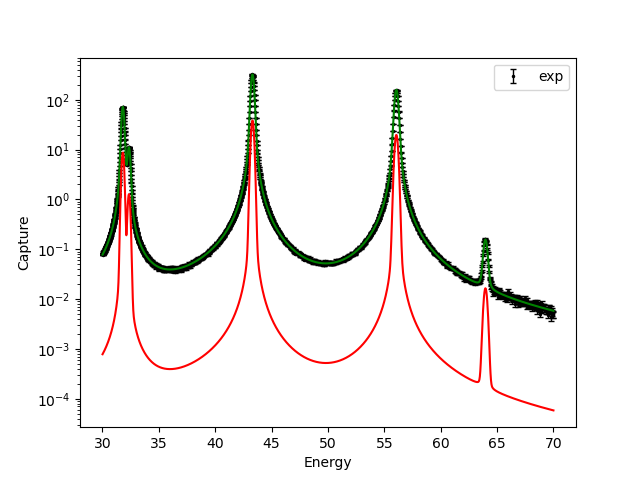

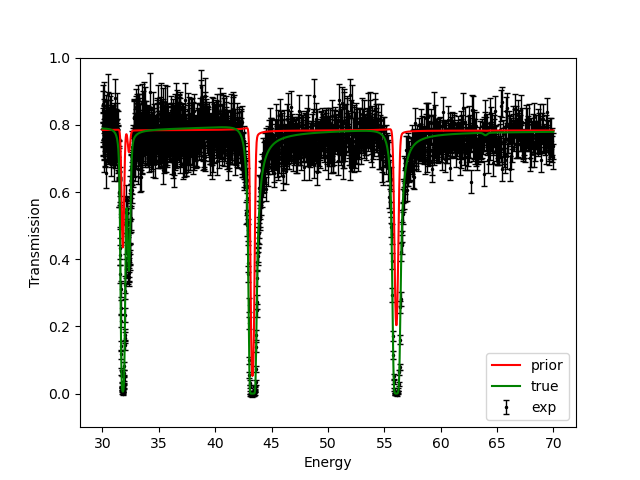

In [16]:
unc_scale = 0.01
out_cap.pw["exp"] = abs(np.random.default_rng().normal(out_cap.pw["theo_xs"], np.sqrt(out_cap.pw["theo_xs"])*unc_scale ))
out_cap.pw["exp_unc"] = np.sqrt(out_cap.pw["exp"])*unc_scale

figure()
plot(out_cap.pw.E, out_cap.pw.theo_xs, ms=1, color='g')
plot(out_cap_est.pw.E, out_cap_est.pw.theo_xs, 'r')
errorbar(out_cap.pw.E,out_cap.pw.exp, yerr=out_cap.pw.exp_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

# ylim([-.1, 1])
yscale('log')
xlabel('Energy'); ylabel('Capture')
legend()



figure()
plot(sammyOUT_fit.pw.E, sammyOUT_fit.pw.theo_trans, ms=1, color='r', label='prior')
plot(sammyOUT.pw.E, sammyOUT.pw.theo_trans, ms=1, color='g', label='true')
errorbar(exp.trans.E, exp.trans.exp, yerr=exp.trans.exp_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

ylim([-.1, 1])
# xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()

In [17]:


sammyRTO.sammy_runDIR = "/Users/noahwalton/Documents/GitHub/ATARI/examples/SAMMY_runDIR_totcapsim"
sammyRTO.keep_runDIR = True
iterations = 3
steps = 20

datasets = [exp.trans, out_cap.pw, samint]
dataset_titles = ["trans1", "cap1"]
reactions = ["transmission", "capture"]
templates = ["allexptot_1sg.inp", "allexpcap_1sg.inp"]
# templates = ["/Users/noahwalton/Documents/GitHub/ATARI/examples/sammy_template.inp"]


sammy_functions.setup_YW_scheme(sammyRTO, sammyINP, datasets, dataset_titles, reactions, templates, 
                                                                                steps=steps,
                                                                                iterations=iterations)

os.system(f"chmod +x {os.path.join(sammyRTO.sammy_runDIR, 'iterate.zsh')}")
os.system(f"chmod +x {os.path.join(sammyRTO.sammy_runDIR, 'run.zsh')}")

0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


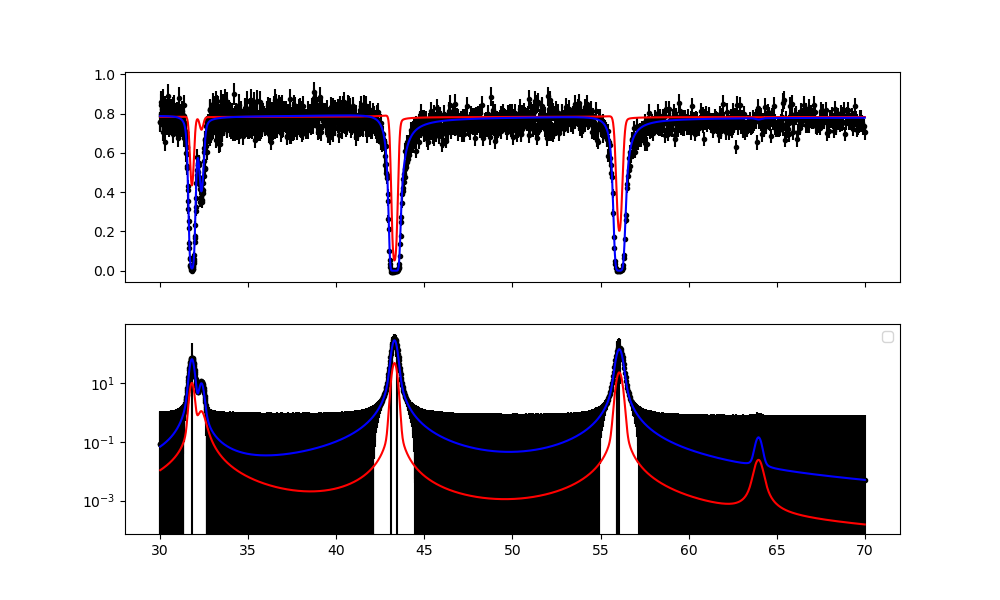

In [19]:
### Read results

T0 = sammy_functions.readlst(os.path.join(sammyRTO.sammy_runDIR,"results/trans1_step0.lst"))
T1 = sammy_functions.readlst(os.path.join(sammyRTO.sammy_runDIR,f"results/trans1_step{steps}.lst"))

C0 = sammy_functions.readlst(os.path.join(sammyRTO.sammy_runDIR,"results/cap1_step1.lst"))
C1 = sammy_functions.readlst(os.path.join(sammyRTO.sammy_runDIR,f"results/cap1_step{steps}.lst"))
# test = sammy_functions.readlst(os.path.join(simdir,"SAMMY.LST"))

fig, axes = subplots(2,1, figsize=(10,6), sharex=True)

axes[0].plot(T0.E, T0.theo_trans, 'r')
axes[0].plot(T1.E, T1.theo_trans, 'b')
# axes[0].plot(sammyOUT.pw.E, sammyOUT.pw.theo_trans, ms=1, color='g', label='true')
axes[0].errorbar(T1.E, T1.exp_trans, yerr=T1.exp_trans_unc, color='k', fmt='.', zorder=0)

axes[1].plot(C0.E, C0.theo_xs, 'r')
axes[1].plot(C1.E, C1.theo_xs, 'b')
# axes[0].plot(sammyOUT.pw.E, sammyOUT.pw.theo_trans, ms=1, color='g', label='true')
axes[1].errorbar(C1.E, C1.exp_xs, yerr=T1.exp_xs_unc, color='k', fmt='.', zorder=0)
axes[1].set_yscale('log')
# for i in range(1,steps+1):
#     lst = sammy_functions.readlst(os.path.join(sammyRTO.sammy_runDIR,f"results/trans1_step{i}.lst"))
#     plot(lst.E, lst.theo_trans, label=i)

legend()

In [ ]:
# import shutil

# def copy_inptemp_to_runDIR(template_path, target_path):
#     shutil.copy(template_path, target_path)


# ### Copy data to folder
# simdir = "/Users/noahwalton/Documents/GitHub/ATARI/examples/SAMMY_runDIR_totcapsim"

# sammy_functions.write_samdat(out_cap.pw, None, os.path.join(simdir,"cap1.dat"))
# sammy_functions.write_samdat(exp.trans, None, os.path.join(simdir,"trans1.dat"))
# sammy_functions.write_sampar(estladder, Ta_pair, True, 0.1, os.path.join(simdir, "initial.par"))
# ### Make Input files

# datasets = ["cap1", "trans1"]
# reactions = ["capture", "transmission"]

# for ds, rxn in zip(datasets, reactions):
#     copy_inptemp_to_runDIR("/Users/noahwalton/Documents/GitHub/ATARI/examples/sammy_template.inp", os.path.join(simdir, f"{ds}_initial.inp"))
#     sammy_functions.write_saminp(os.path.join(simdir,f"{ds}_initial.inp"), sammyRTO.model, sammyRTO.solve_bayes, rxn, sammyINP, 
#                                 alphanumeric=["yw"])

# # for ds, rxn in zip(datasets, reactions):
#     copy_inptemp_to_runDIR("/Users/noahwalton/Documents/GitHub/ATARI/examples/sammy_template.inp", os.path.join(simdir, f"{ds}_step.inp"))
#     sammy_functions.write_saminp(os.path.join(simdir,f"{ds}_step.inp"), sammyRTO.model, sammyRTO.solve_bayes, rxn, sammyINP, 
#                                 # alphanumeric=["yw"])#,"Use remembered original parameter values"])
#                                 alphanumeric=["yw","Use remembered original parameter values"])


#     copy_inptemp_to_runDIR("/Users/noahwalton/Documents/GitHub/ATARI/examples/sammy_template.inp", os.path.join(simdir, f"{ds}_plot.inp"))
#     sammy_functions.write_saminp(os.path.join(simdir,f"{ds}_plot.inp"), sammyRTO.model, False, rxn, sammyINP, 
#                                 alphanumeric=[])


# copy_inptemp_to_runDIR("/Users/noahwalton/Documents/GitHub/ATARI/examples/sammy_template.inp", os.path.join(simdir, "solvebayes_initial.inp"))
# sammy_functions.write_saminp(os.path.join(simdir,"solvebayes_initial.inp"), sammyRTO.model, sammyRTO.solve_bayes, "reaction", sammyINP, 
#                             #  alphanumeric=["wy", "CHI SQUARED IS WANTED"])#, "USE LEAST SQUARES TO GIVE COVARIANCE MATRIX", "Remember original parameter values", "Take baby steps with Least-Squares method", "CHI SQUARED IS WANTED"])
#                              alphanumeric=["wy", "CHI SQUARED IS WANTED", "USE LEAST SQUARES TO GIVE COVARIANCE MATRIX", "Remember original parameter values", "Take baby steps with Least-Squares method", "CHI SQUARED IS WANTED"])


# copy_inptemp_to_runDIR("/Users/noahwalton/Documents/GitHub/ATARI/examples/sammy_template.inp", os.path.join(simdir, "solvebayes_step.inp"))
# sammy_functions.write_saminp(os.path.join(simdir,"solvebayes_step.inp"), sammyRTO.model, sammyRTO.solve_bayes, "reaction", sammyINP, 
#                             #  alphanumeric=["wy", "CHI SQUARED IS WANTED"])#, "USE LEAST SQUARES TO GIVE COVARIANCE MATRIX", "Use remembered original parameter values", "Take baby steps with Least-Squares method"])
#                              alphanumeric=["wy", "CHI SQUARED IS WANTED", "USE LEAST SQUARES TO GIVE COVARIANCE MATRIX", "Use remembered original parameter values", "Take baby steps with Least-Squares method"])





# sammy_functions.write_estruct_file(out_cap.pw.E, os.path.join(simdir,"dummy.dat"))
# ### Make bash script

# sammyexe = sammyRTO.path_to_SAMMY_exe
# steps = 20

# with open(os.path.join(simdir, "run.zsh"), 'w+') as f:

#     for i in range(1,steps+1):
#         if i == 1:
#             stepstr_prior = 'initial' #f"step{i}" #
#             cov = ''
#             par = 'initial.par'
#             inp_ext = 'initial'
#         else:
#             stepstr_prior = f'step{i-1}'
#             cov = f"results/bayes_{stepstr_prior}.cov"
#             par = f"results/bayes_{stepstr_prior}.par"
#             inp_ext = 'step'

#         # Write commands for each dataset
#         for ds in datasets:
#             title = f"{ds}_{stepstr_prior}"#step{i}
#             f.write(f"##################################\n# Generate YW for {ds}\n")
#             f.write(f"{sammyexe}<<EOF\n{ds}_{inp_ext}.inp\n{par}\n{ds}.dat\n{cov}\n\nEOF\n")
#             f.write(f"""mv -f SAMMY.LPT "results/{title}.lpt" \nmv -f SAMMY.ODF "results/{title}.odf" \nmv -f SAMMY.LST "results/{title}.lst" \nmv -f SAMMY.YWY "results/{title}.ywy" \nrm -f "SAM*.*"\n""")    

#         # write commands for bayes solve
#         dataset_inserts = "\n".join([f"results/{ds}_{stepstr_prior}.ywy" for ds in datasets])
#         title = f"bayes_step{i}"
#         f.write(f"#######################################################\n# Run Bayes for {title}\n#\n#######################################################\n")
#         f.write(f"{sammyexe}<<EOF\nsolvebayes_{inp_ext}.inp\n{par}\ndummy.dat\n{dataset_inserts}\n\n{cov}\n\nEOF\n")
#         f.write(f"""mv -f SAMMY.LPT results/{title}.lpt \nmv -f SAMMY.PAR results/{title}.par \nmv -f SAMMY.COV results/{title}.cov \nrm -f SAM*\n""")

#     f.write(f"\n\n\n\n############## Copy Final Result ###########\nhead -$(($(wc -l < results/bayes_step{i}.par) - 3)) results/bayes_step{i}.par > final.par\n\n")
#     ### After all steps, write commands to make plot
#     for ds in datasets:
#         f.write(f"#######################################################\n# Plotting for {ds} Final/Initial\n#\n#######################################################\n")
#         f.write(f"{sammyexe}<<EOF\n{ds}_plot.inp\nfinal.par\n{ds}.dat\n\nEOF\n")
#         f.write(f"mv -f SAMMY.LST {ds}_final.lst\nmv -f SAMMY.PAR {ds}_final.par\nrm -f SAM*\n\n")

#         f.write(f"{sammyexe}<<EOF\n{ds}_plot.inp\ninitial.par\n{ds}.dat\n\nEOF\n")
#         f.write(f"mv -f SAMMY.LST {ds}_initial.lst\nrm -f SAM*\n")

<ErrorbarContainer object of 3 artists>

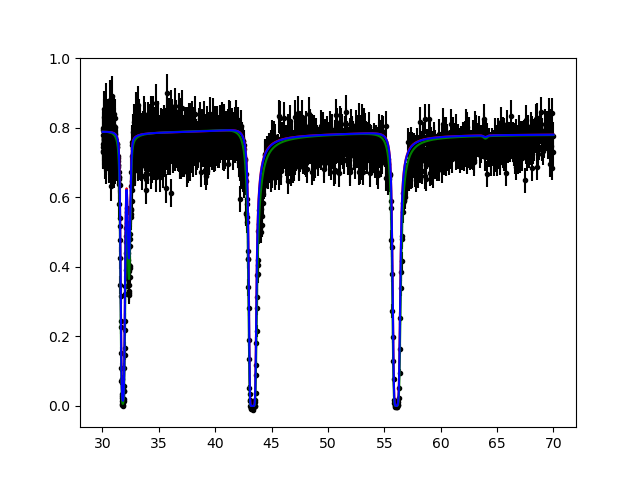

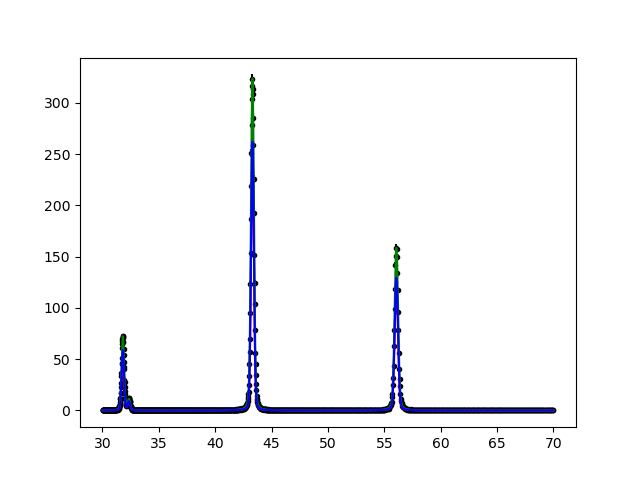

In [ ]:
# ### Read results

# final_trans = sammy_functions.readlst(os.path.join(simdir,"trans1_final.lst"))
# initial_trans = sammy_functions.readlst(os.path.join(simdir,"trans1_initial.lst"))

# final_cap = sammy_functions.readlst(os.path.join(simdir,"cap1_final.lst"))
# initial_cap = sammy_functions.readlst(os.path.join(simdir,"cap1_initial.lst"))

# figure()
# plot(initial_trans.E, initial_trans.theo_trans, 'r')
# plot(sammyOUT.pw.E, sammyOUT.pw.theo_trans, ms=1, color='g', label='true')
# plot(final_trans.E, final_trans.theo_trans, 'b')

# errorbar(final_trans.E, final_trans.exp_trans, yerr=final_trans.exp_trans_unc, color='k', fmt='.', zorder=0)

# figure()
# plot(initial_cap.E, initial_cap.theo_xs, 'r')
# plot(out_cap.pw.E, out_cap.pw.theo_xs, ms=1, color='g')

# plot(final_cap.E, final_cap.theo_xs, 'b')
# errorbar(final_cap.E, final_cap.exp_xs, yerr=final_cap.exp_xs_unc, color='k', fmt='.', zorder=0)

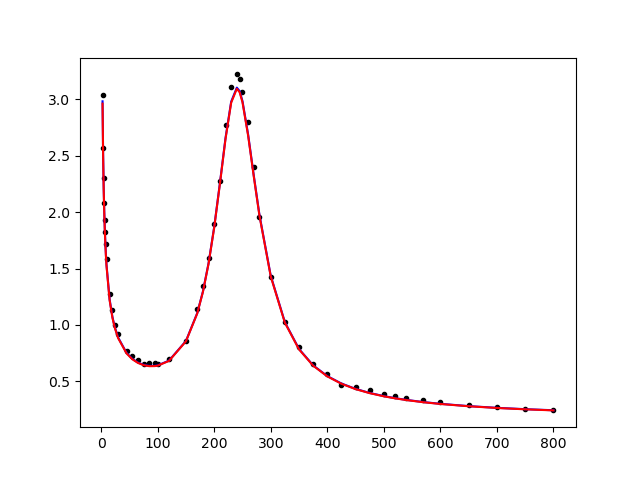

In [ ]:
test = sammy_functions.readlst("/Users/noahwalton/gitlab/sammy/sammy/samtry/tr163/answers/ria.lst")
testp = sammy_functions.readlst("/Users/noahwalton/gitlab/sammy/sammy/samtry/tr163/answers/raa.lst")

figure()
plot(test.E, test.exp_xs, 'k.')
plot(test.E, test.theo_xs, 'b')
plot(testp.E, testp.theo_xs, 'r')

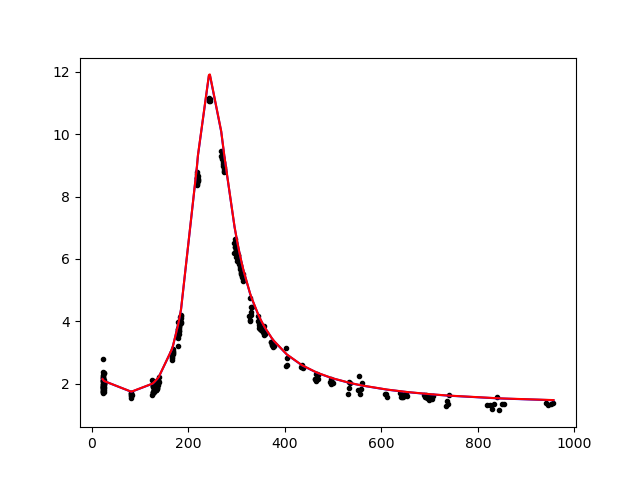

In [ ]:
test = sammy_functions.readlst("/Users/noahwalton/gitlab/sammy/sammy/samtry/tr163/answers/ric.lst")
testp = sammy_functions.readlst("/Users/noahwalton/gitlab/sammy/sammy/samtry/tr163/answers/rac.lst")

figure()
plot(test.E, test.exp_xs, 'k.')
plot(test.E, test.theo_xs, 'b')
plot(testp.E, testp.theo_xs, 'r')

<ErrorbarContainer object of 3 artists>

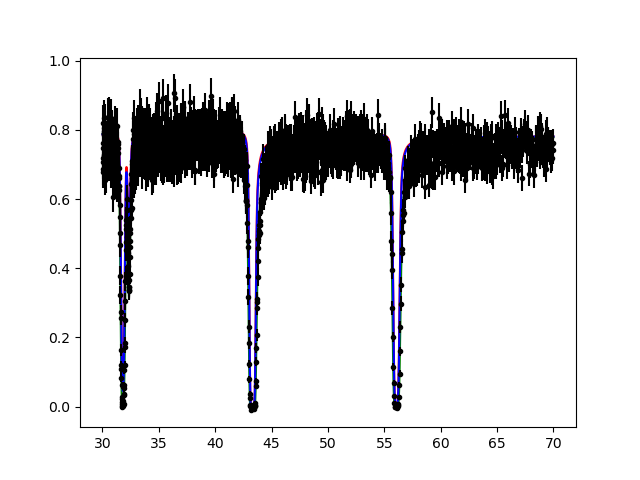

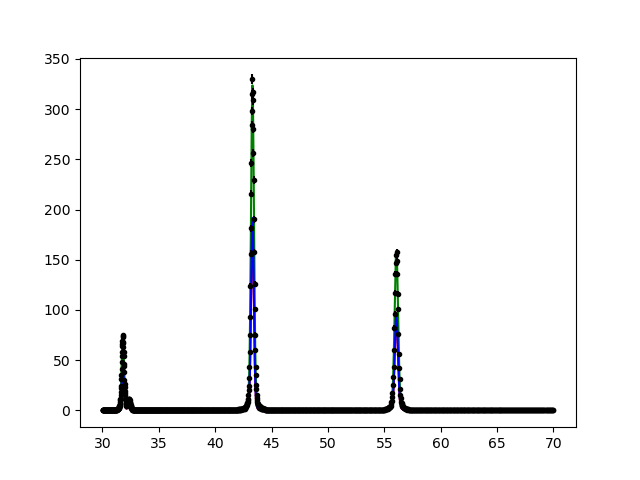

In [ ]:
# final_trans = sammy_functions.readlst(os.path.join(simdir,"trans1_final.lst"))
# initial_trans = sammy_functions.readlst(os.path.join(simdir,"trans1_initial.lst"))

# final_cap = sammy_functions.readlst(os.path.join(simdir,"cap1_final.lst"))
# initial_cap = sammy_functions.readlst(os.path.join(simdir,"cap1_initial.lst"))

# figure()
# plot(initial_trans.E, initial_trans.theo_trans, 'r')
# plot(sammyOUT.pw.E, sammyOUT.pw.theo_trans, ms=1, color='g', label='true')

# plot(final_trans.E, final_trans.theo_trans, 'b')
# errorbar(final_trans.E, final_trans.exp_trans, yerr=final_trans.exp_trans_unc, color='k', fmt='.')

# figure()
# plot(initial_cap.E, initial_cap.theo_xs, 'r')
# plot(out_cap.pw.E, out_cap.pw.theo_xs, ms=1, color='g')

# plot(final_cap.E, final_cap.theo_xs, 'b')
# errorbar(final_cap.E, final_cap.exp_xs, yerr=final_cap.exp_xs_unc, color='k', fmt='.')

In [ ]:
test

,E,exp_dat,exp_dat_unc
0,30.004192,0.133255,0.091260
1,30.017428,0.092178,0.075902
2,30.030673,0.148056,0.096195
3,30.043926,0.087671,0.074023
4,30.057189,0.138970,0.093197
...,...,...,...
1562,69.811776,0.015676,0.031301
1563,69.858761,0.006097,0.019521
1564,69.905793,0.013302,0.028834
1565,69.952873,0.008242,0.022696


<ErrorbarContainer object of 3 artists>

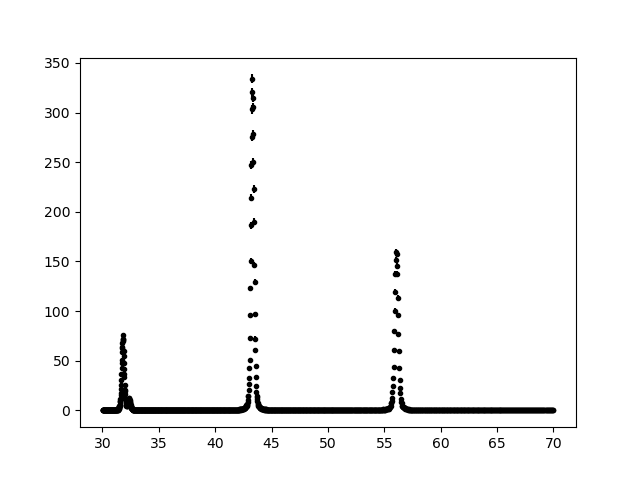

In [ ]:
test = sammy_functions.readlst(os.path.join(simdir,"cap1.dat"))
figure()
errorbar(test.E, test.exp_dat, yerr=test.exp_dat_unc,color='k', fmt='.' )

In [ ]:
# #!/bin/csh

# ########################################################################
# # a: Generate Y & W for each of the three data sets; get Chi^2 also.
# #    (This corresponds to step b in Section IV.E.1 of the SAMMY manual.)
# ########################################################################

# ####################################
# # aa: Initial run with (n,t) data
# sammy<<EOF
# t163aa.inp
# t163a.par
# t163za.dat

# EOF
# mv -f SAMMY.LPT results/raa.lpt
# mv -f SAMMY.ODF results/raa.odf
# mv -f SAMMY.LST results/raa.lst
# mv -f SAMMY.YWY results/raa.ywy
# #mv -f SAMMY.UVV results/raa.uvv
# rm -f SAM*.*

# ####################################
# # ab: Initial run with (n,t) data
# sammy<<EOF
# t163ab.inp
# t163a.par
# t163zb.dat

# EOF
# mv -f SAMMY.LPT results/rab.lpt
# mv -f SAMMY.ODF results/rab.odf
# mv -f SAMMY.LST results/rab.lst
# mv -f SAMMY.YWY results/rab.ywy
# #mv -f SAMMY.UVV results/rab.uvv
# rm -f SAM*.*

# ####################################
# # ac: Initial run with total data
# sammy<<EOF
# t163ac.inp
# t163a.par
# t163zc.dat

# EOF
# mv -f SAMMY.LPT results/rac.lpt
# mv -f SAMMY.ODF results/rac.odf
# mv -f SAMMY.LST results/rac.lst
# mv -f SAMMY.YWY results/rac.ywy
# #mv -f SAMMY.UVV results/rac.uvv
# rm -f SAM*.*

# ########################################################################
# # b: Solve Bayes' equations for updated parameter values
# #    (This corresponds to step d in Section IV.E.1 of the SAMMY manual.)
# ########################################################################
# sammy<<eod
# t163b.inp
# t163a.par
# dummy.dat
# results/raa.ywy
# results/rab.ywy
# results/rac.ywy

# eod
# mv -f SAMMY.LPT results/rbb.lpt
# mv -f SAMMY.PAR results/rbb.par
# mv -f SAMMY.COV results/rbb.cov
# cp -f REMORI.PAR results/rbb.rem
# rm -f SAM*


# ########################################################################
# # c: Generate new Y & W for each of the three data sets; get Chi^2 also
# #    (This corresponds to step e in Section IV.E.1 of the SAMMY manual.)
# ########################################################################

# ####################################
# # ca: Second run with (n,t) data
# sammy<<EOF
# t163ca.inp
# results/rbb.par
# t163za.dat
# results/rbb.cov

# EOF
# mv -f SAMMY.LPT results/rca.lpt
# mv -f SAMMY.ODF results/rca.odf
# mv -f SAMMY.LST results/rca.lst
# mv -f SAMMY.YWY results/rca.ywy
# #mv -f SAMMY.UVV results/rca.uvv
# rm -f SAM*.*

# ####################################
# # cb: Second run with (n,t) data
# sammy<<EOF
# t163cb.inp
# results/rbb.par
# t163zb.dat
# results/rbb.cov

# EOF
# mv -f SAMMY.LPT results/rcb.lpt
# mv -f SAMMY.ODF results/rcb.odf
# mv -f SAMMY.LST results/rcb.lst
# mv -f SAMMY.YWY results/rcb.ywy
# #mv -f SAMMY.UVV results/rcb.uvv
# rm -f SAM*.*

# ####################################
# # cc: Second run with total data
# sammy<<EOF
# t163cc.inp
# results/rbb.par
# t163zc.dat
# results/rbb.cov

# EOF
# mv -f SAMMY.LPT results/rcc.lpt
# mv -f SAMMY.ODF results/rcc.odf
# mv -f SAMMY.LST results/rcc.lst
# mv -f SAMMY.YWY results/rcc.ywy
# #mv -f SAMMY.UVV results/rcc.uvv
# rm -f SAM*.*

# ########################################################################
# # d: Solve Bayes' equations for updated parameter values
# #    (This corresponds to step g in Section IV.E.1 of the SAMMY manual.)
# ########################################################################
# sammy<<eod
# t163d.inp
# results/rbb.par
# dummy.dat
# results/rca.ywy
# results/rcb.ywy
# results/rcc.ywy

# results/rbb.cov

# eod
# mv -f SAMMY.LPT results/rdd.lpt
# mv -f SAMMY.PAR results/rdd.par
# mv -f SAMMY.COV results/rdd.cov
# rm -f SAM*


# ########################################################################
# # e: Generate new Y & W for each of the three data sets; get Chi^2 also
# #    (Begin repeating steps e,f,g of Section IV.E.1 of SAMMY manual.)
# ########################################################################

# ####################################
# # ea: Next run with (n,t) data
# sammy<<EOF
# t163ca.inp
# results/rdd.par
# t163za.dat
# results/rdd.cov

# EOF
# mv -f SAMMY.LPT results/rea.lpt
# mv -f SAMMY.ODF results/rea.odf
# mv -f SAMMY.LST results/rea.lst
# mv -f SAMMY.YWY results/rea.ywy
# #mv -f SAMMY.UVV results/rea.uvv
# rm -f SAM*.*

# ####################################
# # eb: Next run with (n,t) data
# sammy<<EOF
# t163cb.inp
# results/rdd.par
# t163zb.dat
# results/rdd.cov

# EOF
# mv -f SAMMY.LPT results/reb.lpt
# mv -f SAMMY.ODF results/reb.odf
# mv -f SAMMY.LST results/reb.lst
# mv -f SAMMY.YWY results/reb.ywy
# #mv -f SAMMY.UVV results/reb.uvv
# rm -f SAM*.*

# ####################################
# # ec: Next run with total data
# sammy<<EOF
# t163cc.inp
# results/rdd.par
# t163zc.dat
# results/rdd.cov

# EOF
# mv -f SAMMY.LPT results/rec.lpt
# mv -f SAMMY.ODF results/rec.odf
# mv -f SAMMY.LST results/rec.lst
# mv -f SAMMY.YWY results/rec.ywy
# #mv -f SAMMY.UVV results/rec.uvv
# rm -f SAM*.*

# ########################################################################
# # f: Solve Bayes' equations for updated parameter values
# ########################################################################
# sammy<<eod
# t163d.inp
# results/rdd.par
# dummy.dat
# results/rea.ywy
# results/reb.ywy
# results/rec.ywy

# results/rdd.cov

# eod
# mv -f SAMMY.LPT results/rff.lpt
# mv -f SAMMY.PAR results/rff.par
# mv -f SAMMY.COV results/rff.cov
# rm -f SAM*


# ########################################################################
# # g: Generate new Y & W for each of the three data sets; get Chi^2 also
# ########################################################################

# ####################################
# # ga: Next run with (n,t) data
# sammy<<EOF
# t163ca.inp
# results/rff.par
# t163za.dat
# results/rff.cov

# EOF
# mv -f SAMMY.LPT results/rga.lpt
# mv -f SAMMY.ODF results/rga.odf
# mv -f SAMMY.LST results/rga.lst
# mv -f SAMMY.YWY results/rga.ywy
# #mv -f SAMMY.UVV results/rga.uvv
# rm -f SAM*.*

# ####################################
# # gb: Next run with (n,t) data
# sammy<<EOF
# t163cb.inp
# results/rff.par
# t163zb.dat
# results/rff.cov

# EOF
# mv -f SAMMY.LPT results/rgb.lpt
# mv -f SAMMY.ODF results/rgb.odf
# mv -f SAMMY.LST results/rgb.lst
# mv -f SAMMY.YWY results/rgb.ywy
# #mv -f SAMMY.UVV results/rgb.uvv
# rm -f SAM*.*

# ####################################
# # gc: Next run with total data
# sammy<<EOF
# t163cc.inp
# results/rff.par
# t163zc.dat
# results/rff.cov

# EOF
# mv -f SAMMY.LPT results/rgc.lpt
# mv -f SAMMY.ODF results/rgc.odf
# mv -f SAMMY.LST results/rgc.lst
# mv -f SAMMY.YWY results/rgc.ywy
# #mv -f SAMMY.UVV results/rgc.uvv
# rm -f SAM*.*

# ########################################################################
# # h: Solve Bayes' equations for updated parameter values
# ########################################################################
# sammy<<eod
# t163d.inp
# results/rff.par
# dummy.dat
# results/rga.ywy
# results/rgb.ywy
# results/rgc.ywy

# results/rff.cov

# eod
# mv -f SAMMY.LPT results/rhh.lpt
# mv -f SAMMY.PAR results/rhh.par
# mv -f SAMMY.COV results/rhh.cov
# rm -f SAM*


# ########################################################################
# # i: Generate new Y & W for each of the three data sets; get Chi^2 also
# ########################################################################

# ####################################
# # ia: Next run with (n,t) data
# sammy<<EOF
# t163ca.inp
# results/rhh.par
# t163za.dat
# results/rhh.cov

# EOF
# mv -f SAMMY.LPT results/ria.lpt
# mv -f SAMMY.ODF results/ria.odf
# mv -f SAMMY.LST results/ria.lst
# mv -f SAMMY.YWY results/ria.ywy
# #mv -f SAMMY.UVV results/ria.uvv
# rm -f SAM*.*

# ####################################
# # ib: Next run with (n,t) data
# sammy<<EOF
# t163cb.inp
# results/rhh.par
# t163zb.dat
# results/rhh.cov

# EOF
# mv -f SAMMY.LPT results/rib.lpt
# mv -f SAMMY.ODF results/rib.odf
# mv -f SAMMY.LST results/rib.lst
# mv -f SAMMY.YWY results/rib.ywy
# #mv -f SAMMY.UVV results/rib.uvv
# rm -f SAM*.*

# ####################################
# # ic: Next run with total data
# sammy<<EOF
# t163cc.inp
# results/rhh.par
# t163zc.dat
# results/rhh.cov

# EOF
# mv -f SAMMY.LPT results/ric.lpt
# mv -f SAMMY.ODF results/ric.odf
# mv -f SAMMY.LST results/ric.lst
# mv -f SAMMY.YWY results/ric.ywy
# #mv -f SAMMY.UVV results/ric.uvv
# rm -f SAM*.*

# ########################################################################
# # If greater convergence is wanted, one can continue to rerun steps h & i
# # using command file test126_many, which runs (h&i) 20 times, each time
# # overwriting the previous results.  To watch the convergence, see the
# # chi-squared values as printed in the log files t0xy.log (xy = 01 to 20)
# # e.g., using a command like "grep -i chi *.log"
# ########################################################################

# rm -f REMORI.PAR
# ########################################################################
# cd results
# #rm -f *.lis
# grep -i "RED DIV" *.lpt > rrchi.lis
# grep -i "total time" *.lpt > rtime.lis
# cd ..
